In [1]:
import Pkg; Pkg.activate(".")

using ExcelFiles, ExcelReaders, DataFrames, DataFramesMeta, Dates, Statistics, ProgressMeter, CategoricalArrays
using CSV, DataStructures, Roots, CovarianceMatrices, Loess, RegressionTables, Optim, LeastSquaresOptim
using VegaLite, VegaDatasets
using FixedEffectModels, BasisMatrices, LinearAlgebra, Plots, Measures, GLM, StatsPlots; gr()
using ForwardDiff, FiniteDiff, SparseDiffTools, SparseArrays, IncompleteLU, BenchmarkTools, Random, Splines2, Loess

ENV["COLUMNS"] = 180

path = "E:\\Documents\\Dropbox\\NYU\\Proposals\\Long-run Rates\\";

  Activating environment at `E:\Documents\Dropbox\NYU\Proposals\Duration Mismatch\Project.toml`


In [2]:
# load interest rates 
rate_treasury = DataFrame(load(path * "Treasury Yield Curve.xlsx", "Svensson"))
rate_treasury[!, :Date] .= Dates.Date.(rate_treasury[:, :Date])
rename!(rate_treasury, :Date => :date)
rate_treasury = stack(rate_treasury, Not(:date), variable_name = :horizon)
rate_treasury[!, :horizon] .= parse.(Int64, [s[6:7] for s in rate_treasury[:, :horizon]])
rename!(rate_treasury, :value => :rate)
rate_treasury[!, :rate] = [s == "NA" ? missing : s for s in rate_treasury[:, :rate]]
rate_treasury[!, :date] .= Dates.firstdayofmonth.(rate_treasury[:, :date])
rate_treasury = @combine(groupby(rate_treasury, [:date, :horizon]), rate = mean(skipmissing(:rate),))
rate_treasury[!, :year] = Dates.year.(rate_treasury[:, :date])

rate_HQM = DataFrame(load(path * "HQM yield curve.xlsx", "Sheet1"))
rate_HQM = select(rate_HQM, 1:31)
rate_HQM[!, :x1] .= Dates.Date.(rate_HQM[:, :x1])
rename!(rate_HQM, :x1 => :date)
rate_HQM = stack(rate_HQM, Not(:date), variable_name = :horizon)
rate_HQM[!, :horizon] .= parse.(Int64, rate_HQM[:, :horizon])
rename!(rate_HQM, :value => :rate)
rate_HQM[!, :rate] = [s == "NA" ? missing : s for s in rate_HQM[:, :rate]]
rate_HQM[!, :date] .= Dates.firstdayofmonth.(rate_HQM[:, :date])
rate_HQM = @combine(groupby(rate_HQM, [:date, :horizon]), rate = mean(skipmissing(:rate),))
rate_HQM[!, :year] = Dates.year.(rate_HQM[:, :date])

rate_reserve = path * "NAIC Moodys Corporate Bond Yields.xlsx";
rate_reserve = DataFrame(load(rate_reserve, "Sheet1!A2:B456", header = false))
rename!(rate_reserve, [:x1 => :date, :x2 => :rate])
rate_reserve[!, :date] .= Dates.Date.(rate_reserve[:, :date])

# p = plot(rate_reserve[:, :date], rate_reserve[:, :rate], 
#     label = "Reference Rate",
#     size = (960, 480), html_output_format=:png, margin = 5mm, width = 2,
#     xticks = Date(1980,1,1):Dates.Year(5):Date(2020,1,1),
#     xlim = (Date(1980,1,1), maximum(:dates)))

y = Union{Missing, Float64}[missings(nrow(rate_reserve))...]
for (t, d) in enumerate(rate_reserve[:, :date])
    try
        cutoff = Date(Dates.year(d), 6, 1)
        ind = findfirst(rate_reserve[:, :date] .== cutoff)
        rates_12 = rate_reserve[ind-12+1:ind, :rate]
        rates_36 = rate_reserve[ind-36+1:ind, :rate]
        y[t] = min(mean(rates_12), mean(rates_36))
        y[t] = round(4 * ((0.03 + 0.35 * (min(y[t]/100, 0.09) - 0.03) + 0.175 * (max(y[t]/100, 0.09) - 0.09)) * 100)) / 4
    catch end
end
rate_reserve[!, :rate_life] = y

y = Union{Missing, Float64}[missings(nrow(rate_reserve))...]
for (t, d) in enumerate(rate_reserve[:, :date])
    try
        cutoff = Date(Dates.year(d), 6, 1)
        ind = findfirst(rate_reserve[:, :date] .== cutoff)
        rates_12 = rate_reserve[ind-12+1:ind, :rate]
        y[t] = min(mean(rates_12))
        y[t] = round(4 * ((0.03 + 0.8 * (y[t]/100 - 0.03)) * 100)) / 4
    catch end
end
rate_reserve[!, :rate_ann] = y

rate_reserve = @combine(groupby(@transform(rate_reserve, year = Dates.year.(:date)), :year), 
    rate_life = first(:rate_life), rate_ann = first(:rate_ann));

# png(p, "reserve rate.png")

# p

In [3]:
# unloaded probabilities  
# starts at age 45
unloaded_1983_true = vcat(Float64.(readxl(path * "1983 IAM Basic.xlsx", 
            "Sheet1!B42:B112")), ones(5))[:]
unloaded_1983_false = vcat(Float64.(readxl(path * "1983 IAM Basic.xlsx", 
            "Sheet1!C42:C112")), ones(5))[:]
unloaded_2000_true = vcat(Float64.(readxl(path * "Annuity 2000 Basic.xlsx", 
            "Sheet1!B42:B112")), ones(5))[:]
unloaded_2000_false = vcat(Float64.(readxl(path * "Annuity 2000 Basic.xlsx", 
            "Sheet1!C42:C112")), ones(5))[:]
unloaded_2015_true = Float64.(readxl(path * "2012 IAM Basic.xlsx", 
            "Sheet1!B47:B122"))[:]
unloaded_2015_false = Float64.(readxl(path * "2012 IAM Basic.xlsx", 
            "Sheet1!C47:C122"))[:]
G2_2015_true = Float64.(readxl(path * "2012 IAM G2.xlsx", 
            "Sheet1!B47:B122"))[:]
G2_2015_false = Float64.(readxl(path * "2012 IAM G2.xlsx", 
            "Sheet1!C47:C122"))[:]

# starts at age 18 to 115
unloaded_1980_true = vcat(Float64.(readxl(path * "1980 CSO Basic.xlsx", "Sheet1!B2:B102")), 1, 1)[:];

ult = Float64.(readxl(path *                    "2001 CSO.xlsx", "B.2.a.iii!AA26:AA103"))[:]
unloaded_2001_MN4 = hcat(Float64.(readxl(path * "2001 CSO.xlsx", "B.2.a.iii!B26:Z93")),
    hcat([vcat(ult[i:end], 1000 .* ones(i-1)) for i in 1:68]...)') ./ 1000;

ult = Float64.(readxl(path *                    "2008 VBT MN RR.xlsx", "Male RR120 NS ALB!AA6:AA83"))[:]
unloaded_2008_MN4 = hcat(Float64.(readxl(path * "2008 VBT MN RR.xlsx", "Male RR120 NS ALB!B6:Z73")),
    hcat([vcat(ult[i:end], 1000 .* ones(i-1)) for i in 1:68]...)') ./ 1000;

ult = Float64.(readxl(path *                    "2015 VBT MN RR.xlsx", "2015 RR125 MNS ALB!AA4:AA81"))[:]
unloaded_2015_MN4 = hcat(Float64.(readxl(path * "2015 VBT MN RR.xlsx", "2015 RR125 MNS ALB!B4:Z71")),
    hcat([vcat(ult[i:end], 1000 .* ones(i-1)) for i in 1:68]...)') ./ 1000;

In [4]:
# loaded probabilities  
loaded_1983_true = vcat(Float64.(readxl(path * "1983 IAM.xlsx", 
            "Sheet1!B42:B112")))[:]
loaded_1983_false = vcat(Float64.(readxl(path * "1983 IAM.xlsx", 
            "Sheet1!C42:C112")))[:]
loaded_2000_true = vcat(Float64.(readxl(path * "Annuity 2000.xlsx", 
            "Sheet1!B42:B112")))[:]
loaded_2000_false = vcat(Float64.(readxl(path * "Annuity 2000.xlsx", 
            "Sheet1!C42:C112")))[:]
loaded_2012_true = Float64.(readxl(path * "2012 IAM Period.xlsx", 
            "Sheet1!B47:B117"))[:]
loaded_2012_false = Float64.(readxl(path * "2012 IAM Period.xlsx", 
            "Sheet1!C47:C117"))[:]

loaded_1980_true = vcat(Float64.(readxl(path * "1980 CSO.xlsx", "Sheet1!B2:B102")), 1, 1)[:]

ult = Float64.(readxl(path *                  "2001 CSO.xlsx", "A.3.a.iii!AA26:AA103"))[:]
loaded_2001_MN4 = hcat(Float64.(readxl(path * "2001 CSO.xlsx", "A.3.a.iii!B26:Z93")),
    hcat([vcat(ult[i:end], 1000 .* ones(i-1)) for i in 1:68]...)') ./ 1000;

In [5]:
# functions  
function survival_benefits(age, death_rates)
    death_rates = death_rates[age - 45 + 1:end]
    survival_rates = zeros(76)
    
    survival_rates[1] = 1 - death_rates[1]
    @inbounds for i in 2:length(death_rates)
        survival_rates[i] = survival_rates[i-1] * (1 - death_rates[i])
    end
    @views survival_rates[length(death_rates) + 1:length(survival_rates)] .= 0
    
    return survival_rates
end

function death_benefits(age, benefit, pay, death_rates, death_rates2)
    survival_rates = zeros(103)
    
    survival_rates[1] = 1 - death_rates[1]
    
    for i in 2:length(death_rates)
        survival_rates[i] = survival_rates[i-1] * (1 - death_rates[i])
    end
    @views survival_rates[length(death_rates) + 1:length(survival_rates)] .= 0
    
    V = @views sum(cum_discounts[1:min(103, benefit - age)] .* vcat(1.0, survival_rates[1:min(102, benefit - age - 1)]) .* death_rates[1:min(103, benefit - age)]) / 
        (1 + sum(cum_discounts[1:min(102, pay - age - 1)] .* survival_rates[1:min(102, pay - age - 1)]))
    
    death_rates = death_rates2
    survival_rates = zeros(103)
    
    survival_rates[1] = 1 - death_rates[1]
    
    for i in 2:length(death_rates)
        survival_rates[i] = survival_rates[i-1] * (1 - death_rates[i])
    end
    @views survival_rates[length(death_rates) + 1:length(survival_rates)] .= 0
    
    return (vcat(0, (vcat(1.0, survival_rates[1:min(102, benefit - age - 1)]) .* death_rates[1:min(103, benefit - age)])[1:end-1]) .-
        V .* vcat(1, survival_rates[1:min(102, pay - age - 1)]))[1:51], vcat(1.0, survival_rates[1:min(102, benefit - age - 1)]) .* death_rates[1:min(103, benefit - age)]
end

function value_cum_discounts(product, death_rates, cum_discounts, survival_rates; pop = 1.0)
    
    survival_rates[1] = pop * (1 - death_rates[1])
    @inbounds for i in 2:length(death_rates)
        survival_rates[i] = survival_rates[i-1] * (1 - death_rates[i])
    end
    @views survival_rates[length(death_rates) + 1:length(survival_rates)] .= 0
    
    if product == "5"
        @views return sum(cum_discounts[1:5])  / 1 #sum(cum_discounts[1:5])
    elseif product == "10"
        @views return sum(cum_discounts[1:10]) / 1 #sum(cum_discounts[1:10])
    elseif product == "15"
        @views return sum(cum_discounts[1:15]) / 1 #sum(cum_discounts[1:15])
    elseif product == "20"
        @views return sum(cum_discounts[1:20]) / 1 #sum(cum_discounts[1:20])
    elseif product == "25"
        @views return sum(cum_discounts[1:25]) / 1 #sum(cum_discounts[1:25])
    elseif product == "30"
        @views return sum(cum_discounts[1:30]) / 1 #sum(cum_discounts[1:30])
    elseif product == "LifeOnly"
        return sum(cum_discounts .* survival_rates) / 1 #sum(cum_discounts .* survival_rates)
    elseif product == "Guarantee10yr"
        @views return (sum(cum_discounts[1:10]) + sum(cum_discounts[11:end] .* survival_rates[11:end] .* (11:length(cum_discounts)))) / 
            1 #(sum(cum_discounts[1:10]) + sum(cum_discounts[11:end] .* survival_rates[11:end]))
    elseif product == "Guarantee20yr"
        @views return (sum(cum_discounts[1:20]) + sum(cum_discounts[21:end] .* survival_rates[21:end])) / 
            1 #(sum(cum_discounts[1:20]) + sum(cum_discounts[21:end] .* survival_rates[21:end]))
    end
end

function duration_cum_discounts(product, death_rates, cum_discounts, survival_rates)
    
    survival_rates[1] = 1 - death_rates[1]
    @inbounds for i in 2:length(death_rates)
        survival_rates[i] = survival_rates[i-1] * (1 - death_rates[i])
    end
    @views survival_rates[length(death_rates) + 1:length(survival_rates)] .= 0
    
    if product == "LifeOnly"
        return sum(collect(1:length(survival_rates)) .* cum_discounts .* survival_rates) / 
            sum(cum_discounts .* survival_rates)
    end
end

# function value_cum_discounts(product, death_rates, cum_discounts, survival_rates, 
#         age = 0, pay = 120, benefit = 120, cum_disc_trea = zeros(103))
    
#     survival_rates[1] = 1 - death_rates[1]
    
#     for i in 2:length(death_rates)
#         survival_rates[i] = survival_rates[i-1] * (1 - death_rates[i])
#     end
#     @views survival_rates[length(death_rates) + 1:length(survival_rates)] .= 0
    
#     @views sum(cum_discounts[1:min(103, benefit - age)] .* vcat(1.0, survival_rates[1:min(102, benefit - age - 1)]) .* death_rates[1:min(103, benefit - age)]) / 
#             (1 + sum(cum_discounts[1:min(102, pay - age - 1)] .* survival_rates[1:min(102, pay - age - 1)]))
# end

duration_cum_discounts (generic function with 1 method)

# Reserves

In [6]:
# load data  
reserves = CSV.read("C24341-cleaned_10-29-2021.csv", DataFrame)
reserves = select(reserves, Not([Symbol("AMB_no"), Symbol("AMB_name")]))
rename!(reserves, Symbol("NAIC_no") => :NAIC_no)

reserves[!, :isNB] = reserves[:, :Years] .== "NB"

reserves = @eachrow reserves begin 
    :Years = ismissing(:Years) ? missing : replace(replace(replace(replace(replace(:Years, "NB" => string(:Year)), 
                "LATER" => string(:Year)), "DATE" => string(:Year)), " " => ""),
        "BEFORE" => 
    ((!ismissing(:Mort) && length(:Mort) >= 4 && tryparse(Int64, (:Mort)[1:4]) != nothing) ? (:Mort)[1:4] : string(1900)))
end

@transform(reserves, Rate2 = ifelse.(coalesce.(:Rate2 .== :Rate, false), missing, :Rate2))

reserves = @combine(groupby(reserves, [:Year, :key]), 
    NAIC_no = first(:NAIC_no), Line = first(:Line), ValuationStandard = first(:ValuationStandard), 
    OtherMod = first(:OtherMod), Sex = first(:Sex), AddLife = first(:AddLife), 
    Bday = first(:Bday), Method = first(:Method), ImmDef = first(:ImmDef), 
    Totals = sum(:Totals), Mort = first(:Mort), Rate = first(:Rate), 
    Rate2 = first(:Rate2), Valuation_orig = first(:Valuation_orig), Years = first(:Years), isNB = first(:isNB),
    key_manual = first(:key_manual))

reserves[!, :Line] .= floor.(Int64, reserves[:, :Line] ./ 100000)

l_dict = Dict((1 => "Life Insurance", 2 => "Annuity"))
reserves[!, :cat] = [get(l_dict, s, "Other") for s in reserves[:, :Line]]

sort!(reserves, [:Year, :NAIC_no, :Line])

describe(reserves)[:, [1, 2, 6, 7]]

,variable,mean,nmissing,eltype
,Symbol,Union…,Int64,Type
1,Year,2010.61,0,Int64
2,key,,0,String
3,NAIC_no,69779.5,0,Int64
4,Line,1.81891,0,Int64
5,ValuationStandard,,716751,"Union{Missing, String}"
6,OtherMod,,735197,"Union{Missing, String}"
7,Sex,,879195,"Union{Missing, String}"
8,AddLife,,770545,"Union{Missing, String}"
9,Bday,,652445,"Union{Missing, String}"


In [7]:
@combine(groupby(@subset(reserves, occursin.("VM22", coalesce.(:Method, ""))), :Year), n = length(:Year))

,Year,n
,Int64,Int64
1,2018,211
2,2019,323
3,2020,523


In [8]:
@combine(groupby(@subset(reserves, 
    .!occursin.("VM22", coalesce.(:Method, "")) .&
    occursin.("2012IAM", coalesce.(:Mort, "")) .&
    occursin.(string.(:Year), coalesce.(:Years, ""))
    ), :Year), n = length(:Year))

,Year,n
,Int64,Int64
1,2013,6
2,2014,15
3,2015,171
4,2016,198
5,2017,201
6,2018,271
7,2019,252
8,2020,230


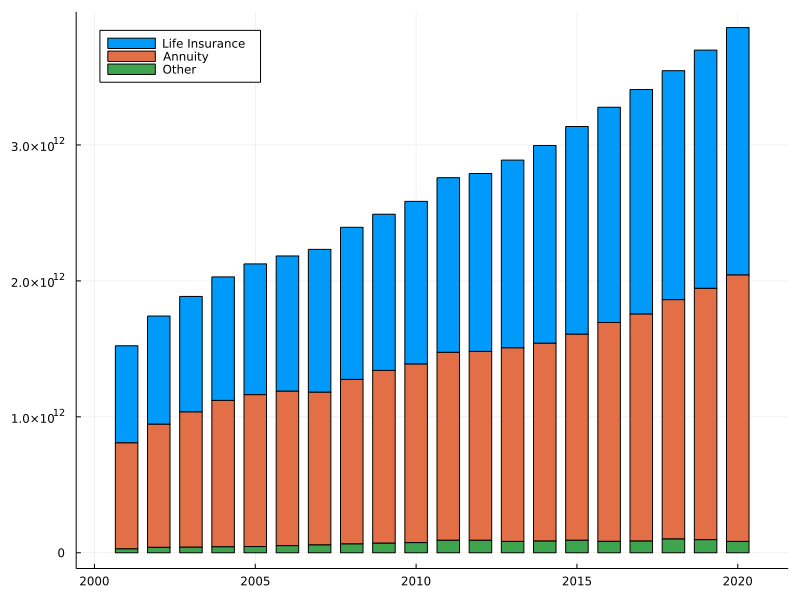

In [9]:
# reserves  
df = @combine(groupby(reserves, [:Year, :cat]), Totals = sum(:Totals))
groupedbar(@subset(df, :cat .== "Other")[:, :Year], 
    [@subset(df, :cat .== "Life Insurance")[:, :Totals] @subset(df, :cat .== "Annuity")[:, :Totals] @subset(df, :cat .== "Other")[:, :Totals]],
    bar_position = :stack, legend = :topleft, label = ["Life Insurance" "Annuity" "Other"],
    bar_width = 0.7, size = (800, 600), html_output_format=:png)

png("Reserve Evolution")
plot!()

In [10]:
df = @combine(groupby(reserves, [:Year]), Totals = sum(:Totals))

,Year,Totals
,Int64,Int64
1,2001,1522611124301
2,2002,1741368153029
3,2003,1885444740357
4,2004,2029356507176
5,2005,2124849312919
6,2006,2183423921969
7,2007,2231709946636
8,2008,2393970338735
9,2009,2490545953805


I should change the order of imputation: some LICs just write `NB` in one year but nothing in future years.

In [11]:
# reserves_notsensitive 
reserves_notsensitive = @subset(reserves, ((
    .!ismissing.(:Mort) .& 
    (coalesce.(:Mort, "") .!= "1994VA") .& 
    .!ismissing.(:Rate) .& 
    ((:Line .== 1) .| (:Line .== 2)) .& 

    (coalesce.(:Method, "") .!= "AG33") .& 
    (coalesce.(:Method, "") .!= "AG34") .& 
    (coalesce.(:Method, "") .!= "AG43") .& 
    (coalesce.(:Method, "") .!= "VM21") .& 
    (coalesce.(:Method, "") .!= "VM22") .& 
    (coalesce.(:Method, "") .!= "AtValue") .& 
    (coalesce.(:Method, "") .!= "Deposit") .& 
            
    

    .!occursin.("+NFI", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+ISL", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+VA", coalesce.(:OtherMod, "")) .&  
    .!occursin.("+MGDB", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+VA", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+VUL", coalesce.(:OtherMod, "")) .& 
    true))
)

# impute years
df = @combine(groupby(reserves_notsensitive, [:Line, :ImmDef, :Year, :Rate]), Years_Imputed = begin
    if all(ismissing, :Years)
        return missing
    else
        return sort(collect(counter(skipmissing(:Years))), by = x -> x[2], rev = true)[1][1]
        end
    end)
reserves_notsensitive = innerjoin(reserves_notsensitive, df, on = [:Line, :ImmDef, :Year, :Rate],
    matchmissing = :equal)
reserves_notsensitive[!, :Years_isImputed] .= false
@transform!(reserves_notsensitive,
    Years_isImputed = :Years_isImputed .| ismissing.(:Years),
    Years = ifelse.(ismissing.(:Years), :Years_Imputed, :Years))
reserves_notsensitive = select(reserves_notsensitive, Not(:Years_Imputed))

df = @combine(groupby(reserves_notsensitive, [:Line, :ImmDef, :Year, :Mort]), Years_Imputed = begin
    if all(ismissing, :Years)
        return missing
    else
        return sort(collect(counter(skipmissing(:Years))), by = x -> x[2], rev = true)[1][1]
        end
    end)
reserves_notsensitive = innerjoin(reserves_notsensitive, df, on = [:Line, :ImmDef, :Year, :Mort],
    matchmissing = :equal)
@transform!(reserves_notsensitive,
    Years_isImputed = :Years_isImputed .| ismissing.(:Years),
    Years = ifelse.(ismissing.(:Years), :Years_Imputed, :Years))
reserves_notsensitive = select(reserves_notsensitive, Not(:Years_Imputed))

# unpack years

reserves_notsensitive[!, :Years_mean] =   Union{Missing, Int64}[missings(nrow(reserves_notsensitive))...]
reserves_notsensitive[!, :Years_maxmin] = Union{Missing, Int64}[missings(nrow(reserves_notsensitive))...]
reserves_notsensitive = @eachrow reserves_notsensitive begin 
    if !ismissing(:Years)
        s = split(:Years, ",")
        t = split.(s, "-")
        u = sort(unique(vcat([
            length(r) == 2 ? collect(min(parse(Int64, r[1]),parse(Int64, r[2])):max(parse(Int64, r[1]),
                parse(Int64, r[2]))) : [parse(Int64, r[1])]
            for r in t]...)))
        :Years = join(u, ",")
        :Years_mean = round(Int64, mean(u))
        :Years_maxmin = maximum(u) - minimum(u)
    else
        :Years = missing
        :Years_mean = missing
        :Years_maxmin = missing
    end
end

reserves_notsensitive[!, :Years] = [ismissing(s) ? missing : parse.(Int64, split(s, ",")) 
    for s in reserves_notsensitive[!, :Years]]

reserves_notsensitive[!, :ImmDef] = coalesce.(reserves_notsensitive[:, :ImmDef], "not specified")
reserves_notsensitive[!, :Sex] = coalesce.(reserves_notsensitive[:, :Sex], "not specified")

@warn "Dropped $(nrow(@subset(reserves_notsensitive, ismissing.(:Years)))) observations because of missing (imputed) issue years!"
reserves_notsensitive = @subset(reserves_notsensitive, .!ismissing.(:Years))
dropmissing!(reserves_notsensitive, :Years)

# carry over the same key if a reserve position is subsuming the previous year's
sort!(reserves_notsensitive, [:NAIC_no, :Mort, :Sex, :AddLife, :Bday, :Rate, :Method, :ImmDef, :OtherMod, :Year, :Years])

prev_NAIC_no = 0
prev_Mort = ""
prev_Sex = ""
prev_AddLife = ""
prev_Bday = ""
prev_Rate = 0.0
prev_Method = ""
prev_ImmDef = ""
prev_OtherMod = ""
prev_Year = 0
prev_Years = Int64[]
prev_key = ""
new_keys = String[]

@showprogress for (o, row) in enumerate(eachrow(reserves_notsensitive))
    if prev_NAIC_no == row.NAIC_no && prev_Mort == row.Mort && prev_Sex == row.Sex && 
        prev_AddLife == coalesce(row.AddLife, "missing") && prev_Bday == coalesce(row.Bday, "missing") && 
        prev_Rate == row.Rate && prev_Method == coalesce(row.Method, "missing") && prev_ImmDef == row.ImmDef && 
        prev_OtherMod == coalesce(row.OtherMod, "missing") && 
        (prev_Year + 1 == row.Year || prev_Year == row.Year) && prev_Years ⊆ row.Years
        # use previous key!
        push!(new_keys, prev_key)
    else
        push!(new_keys, row.key)
        prev_key = row.key
    end
    prev_NAIC_no = row.NAIC_no; prev_Mort = row.Mort; prev_Sex = row.Sex
    prev_AddLife = coalesce(row.AddLife, "missing"); prev_Bday = coalesce(row.Bday, "missing");
    prev_Rate = row.Rate; prev_Method = coalesce(row.Method, "missing"); prev_ImmDef = row.ImmDef;
    prev_OtherMod = coalesce(row.OtherMod, "missing"); prev_Year = row.Year; prev_Years = row.Years 
end
@transform!(reserves_notsensitive, key_old = :key)
reserves_notsensitive[!, :key] = new_keys

# restore manual keys!
@transform!(reserves_notsensitive, key = ifelse.(.!ismissing.(:key_manual), coalesce.(:key_manual, ""), :key))

sort!(reserves_notsensitive, [:key, :Year])
reserves_notsensitive = @combine(groupby(reserves_notsensitive, [:key, :Year]), 
    NAIC_no = first(:NAIC_no), Line = first(:Line), ValuationStandard = first(:ValuationStandard), 
    OtherMod = first(:OtherMod), Sex = first(:Sex), AddLife = first(:AddLife), 
    Bday = first(:Bday), Method = first(:Method), ImmDef = first(:ImmDef), 
    Totals = sum(:Totals), Mort = first(:Mort), Rate = first(:Rate), 
    Rate2 = first(:Rate2), Valuation_orig = first(:Valuation_orig), 
    Years = [sort(unique(vcat(:Years...)))], 
    isNB = first(:isNB), Years_isImputed = first(:Years_isImputed), Years_mean = first(:Years_mean), 
    Years_maxmin = first(:Years_maxmin), key_old = first(:key_old),
    key_manual = first(:key_manual))

# reserves_notsensitive[!, :LineCat] = categorical(reserves_notsensitive[:, :Line])

reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@subset(
            @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
            :horizon .== 7)[:, [:year, :rate]], :rate => :rate_issue), 
    on = [:Years_mean => :year], matchmissing = :equal)
reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@subset(
            @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
            :horizon .== 7)[:, [:year, :rate]], :rate => :rate_current), 
    on = [:Year => :year], matchmissing = :equal)
reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@transform(@subset(
            @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
            :horizon .== 7), year = :year .+ 1)[:, [:year, :rate]], :rate => :rate_prev_year), 
    on = [:Year => :year], matchmissing = :equal)
reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@subset(
            @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
            :horizon .== 7)[:, [:year, :rate]], :rate => :rate_HQM_issue), 
    on = [:Years_mean => :year], matchmissing = :equal)
reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@subset(
            @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
            :horizon .== 10)[:, [:year, :rate]], :rate => :rate_HQM_current), 
    on = [:Year => :year], matchmissing = :equal)
reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@transform(@subset(
            @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
            :horizon .== 10), year = :year .+ 1)[:, [:year, :rate]], :rate => :rate_HQM_prev_year), 
    on = [:Year => :year], matchmissing = :equal)

# reserves_notsensitive = innerjoin(reserves_notsensitive, rename(@where(
#             @combine(groupby(rate_HQM, [:year, :horizon]), rate = last(:rate)), 
#             :horizon .== 10)[:, [:year, :rate]], :rate => :rate_issue), 
#     on = [:Years_mean => :year], matchmissing = :equal)
# reserves_notsensitive = innerjoin(reserves_notsensitive, rename(@where(
#             @combine(groupby(rate_HQM, [:year, :horizon]), rate = last(:rate)), 
#             :horizon .== 10)[:, [:year, :rate]], :rate => :rate_current), 
#     on = [:Year => :year], matchmissing = :equal)

# selection = @where(@combine(groupby(reserves_est, :key), n = length(:key)), :n .>= 5)
# reserves_est = innerjoin(reserves_est, selection, on = :key)

reserves_notsensitive[!, :Years_since] = Float64.(reserves_notsensitive[:, :Year] .- reserves_notsensitive[:, :Years_mean])
reserves_notsensitive[!, :rate_diff_issue] = (reserves_notsensitive[:, :rate_current] .- 
    reserves_notsensitive[:, :rate_issue]) ./ 100
reserves_notsensitive[!, :rate_diff_prev] = (reserves_notsensitive[:, :rate_current] .- 
    reserves_notsensitive[:, :rate_prev_year]) ./ 100
reserves_notsensitive[!, :rate_HQM_diff_issue] = (reserves_notsensitive[:, :rate_HQM_current] .- 
    reserves_notsensitive[:, :rate_HQM_issue]) ./ 100
reserves_notsensitive[!, :rate_HQM_diff_prev] = (reserves_notsensitive[:, :rate_HQM_current] .- 
    reserves_notsensitive[:, :rate_HQM_prev_year]) ./ 100

reserves_notsensitive = leftjoin(reserves_notsensitive, 
    rename(@transform(reserves_notsensitive, Year  = :Year .+ 1)[:, [:key, :Year , :Totals]], 
        [:Totals => :Totals_prev]),
    on = [:key, :Year])

reserves_notsensitive[!, :p] = (1 .+ reserves_notsensitive[:, :Rate] ./ 100) .- 
    reserves_notsensitive[!, :Totals] ./ reserves_notsensitive[:, :Totals_prev]
reserves_notsensitive[!, :V_ratio] = reserves_notsensitive[!, :Totals] ./ reserves_notsensitive[:, :Totals_prev] .- 1
reserves_notsensitive[!, :rate_issue] .= reserves_notsensitive[:, :rate_issue] ./ 100
reserves_notsensitive[!, :rate_current] .= reserves_notsensitive[:, :rate_current] ./ 100

# there cannot be reserves for a future year
reserves_notsensitive[!, :Years] = [sort(unique(min.(yrs, y))) 
    for (yrs, y) in zip(reserves_notsensitive[:, :Years], reserves_notsensitive[:, :Year])]

sort!(reserves_notsensitive, [:key, :Year])

# Years must be cumulative over time!
cum_yrs_df = @combine(groupby(reserves_notsensitive, :key), 
    Year = :Year,
    Years = [sort(unique(vcat(:Years[1:i]...))) for i in 1:length(:Years)])
# cum_yrs_df[!, :Years] = [sort(unique(vcat(s...))) for s in cum_yrs_df[!, :Years]]
@assert all((reserves_notsensitive[:, :Year] .== cum_yrs_df[:, :Year]) .& (reserves_notsensitive[:, :key] .== cum_yrs_df[:, :key]))
reserves_notsensitive[!, :Years] = cum_yrs_df[!, :Years]

cum_yrs_df = @combine(groupby(reserves_notsensitive, :key), 
    Year = :Year,
    Years = [sort(unique(vcat(:Years...)))[sort(unique(vcat(:Years...))) .<= i] for i in :Year])
@assert all((reserves_notsensitive[:, :Year] .== cum_yrs_df[:, :Year]) .& (reserves_notsensitive[:, :key] .== cum_yrs_df[:, :key]))
reserves_notsensitive[!, :Years] = cum_yrs_df[!, :Years]

sort!(reserves_notsensitive, [:key, :Year]);

# collapse two Rates is they are close:
@transform!(reserves_notsensitive, 
    Rate = ifelse.(ismissing.(:Rate2), :Rate, ifelse.(
            abs.(:Rate .- coalesce.(:Rate2, 999)) .> 0.25, :Rate, (:Rate .+ coalesce.(:Rate2, 999)) ./ 2)),
    Rate2 = ifelse.(ismissing.(:Rate2), :Rate2, ifelse.(
            abs.(:Rate .- coalesce.(:Rate2, 999)) .> 0.25, :Rate2, missing))
    )

# collapse many issue years if they are in the past without any observations about their issuance
col_df = @combine(groupby(reserves_notsensitive, :key), 
    first_obs_year = minimum(:Year),
    issue_years = [sort(unique(vcat(:Years...)))],
)
keep_years = Vector{Int64}[]
for (o, row) in enumerate(eachrow(col_df))
    
    match_years = vcat(row.first_obs_year .- vcat(0, cumsum(collect(5:13))))
        
    old = row.issue_years[row.issue_years .< row.first_obs_year]
#     if length(old) > 0
#         old = unique([old[argmin(abs.(old .- m))] for m in match_years])
#     end

# less radical
#     if row.first_obs_year - maximum(row.issue_years) > 30
#         old = [old[end]]
#     elseif row.first_obs_year - maximum(row.issue_years) > 20
#         old = unique([old[1], old[end]])
#     end    
    
    # radical: only keep last issue year 
    if length(old) > 0
        old = [old[end]]
    end
    
    new = row.issue_years[row.issue_years .>= row.first_obs_year]
    
    push!(keep_years, sort(unique(vcat(old, new))))
    
end
col_df[!, :keep_years] = keep_years
reserves_notsensitive = innerjoin(reserves_notsensitive, select(col_df, [:key, :keep_years]), on = [:key, ])


@transform!(reserves_notsensitive, Years = intersect.(:Years, :keep_years))

# @transform!(reserves_notsensitive, 
#     Years_maxmin = maximum.(:Years) - minimum.(:Years),
#     Years_mean = round.(Int64, mean.(:Years)),
# )
# reserves_notsensitive[!, :Years_since] = Float64.(reserves_notsensitive[:, :Year] .- reserves_notsensitive[:, :Years_mean])

@transform!(reserves_notsensitive, Decade = (:Year .- 2001) ./ 10)

sort!(reserves_notsensitive, [:key, :Year]);

┌ Warning: Dropped 5 observations because of missing (imputed) issue years!
└ @ Main In[11]:85
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04:41


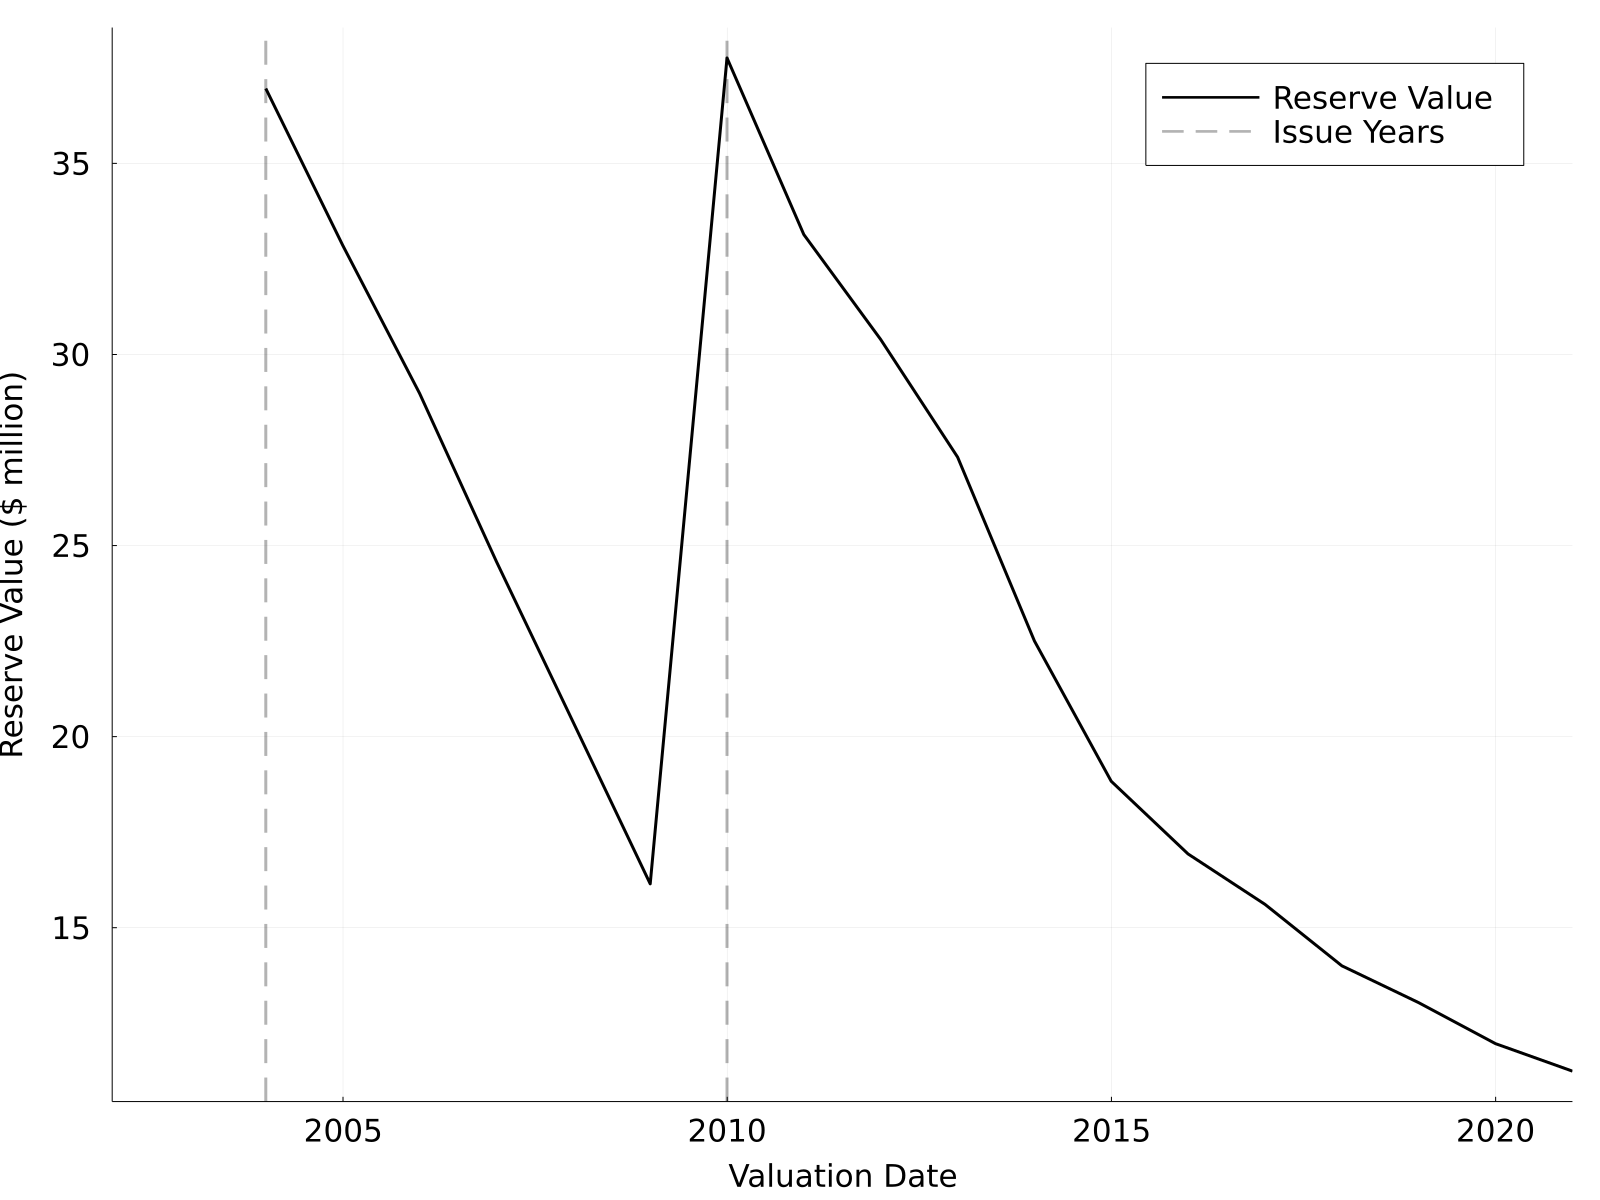

In [12]:
# example evolution
@df @subset(reserves_notsensitive, :key .== "26a125514922004d4b6ba98437adffe948d80660") plot(Date.(:Year, 12,31), :Totals ./ 1e6,
    width = 3, size = (800, 600), html_output_format=:png, legend = :topright, 
    ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "Reserve Value", c = :black,    
)

vline!([Date.(2003, 12,31)], c = :black, alpha = 0.3, width = 3, linestyle = :dash, label = "Issue Years")
vline!([Date.(2009, 12,31)], c = :black, alpha = 0.3, width = 3, linestyle = :dash, label = "")

plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

plot!(size = (2*800, 2*600),margin = 5mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)

png("Reserve Value additions big")

# png("Reserve Value additions")
plot!()


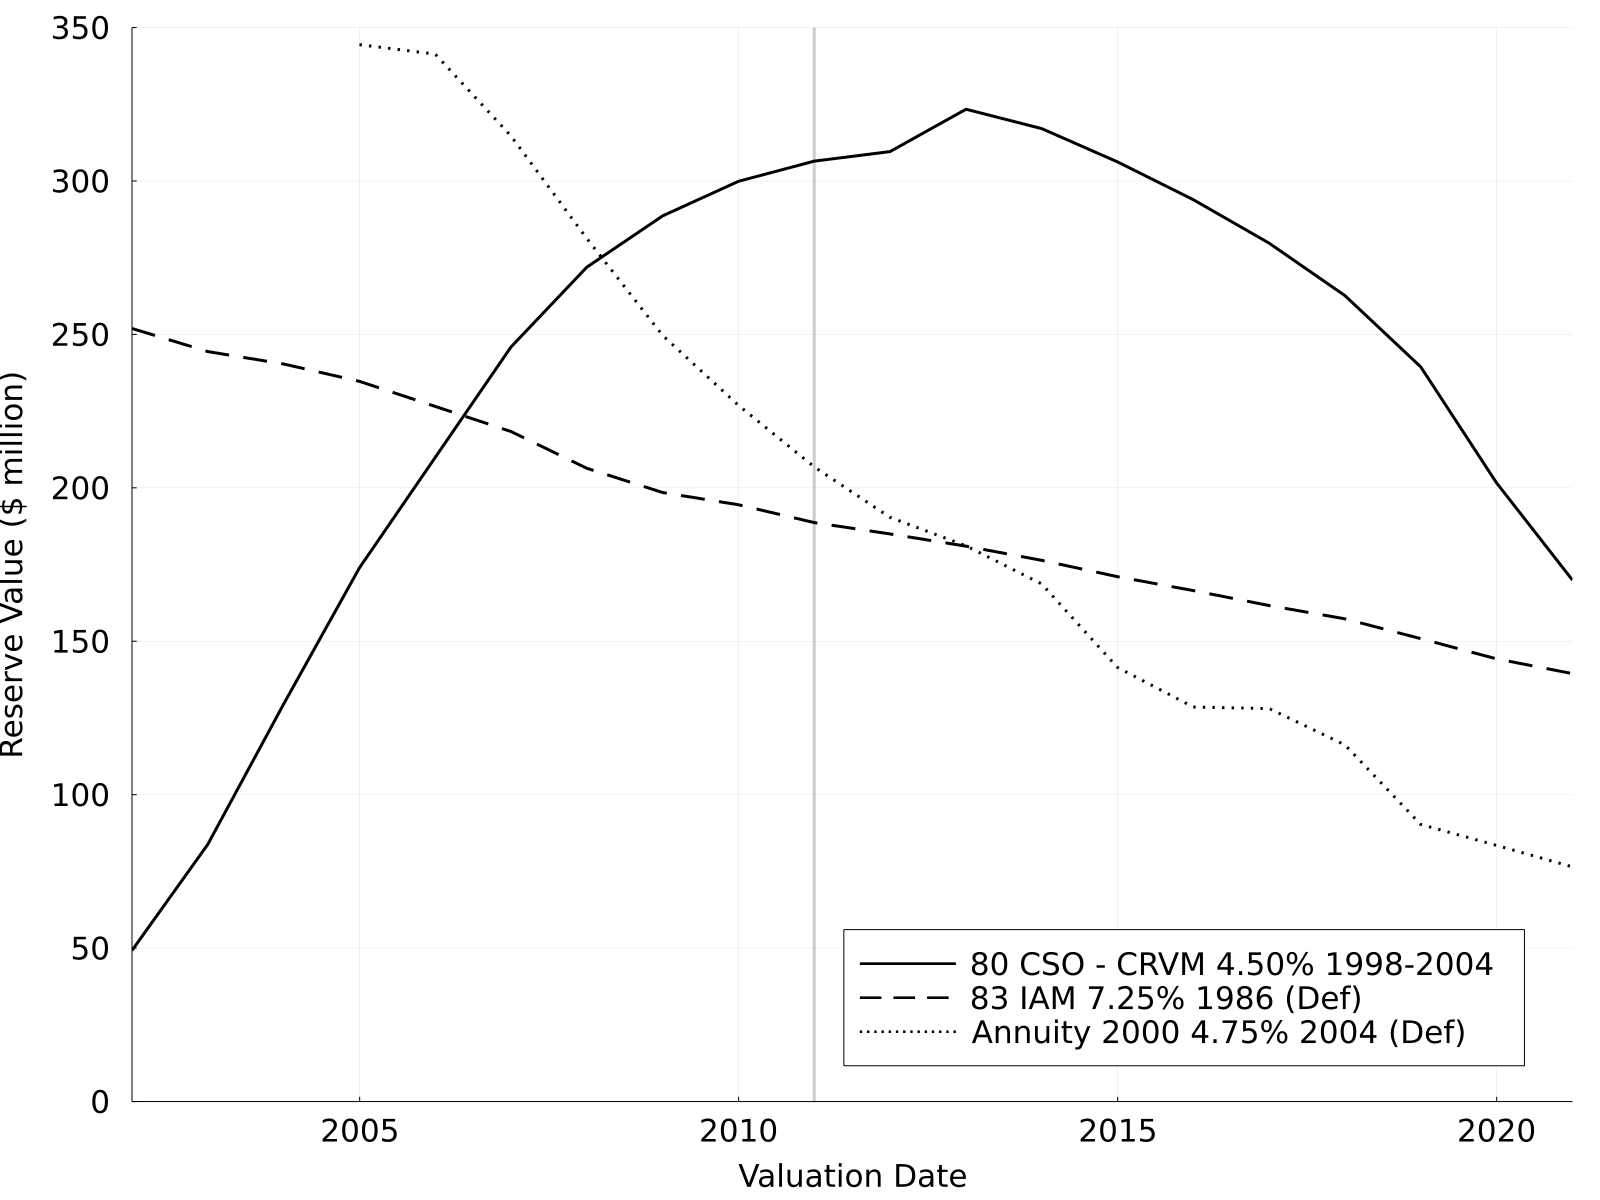

In [13]:
# example evolution
@df sort(@subset(reserves_notsensitive, ((:key_manual .== "272bb65bc18c4cbf19c8747fd67c2cb78ac90d0e"))), :Year) plot(Date.(:Year, 12,31), :Totals ./ 1e6,
    width = 3, size = (800, 600), html_output_format=:png, legend = :topright, linestyle = :solid,
    ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "80 CSO - CRVM 4.50% 1998-2004", c = :black,
)

@df sort(@subset(reserves_notsensitive, (:key .== "e018624f1f7238da5fa402c2bd29f4ec50a29570") .| 
        (:key .== "769590dc6fc72301a637adcec7f1101a015b1a53")), :Year) plot!(Date.(:Year, 12,31), :Totals ./ 1e6,
    width = 3, size = (800, 600), html_output_format=:png, legend = :topright, linestyle = :dash, 
    ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "83 IAM 7.25% 1986 (Def)", c = :black,
)

# @df sort(@subset(reserves_notsensitive, ((:key .== "2a5e5a90bc653245cb0ee704c41ab9af5e9aefec") .| 
#         (:key .== "8ffafc595b85ea229b8313e81712bd925ac1e74f"))), :Year) plot!(Date.(:Year, 12,31), :Totals ./ 1e6,
#     width = 3, size = (800, 600), html_output_format=:png, legend = :topright, linestyle = :dot,
#     ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "Annuity 2000 4.75% 2004 (Def)", c = :black,
# )

@df sort(@subset(reserves_notsensitive, ((:key .== "0307228373eb740a37a479c64f22b7e2102af63f") .| 
        (:key .== "5a3498c56c3246c86f9c9857d02e4be96c543754") .| 
        (:key .== "bde4f5d4f6dcfe044e6362af8e4e61db68a481ae") .|  
        (:key .== "50ad1841e8775a3e7b787b6d5f8c719835e940e6") .|
        (:key .== "85c101f057cadd22b37dcc1ab360f403a4259c66"))), :Year) plot!(Date.(:Year, 12,31), :Totals ./ 1e6,
    width = 3, size = (800, 600), html_output_format=:png, legend = :bottomright, linestyle = :dot,
    ylim = (0,350),
    ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "Annuity 2000 4.75% 2004 (Def)", c = :black,
)

vline!([Date(2010,12,31)], c = :black, alpha = 0.2, width = 3, linestyle = :solid, label = "")

plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

plot!(size = (2*800, 2*600),margin = 5mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)

png("Reserve Value evolution 2 big")
plot!()


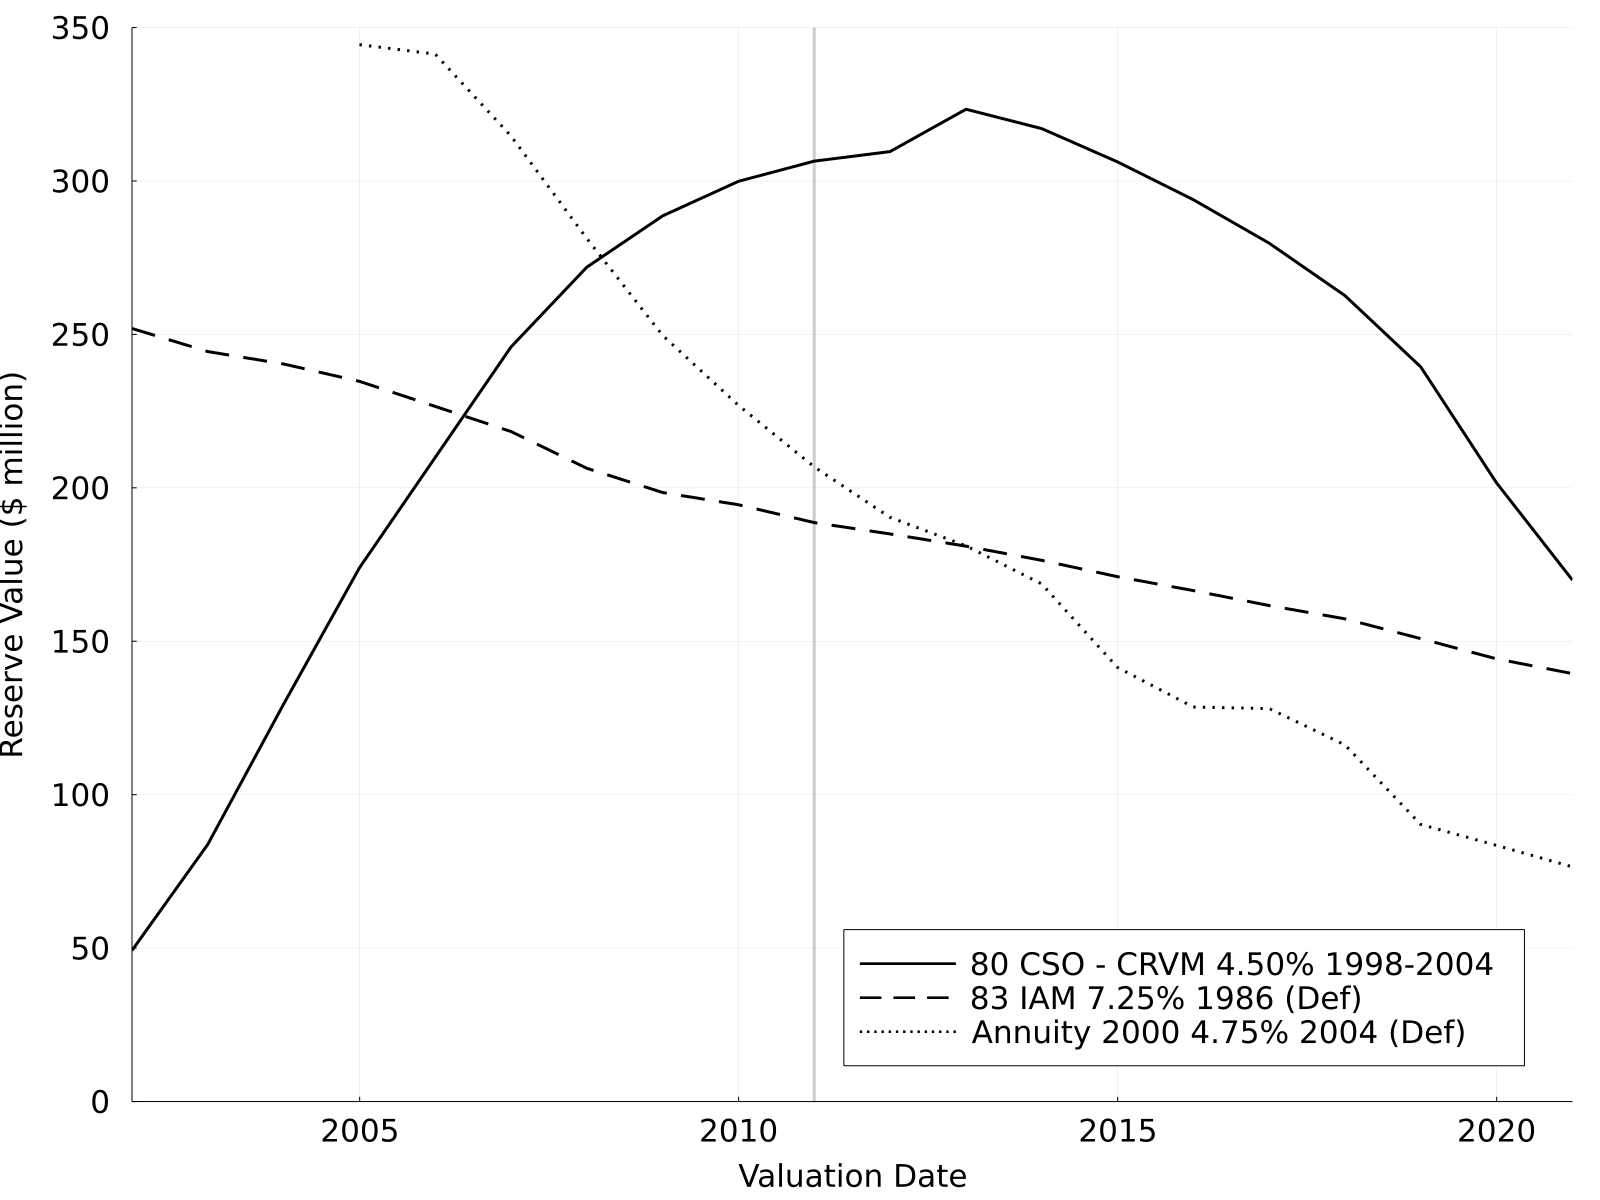

In [14]:
# example evolution
@df sort(@subset(reserves_notsensitive, ((:key_manual .== "272bb65bc18c4cbf19c8747fd67c2cb78ac90d0e"))), :Year) plot(Date.(:Year, 12,31), :Totals ./ 1e6,
    width = 3, size = (800, 600), html_output_format=:png, legend = :topright, linestyle = :solid,
    ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "80 CSO - CRVM 4.50% 1998-2004", c = :black,
)

@df sort(@subset(reserves_notsensitive, (:key .== "e018624f1f7238da5fa402c2bd29f4ec50a29570") .| 
        (:key .== "769590dc6fc72301a637adcec7f1101a015b1a53")), :Year) plot!(Date.(:Year, 12,31), :Totals ./ 1e6,
    width = 3, size = (800, 600), html_output_format=:png, legend = :topright, linestyle = :dash, 
    ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "83 IAM 7.25% 1986 (Def)", c = :black,
)

# @df sort(@subset(reserves_notsensitive, ((:key .== "2a5e5a90bc653245cb0ee704c41ab9af5e9aefec") .| 
#         (:key .== "8ffafc595b85ea229b8313e81712bd925ac1e74f"))), :Year) plot!(Date.(:Year, 12,31), :Totals ./ 1e6,
#     width = 3, size = (800, 600), html_output_format=:png, legend = :topright, linestyle = :dot,
#     ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "Annuity 2000 4.75% 2004 (Def)", c = :black,
# )

@df sort(@subset(reserves_notsensitive, ((:key .== "0307228373eb740a37a479c64f22b7e2102af63f") .| 
        (:key .== "5a3498c56c3246c86f9c9857d02e4be96c543754") .| 
        (:key .== "bde4f5d4f6dcfe044e6362af8e4e61db68a481ae") .|  
        (:key .== "50ad1841e8775a3e7b787b6d5f8c719835e940e6") .|
        (:key .== "85c101f057cadd22b37dcc1ab360f403a4259c66"))), :Year) plot!(Date.(:Year, 12,31), :Totals ./ 1e6,
    width = 3, size = (800, 600), html_output_format=:png, legend = :bottomright, linestyle = :dot,
    ylim = (0,350),
    ylab = "Reserve Value (\$ million)", xlab = "Valuation Date", label = "Annuity 2000 4.75% 2004 (Def)", c = :black,
)

vline!([Date(2010,12,31)], c = :black, alpha = 0.2, width = 3, linestyle = :solid, label = "")

plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

plot!(size = (2*800, 2*600),margin = 5mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)

png("Reserve Value evolution 2 big")
plot!()


In [15]:
# reserves_sensitive
reserves_sensitive = @subset(reserves, .!((
    .!ismissing.(:Mort) .& 
    (coalesce.(:Mort, "") .!= "1994VA") .& 
    .!ismissing.(:Rate) .& 
    ((:Line .== 1) .| (:Line .== 2)) .& 

    (coalesce.(:Method, "") .!= "AG33") .& 
    (coalesce.(:Method, "") .!= "AG34") .& 
    (coalesce.(:Method, "") .!= "AG43") .& 
    (coalesce.(:Method, "") .!= "VM21") .& 
    (coalesce.(:Method, "") .!= "VM22") .& 
    (coalesce.(:Method, "") .!= "AtValue") .& 
    (coalesce.(:Method, "") .!= "Deposit") .& 

    .!occursin.("+NFI", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+ISL", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+VA", coalesce.(:OtherMod, "")) .&  
    .!occursin.("+MGDB", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+VA", coalesce.(:OtherMod, "")) .& 
    .!occursin.("+VUL", coalesce.(:OtherMod, "")) .& 
    true))
);

In [16]:
# # split sensitive or nonsensitive
# reserves_notsensitive = @where(reserves, ((
#     .!ismissing.(:Mort) .& 
#     .!ismissing.(:Rate) .& 
#     ((:Line .== 1) .| (:Line .== 2)) .& 

#     (coalesce.(:Method, "") .!= "AG33") .& 
#     (coalesce.(:Method, "") .!= "AG34") .& 
#     (coalesce.(:Method, "") .!= "AG43") .& 
#     (coalesce.(:Method, "") .!= "VM21") .& 
#     (coalesce.(:Method, "") .!= "VM22") .& 
#     (coalesce.(:Method, "") .!= "AtValue") .& 
#     (coalesce.(:Method, "") .!= "Deposit") .& 

#     .!occursin.("+ISL", coalesce.(:OtherMod, "")) .& 
#     .!occursin.("+VA", coalesce.(:OtherMod, "")) .&  
#     .!occursin.("+MGDB", coalesce.(:OtherMod, "")) .& 
#     .!occursin.("+VA", coalesce.(:OtherMod, "")) .& 
#     .!occursin.("+VUL", coalesce.(:OtherMod, "")) .& 
#     true))
# )

# # impute years

# df = @combine(groupby(reserves_notsensitive, [:Line, :ImmDef, :Year, :Rate]), Years_Imputed = begin
#     if all(ismissing, :Years)
#         return missing
#     else
#         return sort(collect(counter(skipmissing(:Years))), by = x -> x[2], rev = true)[1][1]
#         end
#     end)
# reserves_notsensitive = innerjoin(reserves_notsensitive, df, on = [:Line, :ImmDef, :Year, :Rate],
#     matchmissing = :equal)
# reserves_notsensitive[!, :Years_isImputed] .= false
# @transform!(reserves_notsensitive,
#     Years_isImputed = :Years_isImputed .| ismissing.(:Years),
#     Years = ifelse.(ismissing.(:Years), :Years_Imputed, :Years))
# reserves_notsensitive = select(reserves_notsensitive, Not(:Years_Imputed))

# df = @combine(groupby(reserves_notsensitive, [:Line, :ImmDef, :Year, :Mort]), Years_Imputed = begin
#     if all(ismissing, :Years)
#         return missing
#     else
#         return sort(collect(counter(skipmissing(:Years))), by = x -> x[2], rev = true)[1][1]
#         end
#     end)
# reserves_notsensitive = innerjoin(reserves_notsensitive, df, on = [:Line, :ImmDef, :Year, :Mort],
#     matchmissing = :equal)
# @transform!(reserves_notsensitive,
#     Years_isImputed = :Years_isImputed .| ismissing.(:Years),
#     Years = ifelse.(ismissing.(:Years), :Years_Imputed, :Years))
# reserves_notsensitive = select(reserves_notsensitive, Not(:Years_Imputed))

# # unpack years

# reserves_notsensitive[!, :Years_mean] =   Union{Missing, Int64}[missings(nrow(reserves_notsensitive))...]
# reserves_notsensitive[!, :Years_maxmin] = Union{Missing, Int64}[missings(nrow(reserves_notsensitive))...]
# reserves_notsensitive = @eachrow reserves_notsensitive begin 
#     if !ismissing(:Years)
#         s = split(:Years, ",")
#         t = split.(s, "-")
#         u = sort(unique(vcat([
#             length(r) == 2 ? collect(min(parse(Int64, r[1]),parse(Int64, r[2])):max(parse(Int64, r[1]),
#                 parse(Int64, r[2]))) : [parse(Int64, r[1])]
#             for r in t]...)))
#         :Years = join(u, ",")
#         :Years_mean = round(Int64, mean(u))
#         :Years_maxmin = maximum(u) - minimum(u)
#     else
#         :Years = missing
#         :Years_mean = missing
#         :Years_maxmin = missing
#     end
# end

# reserves_notsensitive[!, :ImmDef] = coalesce.(reserves_notsensitive[:, :ImmDef], "not specified")
# reserves_notsensitive[!, :Sex] = coalesce.(reserves_notsensitive[:, :Sex], "not specified")

# @warn "Dropped $(nrow(@where(reserves_notsensitive, ismissing.(:Years)))) observations because of missing (imputed) issue years!"
# reserves_notsensitive = @where(reserves_notsensitive, .!ismissing.(:Years))

# reserves_notsensitive[!, :LineCat] = categorical(reserves_notsensitive[:, :Line])

# reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@where(
#             @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
#             :horizon .== 7)[:, [:year, :rate]], :rate => :rate_issue), 
#     on = [:Years_mean => :year], matchmissing = :equal)
# reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@where(
#             @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
#             :horizon .== 7)[:, [:year, :rate]], :rate => :rate_current), 
#     on = [:Year => :year], matchmissing = :equal)
# reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@transform(@where(
#             @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
#             :horizon .== 7), year = :year .+ 1)[:, [:year, :rate]], :rate => :rate_prev_year), 
#     on = [:Year => :year], matchmissing = :equal)

# reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@where(
#             @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
#             :horizon .== 7)[:, [:year, :rate]], :rate => :rate_HQM_issue), 
#     on = [:Years_mean => :year], matchmissing = :equal)
# reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@where(
#             @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
#             :horizon .== 10)[:, [:year, :rate]], :rate => :rate_HQM_current), 
#     on = [:Year => :year], matchmissing = :equal)
# reserves_notsensitive = leftjoin(reserves_notsensitive, rename(@transform(@where(
#             @combine(groupby(rate_treasury, [:year, :horizon]), rate = :rate[min(length(:rate), 12)]), 
#             :horizon .== 10), year = :year .+ 1)[:, [:year, :rate]], :rate => :rate_HQM_prev_year), 
#     on = [:Year => :year], matchmissing = :equal)

# # reserves_notsensitive = innerjoin(reserves_notsensitive, rename(@where(
# #             @combine(groupby(rate_HQM, [:year, :horizon]), rate = last(:rate)), 
# #             :horizon .== 10)[:, [:year, :rate]], :rate => :rate_issue), 
# #     on = [:Years_mean => :year], matchmissing = :equal)
# # reserves_notsensitive = innerjoin(reserves_notsensitive, rename(@where(
# #             @combine(groupby(rate_HQM, [:year, :horizon]), rate = last(:rate)), 
# #             :horizon .== 10)[:, [:year, :rate]], :rate => :rate_current), 
# #     on = [:Year => :year], matchmissing = :equal)

# # selection = @where(@combine(groupby(reserves_est, :key), n = length(:key)), :n .>= 5)
# # reserves_est = innerjoin(reserves_est, selection, on = :key)

# reserves_notsensitive[!, :Years_since] = Float64.(reserves_notsensitive[:, :Year] .- reserves_notsensitive[:, :Years_mean])
# reserves_notsensitive[!, :rate_diff_issue] = (reserves_notsensitive[:, :rate_current] .- 
#     reserves_notsensitive[:, :rate_issue]) ./ 100
# reserves_notsensitive[!, :rate_diff_prev] = (reserves_notsensitive[:, :rate_current] .- 
#     reserves_notsensitive[:, :rate_prev_year]) ./ 100
# reserves_notsensitive[!, :rate_HQM_diff_issue] = (reserves_notsensitive[:, :rate_HQM_current] .- 
#     reserves_notsensitive[:, :rate_HQM_issue]) ./ 100
# reserves_notsensitive[!, :rate_HQM_diff_prev] = (reserves_notsensitive[:, :rate_HQM_current] .- 
#     reserves_notsensitive[:, :rate_HQM_prev_year]) ./ 100

# reserves_notsensitive = leftjoin(reserves_notsensitive, 
#     rename(@transform(reserves_notsensitive, Year  = :Year .+ 1)[:, 
#             [:key, :Year , :Totals]], 
#         [:Totals => :Totals_prev, ]),
#     on = [:key, :Year ])

# reserves_notsensitive[!, :p] = (1 .+ reserves_notsensitive[:, :Rate] ./ 100) .- 
#     reserves_notsensitive[!, :Totals] ./ reserves_notsensitive[:, :Totals_prev]
# reserves_notsensitive[!, :V_ratio] = reserves_notsensitive[!, :Totals] ./ reserves_notsensitive[:, :Totals_prev] .- 1
# reserves_notsensitive[!, :rate_issue] .= reserves_notsensitive[:, :rate_issue] ./ 100
# reserves_notsensitive[!, :rate_current] .= reserves_notsensitive[:, :rate_current] ./ 100

# reserves_sensitive = @where(reserves, .!((
#     .!ismissing.(:Mort) .& 
#     .!ismissing.(:Rate) .& 
#     ((:Line .== 1) .| (:Line .== 2)) .& 

#     (coalesce.(:Method, "") .!= "AG33") .& 
#     (coalesce.(:Method, "") .!= "AG34") .& 
#     (coalesce.(:Method, "") .!= "AG43") .& 
#     (coalesce.(:Method, "") .!= "VM21") .& 
#     (coalesce.(:Method, "") .!= "VM22") .& 
#     (coalesce.(:Method, "") .!= "AtValue") .& 
#     (coalesce.(:Method, "") .!= "Deposit") .& 

#     .!occursin.("+ISL", coalesce.(:OtherMod, "")) .& 
#     .!occursin.("+VA", coalesce.(:OtherMod, "")) .&  
#     .!occursin.("+MGDB", coalesce.(:OtherMod, "")) .& 
#     .!occursin.("+VA", coalesce.(:OtherMod, "")) .& 
#     .!occursin.("+VUL", coalesce.(:OtherMod, "")) .& 
#     true))
# );

In [17]:
# @transform!(reserves_notsensitive, Decade = (:Year .- 2001) ./ 10);
# @transform!(reserves_notsensitive, elapsed = :Years_since);

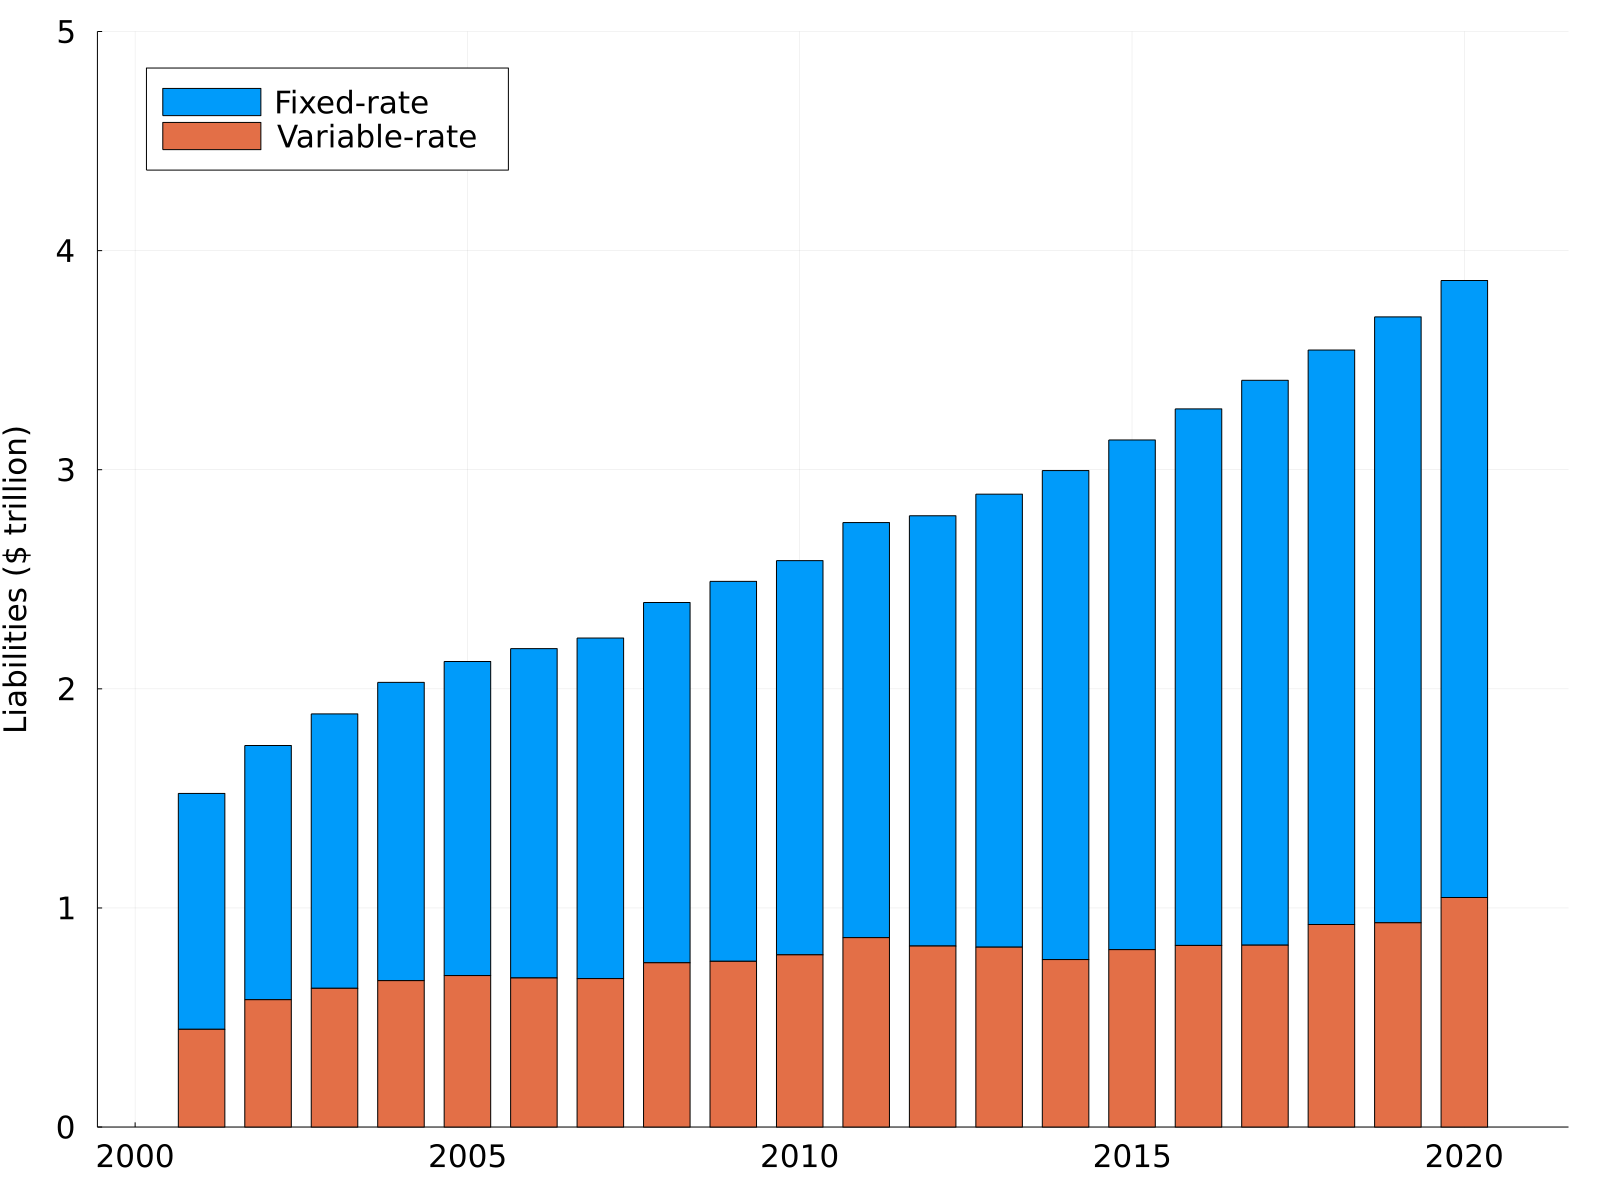

In [18]:
# 
df1 = @combine(groupby(reserves_notsensitive, [:Year]), Totals = sum(:Totals))
df2 = @combine(groupby(reserves_sensitive, [:Year]), Totals = sum(:Totals))
groupedbar(df1[:, :Year], 
    [df1[:, :Totals] ./ 1e12 df2[:, :Totals] ./ 1e12],
    bar_position = :stack, legend = :topleft, label = ["Fixed-rate" "Variable-rate"],
    size = (800, 600), html_output_format=:png, bar_width = 0.7, ylab = "Liabilities (\$ trillion)", ylim = (0, 5))

png("Reserve Evolution fixed-variable")
plot!()


plot!(size = (2*800, 2*600),margin = 6mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Reserve Evolution fixed-variable big")

plot!()

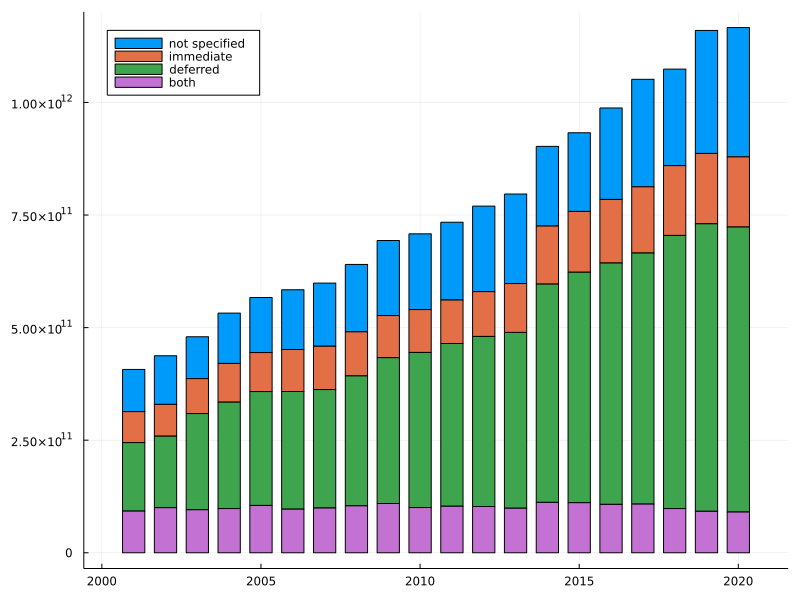

In [19]:
# Annuity ImmDef 
df = sort(@combine(groupby(@subset(reserves_notsensitive, :Line .== 2), [:Year, :ImmDef]), Totals = sum(:Totals)), :Year)
groupedbar(@subset(df, :ImmDef .== "not specified")[:, :Year], 
    [@subset(df, :ImmDef .== "not specified")[:, :Totals] @subset(df, :ImmDef .== "immediate")[:, :Totals] @subset(df, :ImmDef .== "deferred")[:, :Totals] @subset(df, :ImmDef .== "both")[:, :Totals]],
    bar_position = :stack, legend = :topleft, label = ["not specified" "immediate" "deferred" "both"],
    size = (800, 600), html_output_format=:png, bar_width = 0.7)

png("ImmDef Evolution")
plot!()

# Simplest Model

In [20]:
# # select data
# max_rang = 80
# max_no_issues = 5

# reserves_est = select(@where(reserves_notsensitive, 
#     (
# #         ismissing.(:Rate2) .& 
# #         ismissing.(:ValuationStandard) .&
# #         (coalesce.(:Totals_prev, 0) .> 0)
#         (-1.2 .< coalesce.(:p, -9999) .< 1.2) .& 
#         .!:Years_isImputed
# #             true
#     )), 
#     [:NAIC_no, :key, :Year, :Totals, :Totals_prev, :Years, 
#         :Line, :Mort, :Rate, :Sex, :AddLife, :Bday, :Method, :ImmDef, :OtherMod, 
#         :rate_diff_issue, :p
#         ])

# reserves_est = reserves_est[[y ∈ 2004:2019 for y in reserves_est[:, :Year]], :]
# # print("$(nrow(reserves_est)) observations remain!\n")

# # add a final observation with zero Totals, when the NAIC_no does report in the next year but the position is gone
# lasts = @combine(groupby(reserves_est, :key), 
#     NAIC_no = last(:NAIC_no), key = last(:key), Line = last(:Line), Mort = last(:Mort), Rate = last(:Rate), 
#     Sex = last(:Sex), AddLife = last(:AddLife), Bday = last(:Bday), Method = last(:Method), 
#     ImmDef = last(:ImmDef), OtherMod = last(:OtherMod), Year = last(:Year), Years = [last(:Years)],
#     Totals = last(:Totals), Totals_prev = last(:Totals_prev), rate_diff_issue = last(:rate_diff_issue),
#     p = last(:p)
# )
# lasts = @where(lasts, :Totals .> 0)
# @transform!(lasts, Totals_prev = :Totals, Year = :Year .+ 1, Totals = 0)
# lasts = select(
#     innerjoin(lasts, @combine(groupby(reserves_est, [:Year, :NAIC_no]), n = 1), on = [:NAIC_no, :Year]),
#     Not(:n))
# reserves_est = vcat(reserves_est, lasts)
# sort!(reserves_notsensitive, [:key, :Year]);

# @transform!(reserves_est, obs_res_flow = -:Totals .+ (1 .+ :Rate ./ 100) .* :Totals_prev)
# @transform!(reserves_est, obs_res_flow_norm = :obs_res_flow ./ :Totals_prev)

# @transform!(reserves_est, has_new_issue = :Year .∈ :Years)
# print("Deleted $(nrow(@where(reserves_est, :has_new_issue))) observations with an issuance!\n")
# reserves_est = @where(reserves_est, .!:has_new_issue)
# # print("$(nrow(reserves_est)) observations remain!\n")

# # individual observations
# print("Deleted $(nrow(@where(reserves_est, (:obs_res_flow_norm .* .!:has_new_issue) .< -0.3))) observations with large additions outside of an issuance year!\n")
# reserves_est = @where(reserves_est, (:obs_res_flow_norm .* .!:has_new_issue) .>= -0.3)
# # print("$(nrow(reserves_est)) observations remain!\n")
# print("Deleted $(nrow(@where(reserves_est, (:Line .== 2) .& (:obs_res_flow_norm .* .!:has_new_issue .< -0.03)))) annuity observations with some additions outside of an issuance year!\n")
# reserves_est = @where(reserves_est, .!((:Line .== 2) .& (:obs_res_flow_norm .* .!:has_new_issue .< -0.03)))
# # print("$(nrow(reserves_est)) observations remain!\n")

# # keys
# # @transform!(reserves_est, has_new_issue = :Year .∈ :Years)
# # del_df = @where(@combine(groupby(reserves_est, :key), del = any((:obs_res_flow_norm .* .!:has_new_issue) .< -0.3)), :del)
# # reserves_est = antijoin(reserves_est, del_df, on = [:key])
# # print("Deleted $(nrow(del_df)) keys with large additions outside of an issuance year!\n")

# # del_df = @where(@combine(groupby(@where(reserves_est, :Line .== 2), :key), del = any((:obs_res_flow_norm .* .!:has_new_issue) .< -0.01)), :del)
# # reserves_est = antijoin(reserves_est, del_df, on = [:key])
# # print("Deleted $(nrow(del_df)) annuity keys with some additions outside of an issuance year!\n")
# # reserves_est = select(reserves_est, Not(:has_new_issue))

# # # delete observation with erratic behaviour in a single year.
# # del_df = sort(@combine(groupby(reserves_est, :key),
# #     Year = :Year[ # select pairs of observations that make no sense:
# #             # second of the pair
# #             vcat(false, [(:Year[i-1] + 1 == :Year[i]) & (abs(:obs_res_flow_norm[i-1]) > 0.5) & 
# #                     (abs(:obs_res_flow_norm[i]) > 0.5) & (:obs_res_flow_norm[i] / :obs_res_flow_norm[i-1] < 0) 
# #                 # both adjacent observations have large movement, but in the opposite direction
# #                 for i in 2:length(:Year)]) .|
# #             # first of the pair
# #             vcat([(:Year[i] + 1 == :Year[i+1]) & (abs(:obs_res_flow_norm[i+1]) > 0.5) & 
# #                     (abs(:obs_res_flow_norm[i]) > 0.5) & (:obs_res_flow_norm[i] / :obs_res_flow_norm[i+1] < 0) 
# #                 # both adjacent observations have large movement, but in the opposite direction
# #                 for i in 1:length(:Year)-1], false)
# #             ]
# #     ), :key)
# # reserves_est = antijoin(reserves_est, del_df, on = [:key, :Year])
# # print("Deleted $(nrow(del_df)) erratic observations!\n")

# # delete keys with too few observations
# # del_df = @where(@combine(groupby(reserves_est, :key), 
# #         delete = length(:Year) < 5 + length(unique(vcat(:Years...))),
# #         value = sum(:Totals) / length(:Totals),
# #         why = length(:Year) - 5 + length(unique(vcat(:Years...)))
# #         ), 
# #     :delete)
# # reserves_est = antijoin(reserves_est, del_df, on = [:key])
# # print("Deleted $(nrow(del_df)) keys with too few observations leaving $(length(unique(reserves_est[:, :key]))) keys\n")

# print("$(nrow(reserves_est)) observations remain!\n")

# sort!(reserves_est, [:key, :Year]);
    
# CSV.write("inspect.csv", 
#         reserves_est[:, [:key, :NAIC_no, :Line, :Mort, :ImmDef, :Rate, :Year, :Years, :Totals, :Totals_prev]]);

In [21]:
# select data
max_rang = 80
max_no_issues = 5

reserves_est = select(@subset(reserves_notsensitive,
        (:Totals_prev .> 0) .& (:Totals .>= 0) # .& (:Line .== 2)
        ), [:NAIC_no, :key, :Year, :Totals, :Totals_prev, :Years, 
    :Line, :Mort, :Rate, :Sex, :AddLife, :Bday, :Method, :ImmDef, :OtherMod, 
    :rate_diff_issue])

@transform!(reserves_est, obs_res_flow = -:Totals .+ (1 .+ :Rate ./ 100) .* :Totals_prev)
@transform!(reserves_est, obs_res_flow_norm = :obs_res_flow ./ :Totals_prev)

@transform!(reserves_est, has_new_issue = :Year .∈ :Years)
print("Deleted $(nrow(@subset(reserves_est, :has_new_issue))) observations with an issuance!\n")
reserves_est = @subset(reserves_est, .!:has_new_issue)
print("Deleted $(nrow(@subset(reserves_est, (:obs_res_flow_norm .* .!:has_new_issue) .< -0.6))) observations with large additions outside of an issuance year!\n")
reserves_est = @subset(reserves_est, (:obs_res_flow_norm .* .!:has_new_issue) .>= -0.6)
print("Deleted $(nrow(@subset(reserves_est, (:Line .== 2) .& (:obs_res_flow_norm .* .!:has_new_issue .< -0.1)))) annuity observations with some additions outside of an issuance year!\n")
reserves_est = @subset(reserves_est, .!((:Line .== 2) .& (:obs_res_flow_norm .* .!:has_new_issue .< -0.1)))
print("$(nrow(reserves_est)) observations remain!\n")

# sort!(reserves_est, [:key, :Year]);
    
# # CSV.write("inspect.csv", 
# #         reserves_est[:, [:key, :NAIC_no, :Line, :Mort, :ImmDef, :Rate, :Year, :Years, :Totals, :Totals_prev]]);

Deleted 80602 observations with an issuance!
Deleted 14906 observations with large additions outside of an issuance year!
Deleted 3179 annuity observations with some additions outside of an issuance year!
454775 observations remain!


In [22]:
@combine(reserves_est, avg_decay = sum(:obs_res_flow_norm .* :Totals_prev) / sum(:Totals_prev))

,avg_decay
,Float64
1,0.0819248


In [23]:
@combine(@subset(reserves_est, :Line .== 2), avg_decay = sum(:obs_res_flow_norm .* :Totals_prev) / sum(:Totals_prev))

,avg_decay
,Float64
1,0.140843


In [24]:
@combine(@subset(reserves_est, :Line .== 1), avg_decay = sum(:obs_res_flow_norm .* :Totals_prev) / sum(:Totals_prev))

,avg_decay
,Float64
1,0.0424601


In [25]:
result = reg(reserves_est, @formula(obs_res_flow_norm ~ fe(NAIC_no)), weights = :Totals_prev, save = true)

                     Fixed Effect Model                     
Number of obs:         454764  Degrees of freedom:       825
R2:                     0.132  R2 Adjusted:            0.131
F-Stat:                   NaN  p-value:                  NaN
R2 within:              0.000  Iterations:                 1
obs_res_flow_norm| Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
------------------------------------------------------------


In [26]:
# assemble balance sheet duration
liab_df = unstack(
    @combine(groupby(reserves, [:NAIC_no, :Year, :Line]), AvgTotals = sum(:Totals)),
        [:NAIC_no, :Year], :Line, :AvgTotals, renamecols = x-> "AvgTotals_$(x)"
)

for col in names(liab_df)
    liab_df[ismissing.(liab_df[:, Symbol(col)]), Symbol(col)] .= 0.0
end

dropmissing!(liab_df)

@transform!(liab_df, 
    Totals_LifeAnn = Float64.(:AvgTotals_1 .+ :AvgTotals_2), 
    Totals_NonLifeAnn = Float64.(:AvgTotals_3 .+ :AvgTotals_4 .+ :AvgTotals_5 .+ :AvgTotals_6),
    Totals = Float64.(:AvgTotals_1 .+ :AvgTotals_2 .+ :AvgTotals_3 .+ :AvgTotals_4 .+ :AvgTotals_5 .+ :AvgTotals_6)
    )

liab_df = select(liab_df, 
    [:NAIC_no, :Year, :Totals_LifeAnn, :Totals_NonLifeAnn, :Totals])

liab_df = leftjoin(
    liab_df, 
    @combine(groupby(reserves_est, [:NAIC_no, :Year]), Totals_LifeAnnInSample = Float64.(sum(:Totals))),
    on = [:NAIC_no, :Year]
)

for col in names(liab_df)
    liab_df[ismissing.(liab_df[:, Symbol(col)]), Symbol(col)] .= 0.0
end

dropmissing!(liab_df)

liab_df = innerjoin(liab_df, @combine(groupby(result.fe, :NAIC_no), fe_NAIC_no = first(:fe_NAIC_no)), on = :NAIC_no)

balance_assets = CSV.read("Balance Sheet Asset Duration - corrected for MBS", DataFrame) 

asset_df = @combine(groupby(@subset(balance_assets, :year .>= 2004), [:NAIC_no, :year]), 
    NAIC_no = :NAIC_no[1],
    value = sum(:value), 
    missingvalue = sum(:value[ismissing.(:duration)]), 
    V_A_bond = sum(:value .* (:asset_type .== "Bonds")),
    V_A_deriv = sum(:value .* (:asset_type .== "Derivatives")),
    V_A_MBS = sum(:ValueMBS),
    duration = (all(ismissing, :duration) || sum(:value) == 0) ? 0. : sum(
        skipmissing(:value .* :duration)) / sum(:value)
    )

rename!(asset_df, [:value => :V_A, :missingvalue => :V_A_m_d, :duration => :D_A])

balance_df = innerjoin(asset_df, liab_df, on = [:NAIC_no, :year => :Year])

balance_df = select(innerjoin(balance_df, 
    @subset(@combine(groupby(balance_df, :NAIC_no), n = length(:year)), :n .== 16),
    on = :NAIC_no), Not(:n));

In [27]:
# avg_balance_df
avg_balance_df = @combine(groupby(balance_df, :NAIC_no), 
    V_A = mean(:V_A), 
    V_A_bond = mean(:V_A_bond), 
    V_A_deriv = mean(:V_A_deriv), 
    V_A_MBS = mean(:V_A_MBS), 
    V_A_m_d = mean(:V_A_m_d), 
    D_A = mean(:D_A), 
    Totals_LifeAnn = mean(:Totals_LifeAnn), 
    Totals_NonLifeAnn = mean(:Totals_NonLifeAnn), 
    Totals = mean(:Totals), 
    Totals_LifeAnnInSample = mean(:Totals_LifeAnnInSample),
    fe_NAIC_no = mean(:fe_NAIC_no),
)

@transform!(avg_balance_df, weights = :Totals_LifeAnnInSample ./ :Totals)

# good:
# avg_balance_df = @where(avg_balance_df, 
#     (abs.(:V_A .- :Totals) ./ max.(:V_A, :Totals) .< 0.25) .&
#     (:V_A_bond .> 0.66 .* :V_A) .&
#     (:V_A_deriv .== 0.0) .& 
#     (:V_A_m_d .< 0.1 .* :V_A) .& 
#     true
#     );

# avg_balance_df = @where(avg_balance_df, 
#     (:V_A .> :Totals) .&
#     (abs.(:V_A .- :Totals) ./ max.(:V_A, :Totals) .< 0.25) .&
#     (:V_A_bond .> 0.5 .* :V_A) .&
#     (:V_A_deriv .< 0.01) .& 
#     (:V_A_MBS .< 0.2 .* :V_A) .&
#     (:V_A_m_d .< 0.1 .* :V_A) .& 
# #     (:weights .> 0.2) .&
#     true
#     );

sel_avg_balance_df = @subset(avg_balance_df, 
    (:V_A .> :Totals) .&
#     (abs.(:V_A .- :Totals) ./ max.(:V_A, :Totals) .< 0.25) .&
    (:V_A_bond .> 0.6 .* :V_A) .&
    (:V_A_deriv .< 0.01) .& 
    (:V_A_MBS .< 0.2 .* :V_A) .&
    (:V_A_m_d .< 0.1 .* :V_A) .& 
    (:weights .> 0.5) .&
    (:V_A .> 1e8) .&
    true
    );

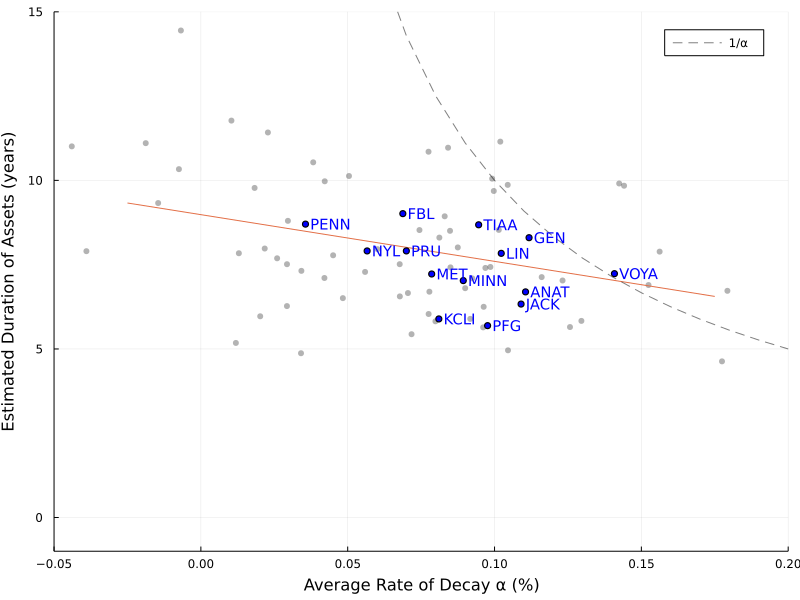

In [28]:
#
@df sel_avg_balance_df scatter(:fe_NAIC_no, :D_A, legend = :topleft, #alpha = :weights, 
    xlim = (-0.05, 0.2), ylim = (-1, 15.), c = :black, label = "", alpha = 0.3)
plot!(size = (800, 600), html_output_format=:png, legend = :topright,
    xlab = "Average Rate of Decay α (%)", ylab = "Estimated Duration of Assets (years)", label = "")

result2 =  reg(sel_avg_balance_df, @formula(D_A ~ fe_NAIC_no))
plot!([-0.025, 0.175], coef(result2)[1] .+ coef(result2)[2] .* [-0.025, 0.175], label = "")

@df @subset(avg_balance_df, :NAIC_no .== 69345) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 69345) annotate!(:fe_NAIC_no, :D_A, text(" TIAA", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 60739) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 60739) annotate!(:fe_NAIC_no, :D_A, text(" ANAT", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 63088) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 63088) annotate!(:fe_NAIC_no, :D_A, text(" FBL", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 65676) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 65676) annotate!(:fe_NAIC_no, :D_A, text(" LIN", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 65978) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 65978) annotate!(:fe_NAIC_no, :D_A, text(" MET", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 68241) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 68241) annotate!(:fe_NAIC_no, :D_A, text(" PRU ", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 86509) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 86509) annotate!(:fe_NAIC_no, :D_A, text(" VOYA", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 65536) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 65536) annotate!(:fe_NAIC_no, :D_A, text(" GEN", :blue, :left, 10))



@df @subset(avg_balance_df, :NAIC_no .== 65056) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 65056) annotate!(:fe_NAIC_no, :D_A, text(" JACK", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 66915) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 66915) annotate!(:fe_NAIC_no, :D_A, text(" NYL", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 66168) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 66168) annotate!(:fe_NAIC_no, :D_A, text(" MINN", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 67644) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 67644) annotate!(:fe_NAIC_no, :D_A, text(" PENN", :blue, :left, 10))

#

# poor reporting!
# @df @subset(avg_balance_df, :NAIC_no .== 65935) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
# @df @subset(avg_balance_df, :NAIC_no .== 65935) annotate!(:fe_NAIC_no, :D_A, text(" MASS", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 65129) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 65129) annotate!(:fe_NAIC_no, :D_A, text(" KCLI", :blue, :left, 10))

# I only have an estimate of 30 % of the liabilities => very poor reporting!
# @combine(@subset(reserves_est, :NAIC_no .== 68136), Totals = sum(:Totals))[1,1] / 
#     @combine(@subset(reserves, :NAIC_no .== 68136), Totals = sum(:Totals))[1,1]
# @df @subset(avg_balance_df, :NAIC_no .== 68136) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
# @df @subset(avg_balance_df, :NAIC_no .== 68136) annotate!(:fe_NAIC_no, :D_A, text(" PL", :blue, :left, 10))

@df @subset(avg_balance_df, :NAIC_no .== 61271) scatter!(:fe_NAIC_no, :D_A, c = :blue, markersize = 4, label = "")
@df @subset(avg_balance_df, :NAIC_no .== 61271) annotate!(:fe_NAIC_no, :D_A, text(" PFG", :blue, :left, 10))

png("Simple decay and asset duration")
plot!(0.01:0.01:0.2, x -> 1/x, c = :black, alpha = 0.5, linestyle = :dash, label = "1/α")
png("Simple decay and asset duration inverse")
plot!()

# Simple Model - One Issue Year

In [29]:
# 
max_rang = 80

reserves_est = @subset(
    reserves_notsensitive, 
    (
        ismissing.(:Rate2) .& 
        ismissing.(:ValuationStandard) .& 
        .!ismissing.(:Years_maxmin) .& 
        (:Years_maxmin .<= 4) .&
        (1 .< :Totals) .& 
        .!(:Years_isImputed) .& 
        .!ismissing.(:Totals_prev) .& 
        (-0.6 .< :p .< 0.6) .& 
        (1 .<= :Years_since .<= max_rang)
    )
)

dropmissing!(reserves_est, :Mort) # does not drop anything!

reserves_est[!, :elapsed] = round.(Int64, reserves_est[:, :Years_since])

dropmissing!(reserves_est, :Totals_prev)
print("$(nrow(reserves_est)) observations remain!\n")

# delete keys with additions outside of an issuance year
@transform!(reserves_est, has_new_issue = :Year .∈ :Years)

print("Deleted $(nrow(@subset(reserves_est, :has_new_issue))) observations with new issues in that year!\n")
reserves_est = @subset(reserves_est, .!:has_new_issue)
print("$(nrow(reserves_est)) observations remain!\n")

print("Deleted $(nrow(@subset(reserves_est, (:p .< -0.3) .& (:Years_since .>= 5)))) observations with large additions after 5 years!\n")
reserves_est = @subset(reserves_est, .!((:p .< -0.3) .& (:Years_since .>= 5)))
print("$(nrow(reserves_est)) observations remain!\n")

print("Deleted $(nrow(@subset(reserves_est, (:Line .== 2) .& (:p .< -0.0) .& (:Years_since .>= 5)))) annuity observations with additions after 5 years!\n")
reserves_est = @subset(reserves_est, .!((:Line .== 2) .& (:p .< -0.0) .& (:Years_since .>= 5)))
print("$(nrow(reserves_est)) observations remain!\n");

104208 observations remain!
Deleted 3190 observations with new issues in that year!
101018 observations remain!
Deleted 789 observations with large additions after 5 years!
100229 observations remain!
Deleted 2493 annuity observations with additions after 5 years!
97736 observations remain!


In [30]:
# #
# r1 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
#     @formula(
#         p ~ 
#             fe(Line) & fe(elapsed)
#         ), weights = :Totals_prev)

# r_2 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
#     @formula(
#         p ~ 
#             Decade +
#             fe(Line) & fe(elapsed)
#         ), weights = :Totals_prev)

# r3 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
#     @formula(
#         p ~ 
#             Decade + 
#             fe(Line)& fe(elapsed) +
#             rate_diff_issue
#         ), save = false, weights = :Totals_prev)

# r4 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
#     @formula(
#         p ~ 
#             Decade + 
#             fe(Line) & fe(elapsed) +
#             rate_diff_prev
#         ), save = false, weights = :Totals_prev)
# # regtable(r1, r_2, r3, r4, r5, r6, renderSettings = latexOutput("attributes.tex"))
# regtable(r1, r_2, r3, r4, renderSettings = asciiOutput())

In [31]:
#
r1 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
    @formula(
        p ~ 
            fe(Line) & fe(ImmDef) & fe(elapsed)
        ), Vcov.robust(), weights = :Totals_prev)

r_2 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
    @formula(
        p ~ 
            Decade +
            fe(Line) & fe(ImmDef) & fe(elapsed)
        ), Vcov.robust(), weights = :Totals_prev)

r3 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
    @formula(
        p ~ 
            Decade + 
            fe(Line) & fe(ImmDef) & fe(elapsed) +
            rate_diff_issue
        ), Vcov.robust(), save = false, weights = :Totals_prev)

r4 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
    @formula(
        p ~ 
            Decade + 
            fe(Line) & fe(ImmDef) & fe(Mort) & fe(elapsed) +
            rate_diff_issue
        ), Vcov.robust(), save = false, weights = :Totals_prev)

r5 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
    @formula(
        p ~ 
            Decade + 
            fe(Line) & fe(ImmDef) & fe(elapsed) +
            rate_diff_prev
        ), Vcov.robust(), save = false, weights = :Totals_prev)

r6 = reg(@transform(reserves_est, Decade = (:Year .- 2001) ./ 10), 
    @formula(
        p ~ 
            Decade + 
            fe(Line) & fe(ImmDef) & fe(Mort) & fe(elapsed) +
            rate_diff_prev
        ), Vcov.robust(), save = false, weights = :Totals_prev)

regtable(r1, r_2, r3, r4, r5, r6, renderSettings = latexOutput("attributes.tex"), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(r1, r_2, r3, r4, r5, r6, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


--------------------------------------------------------------------------------------------
                                                              p                             
                                 -----------------------------------------------------------
                                    (1)       (2)       (3)         (4)       (5)        (6)
--------------------------------------------------------------------------------------------
Decade                                     -0.000    -0.001   -0.010***    -0.000   -0.008**
                                          (0.003)   (0.003)     (0.004)   (0.003)    (0.004)
rate_diff_issue                                      0.171*    0.228***                     
                                                    (0.101)     (0.086)                     
rate_diff_prev                                                             -0.145     -0.108
                                                                     

In [32]:
@transform!(reserves_est, NAIC_decay = exp.(-0.1 .* :elapsed));

In [33]:
# result = reg(
#     reserves_est, 
#     @formula(
#         p ~ -1 + 
# #             fe(NAIC_no) + 
#             fe(Line) & fe(elapsed)
#         ), 
#     save = true, weights = :Totals_prev, drop_singletons = false)

In [34]:
# # fix NAIC_no FE

# avg_fe = @combine(
#     innerjoin(
#         reserves_est,
#         @combine(groupby(result.fe, :NAIC_no), fe = first(cols("fe_NAIC_no"))),
#         on = :NAIC_no
#     ),
#     avg_fe = sum(:fe .* :NAIC_decay .* :Totals_prev) / sum(:NAIC_decay .* :Totals_prev)
# )[1, :avg_fe]

# result.fe[:, Symbol("fe_NAIC_no")] .-= avg_fe
# # result.fe[:, Symbol("fe_Line&fe_elapsed")] .+= 
# #     exp.(-0.1 .* result.fe[:, Symbol("elapsed")]) .* avg_fe;

# result.fe[:, Symbol("fe_Line&fe_elapsed")] .+= avg_fe;

# avg_fe = @combine(
#     innerjoin(
#         reserves_est,
#         @combine(groupby(result.fe, :NAIC_no), fe = first(cols("fe_NAIC_no"))),
#         on = :NAIC_no
#     ),
#     avg_fe = sum(:fe .* :NAIC_decay .* :Totals_prev) / sum(:NAIC_decay .* :Totals_prev)
# )[1, :avg_fe]

# @assert abs(avg_fe) < 1e-10;

In [35]:
result = reg(
    vcat(reserves_est, 
#         @transform(reserves_est, elapsed = :elapsed .+ 1),
#         @transform(reserves_est, elapsed = :elapsed .- 1)
    ), 
    @formula(
        p ~ -1 + 
#             Decade + 
#             NAIC_decay & fe(NAIC_no) + 
#             rate_HQM_diff_issue + 
#             Rate + 
            fe(Line) & fe(ImmDef) & fe(elapsed)
        ), 
    save = true, weights = :Totals_prev, drop_singletons = false) #

                     Fixed Effect Model                     
Number of obs:          97736  Degrees of freedom:       354
R2:                     0.285  R2 Adjusted:            0.283
F-Stat:                   NaN  p-value:                  NaN
R2 within:              0.000  Iterations:                 1
p  | Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
------------------------------------------------------------


In [36]:
# # FEs 

# # 
# init_df = sort(@combine(groupby(result.fe, [:Line, :elapsed]), 
#     Line = first(:Line), elapsed = first(:elapsed), Ψest = 100 .* first(cols("fe_Line&fe_elapsed"))), 
#     [:Line, :elapsed])

# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1)) plot(:elapsed, :Ψest, label = "Life Insurance", width = 2, c = :black, linestyle = :dot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2)) plot!(:elapsed, :Ψest, label = "Annuity", width = 2, c = :black, linestyle = :solid)
# # @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot( :elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Life Insurance", width = 2, c = :black, linestyle = :dashdot)
# # @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
# # @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)
# # @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot( :elapsed, :Ψest .+ 100 .* coef(result)[2] .* 4.00 .+ 100 .* coef(result)[1] .* 2.00, label = "Life Insurance", width = 2, c = :black, linestyle = :dashdot)
# # @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest .+ 100 .* coef(result)[2] .* 5.25 .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
# # @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed, :Ψest .+ 100 .* coef(result)[2] .* 4.50 .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)

# plot!(size = (800, 600), html_output_format=:png, xlim = (0, 40), ylim = (-30, 30), legend = :bottomright,
#     ylab = "Decay (%)", xlab = "Elapsed Time since Issuance (years)")

# # png("Predicted b-V")
# plot!()

In [37]:
# # FEs 

# FEs = sort(
#     leftjoin(@combine(groupby(result.fe, [:Line]), elapsed = collect(1:max_rang)), 
#         @combine(groupby(result.fe, [:Line, :elapsed]), Ψest = first(cols("fe_Line&fe_elapsed"))),  
#         on = [:Line, :elapsed]), [:Line, :elapsed])

# FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.08
# dropmissing!(FEs)

# function pred(reserve_rate, Line; ImmDef = "", NAIC_no = 0, r = 0.0, Mort = "")
    
#     p_est = zeros(max_rang)
#     p_est .= @subset(FEs, (:Line .== Line))[:, :Ψest] #.+ coef(result)[1] .* 2.00
    
#     V = zeros(max_rang)
#     p_tilde = zeros(max_rang)
#     V[1] = 1
#     p_tilde[1] = V[1] * p_est[1]
#     for i in 2:max_rang
#         V[i] = V[i-1] * (1 + reserve_rate / 100) - V[i-1] * p_est[i-1]
#         p_tilde[i] = V[i] * p_est[i-1]
#     end
    
#     return V, p_tilde, p_est
# end

# p = plot(size = (800, 600), html_output_format=:png, xlab = "Elapsed Time since Issuance (years)", ylab = "Predicted Reserve Value (\$)", margin = 5mm)
# V_1, p_tilde_1, p_est_1 = pred(4.00, 1; ImmDef = "not specified", NAIC_no = 56847)
# V_2, p_tilde_2, p_est_2 = pred(5.25, 2; ImmDef = "immediate", NAIC_no = 56847)
# V_3, p_tilde_3, p_est_3 = pred(4.50, 2; ImmDef = "deferred", NAIC_no = 56847)
# plot!(p, 0.0:max_rang-1, V_1[1:max_rang], label = "Life Insurance 4%", width = 2, c = :black, linestyle = :dot)
# plot!(p, 0.0:max_rang-1, V_2[1:max_rang], label = "Annuity 5.25%", width = 2, c = :black, linestyle = :solid)
# # plot!(p, 0.0:max_rang-1, V_3[1:max_rang], label = "Annuity - deferred 4.5%",  width = 2, c = :black, linestyle = :dot)
# plot!(xlim = (0, 80), ylim = (0, 3.6))
# # png("Predicted V")
# plot!()

In [38]:
# # FEs 

# FEs = sort(
#     leftjoin(@combine(groupby(result.fe, [:Line]), elapsed = collect(1:max_rang)), 
#         @combine(groupby(result.fe, [:Line, :elapsed]), Ψest = first(cols("fe_Line&fe_elapsed"))),  
#         on = [:Line, :elapsed]), [:Line, :elapsed])

# FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.08
# dropmissing!(FEs)

# function pred(reserve_rate, Line; ImmDef = "", NAIC_no = 0, r = 0.0, Mort = "")
    
#     p_est = zeros(max_rang)
#     p_est .= @subset(FEs, (:Line .== Line))[:, :Ψest] #.+ coef(result)[1] .* 2.00
    
#     V = zeros(max_rang)
#     p_tilde = zeros(max_rang)
#     V[1] = 1
#     p_tilde[1] = V[1] * p_est[1]
#     for i in 2:max_rang
#         V[i] = V[i-1] * (1 + reserve_rate / 100) - V[i-1] * p_est[i-1]
#         p_tilde[i] = V[i] * p_est[i-1]
#     end
    
#     return V, p_tilde, p_est
# end

# p = plot(size = (800, 600), html_output_format=:png, xlab = "Elapsed Time since Issuance (years)", ylab = "Predicted Reserve Cash Flow (\$)", margin = 5mm)
# V_1, p_tilde_1, p_est_1 = pred(4.00, 1; ImmDef = "not specified", NAIC_no = 56847)
# V_2, p_tilde_2, p_est_2 = pred(5.25, 2; ImmDef = "immediate", NAIC_no = 56847)
# V_3, p_tilde_3, p_est_3 = pred(4.50, 2; ImmDef = "deferred", NAIC_no = 56847)
# plot!(p, 0.0:max_rang-1, p_tilde_1[1:max_rang], label = "Life Insurance 4%", width = 2, c = :black, linestyle = :dot)
# plot!(p, 0.0:max_rang-1, p_tilde_2[1:max_rang], label = "Annuity 5.25%", width = 2, c = :black, linestyle = :solid)
# # plot!(p, 0.0:max_rang-1, p_tilde_3[1:max_rang], label = "Annuity - deferred 4.5%",  width = 2, c = :black, linestyle = :dot)
# plot!(xlim = (0, 80), ylim = (-0.42, .25))
# # png("Predicted b")
# plot!()

In [39]:
# # result.fe[:, Symbol("fe_NAIC_no&NAIC_decay")] .-= avg_fe
# # result.fe[:, Symbol("fe_Line&fe_ImmDef&fe_elapsed")] .+= avg_fe;

# result.fe[:, Symbol("fe_NAIC_no&NAIC_decay")] .-= avg_fe
# result.fe[:, Symbol("fe_Line&fe_ImmDef&fe_elapsed")] .+= exp.(-0.1 .* result.fe[:, Symbol("elapsed")]) .* avg_fe;

In [40]:
# # avg_fe = @combine(
# #     innerjoin(
# #         @combine(groupby(reserves_est[:, [:NAIC_no, :Totals_prev]], :NAIC_no), Totals_prev_sum = sum(:Totals_prev)),
# #         @combine(groupby(result.fe, :NAIC_no), fe = first(cols("fe_NAIC_no&NAIC_decay"))),
# #         on = :NAIC_no
# #     ),
# #     avg_fe = sum(:fe .* :NAIC_decay .* :Totals_prev_sum) / sum(:NAIC_decay .* :Totals_prev_sum)
# # )[1, :avg_fe]

# avg_fe = @combine(
#     innerjoin(
# #         @combine(groupby(reserves_est[:, [:NAIC_no, :Totals_prev]], :NAIC_no), Totals_prev_sum = sum(:Totals_prev)),
#         reserves_est,
#         @combine(groupby(result.fe, :NAIC_no), fe = first(cols("fe_NAIC_no&NAIC_decay"))),
#         on = :NAIC_no
#     ),
# #     avg_fe = sum(:fe .* :NAIC_decay .* :Totals_prev_sum) / sum(:NAIC_decay .* :Totals_prev_sum)
#     avg_fe = sum(:fe .* :NAIC_decay .* :Totals_prev) / sum(:NAIC_decay .* :Totals_prev)
# )[1, :avg_fe]

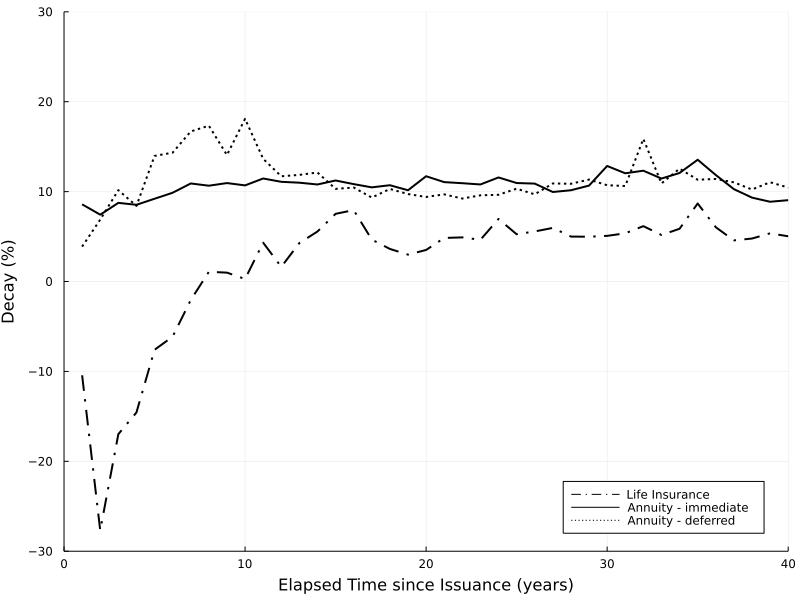

In [41]:
# FEs 

# 
init_df = sort(@combine(groupby(result.fe, [:Line, :ImmDef, :elapsed]), 
    Line = first(:Line), ImmDef = first(:ImmDef), elapsed = first(:elapsed), Ψest = 100 .* first(cols("fe_Line&fe_ImmDef&fe_elapsed"))), 
    [:Line, :ImmDef, :elapsed])

@df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot(:elapsed, :Ψest, label = "Life Insurance", width = 2, c = :black, linestyle = :dashdot)
@df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
@df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed, :Ψest, label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot( :elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Life Insurance", width = 2, c = :black, linestyle = :dashdot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot( :elapsed, :Ψest .+ 100 .* coef(result)[2] .* 4.00 .+ 100 .* coef(result)[1] .* 2.00, label = "Life Insurance", width = 2, c = :black, linestyle = :dashdot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest .+ 100 .* coef(result)[2] .* 5.25 .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed, :Ψest .+ 100 .* coef(result)[2] .* 4.50 .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)

plot!(size = (800, 600), html_output_format=:png, xlim = (0, 40), ylim = (-30, 30), legend = :bottomright,
    ylab = "Decay (%)", xlab = "Elapsed Time since Issuance (years)")

png("Predicted b-V")
plot!()

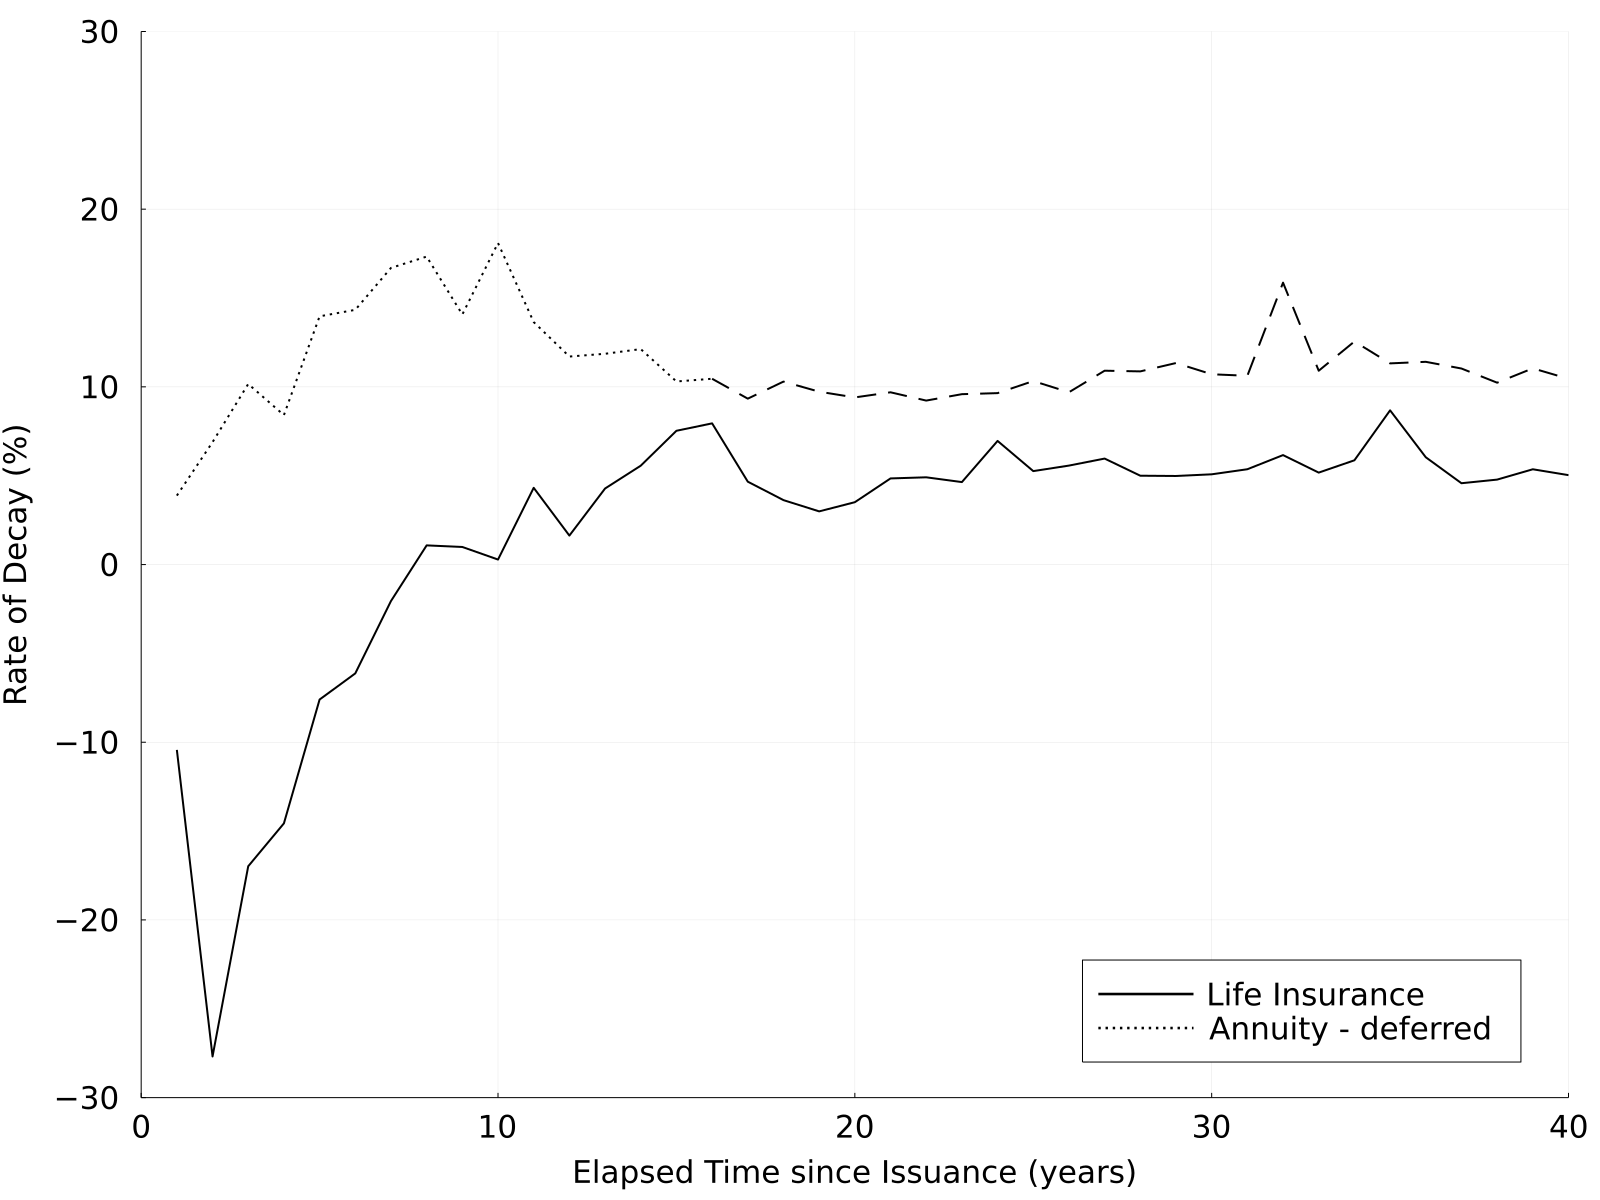

In [42]:
# FEs 

# 
init_df = sort(@combine(groupby(result.fe, [:Line, :ImmDef, :elapsed]), 
    Line = first(:Line), ImmDef = first(:ImmDef), elapsed = first(:elapsed), Ψest = 100 .* first(cols("fe_Line&fe_ImmDef&fe_elapsed"))), 
    [:Line, :ImmDef, :elapsed])

@df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot(:elapsed, :Ψest, label = "Life Insurance", width = 2, c = :black, linestyle = :solid)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
@df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed[1:16], :Ψest[1:16], label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)
@df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed[16:end], :Ψest[16:end], label = "",  width = 2, c = :black, linestyle = :dash)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot( :elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Life Insurance", width = 2, c = :black, linestyle = :dashdot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed, :Ψest .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 1))                              plot( :elapsed, :Ψest .+ 100 .* coef(result)[2] .* 4.00 .+ 100 .* coef(result)[1] .* 2.00, label = "Life Insurance", width = 2, c = :black, linestyle = :dashdot)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "immediate")) plot!(:elapsed, :Ψest .+ 100 .* coef(result)[2] .* 5.25 .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - immediate", width = 2, c = :black, linestyle = :solid)
# @df @subset(init_df, (:elapsed .> 0) .& (:Line .== 2) .& (:ImmDef .== "deferred"))  plot!(:elapsed, :Ψest .+ 100 .* coef(result)[2] .* 4.50 .+ 100 .* coef(result)[1] .* 2.00, label = "Annuity - deferred",  width = 2, c = :black, linestyle = :dot)

plot!(size = (800, 600), html_output_format=:png, xlim = (0, 40), ylim = (-30, 30), legend = :bottomright,
    ylab = "Rate of Decay (%)", xlab = "Elapsed Time since Issuance (years)")
plot!(size = (2*800, 2*600),margin = 6mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Predicted b-V composed")
plot!()

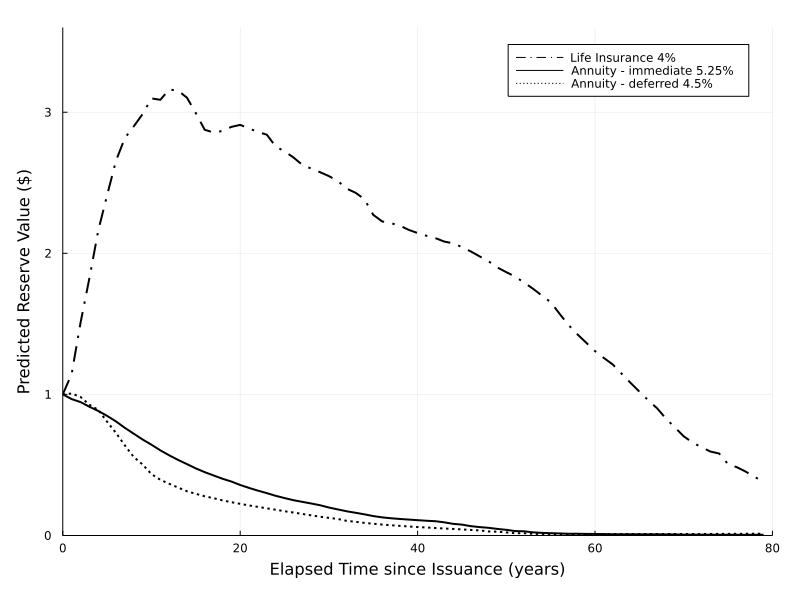

In [43]:
# FEs 

FEs = sort(
    leftjoin(@combine(groupby(result.fe, [:Line, :ImmDef]), elapsed = collect(1:max_rang)), 
        @combine(groupby(result.fe, [:Line, :ImmDef, :elapsed]), Ψest = first(cols("fe_Line&fe_ImmDef&fe_elapsed"))),  
        on = [:Line, :ImmDef, :elapsed]), [:Line, :ImmDef, :elapsed])

FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.08
dropmissing!(FEs)

function pred(reserve_rate, Line; ImmDef = "", NAIC_no = 0, r = 0.0, Mort = "")
    
    p_est = zeros(max_rang)
    p_est .= @subset(FEs, (:Line .== Line) .& (:ImmDef .== ImmDef))[:, :Ψest] #.+ coef(result)[1] .* 2.00
    
    V = zeros(max_rang)
    p_tilde = zeros(max_rang)
    V[1] = 1
    p_tilde[1] = V[1] * p_est[1]
    for i in 2:max_rang
        V[i] = V[i-1] * (1 + reserve_rate / 100) - V[i-1] * p_est[i-1]
        p_tilde[i] = V[i] * p_est[i-1]
    end
    
    return V, p_tilde, p_est
end

p = plot(size = (800, 600), html_output_format=:png, xlab = "Elapsed Time since Issuance (years)", ylab = "Predicted Reserve Value (\$)", margin = 5mm)
V_1, p_tilde_1, p_est_1 = pred(4.00, 1; ImmDef = "not specified", NAIC_no = 56847)
V_2, p_tilde_2, p_est_2 = pred(5.25, 2; ImmDef = "immediate", NAIC_no = 56847)
V_3, p_tilde_3, p_est_3 = pred(4.50, 2; ImmDef = "deferred", NAIC_no = 56847)
plot!(p, 0.0:max_rang-1, V_1[1:max_rang], label = "Life Insurance 4%", width = 2, c = :black, linestyle = :dashdot)
plot!(p, 0.0:max_rang-1, V_2[1:max_rang], label = "Annuity - immediate 5.25%", width = 2, c = :black, linestyle = :solid)
plot!(p, 0.0:max_rang-1, V_3[1:max_rang], label = "Annuity - deferred 4.5%",  width = 2, c = :black, linestyle = :dot)
plot!(xlim = (0, 80), ylim = (0, 3.6))
png("Predicted V")
plot!()

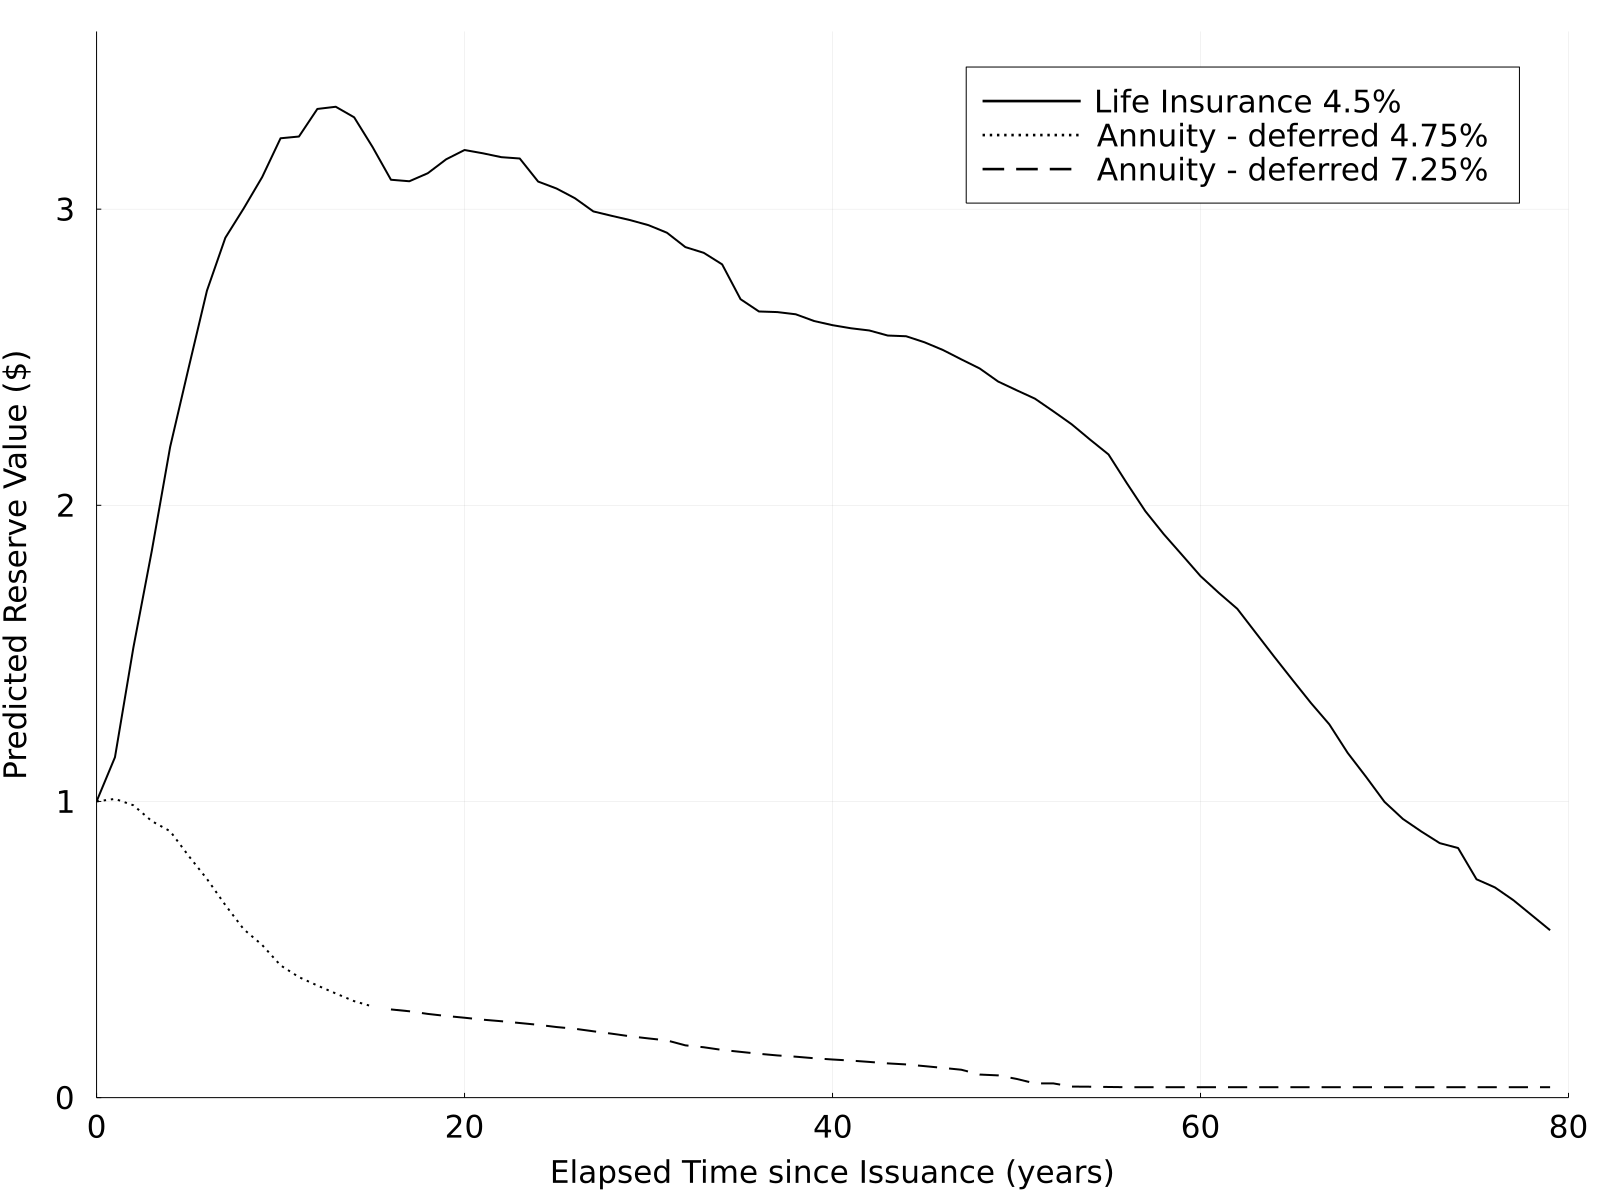

In [44]:
# FEs 

FEs = sort(
    leftjoin(@combine(groupby(result.fe, [:Line, :ImmDef]), elapsed = collect(1:max_rang)), 
        @combine(groupby(result.fe, [:Line, :ImmDef, :elapsed]), Ψest = first(cols("fe_Line&fe_ImmDef&fe_elapsed"))),  
        on = [:Line, :ImmDef, :elapsed]), [:Line, :ImmDef, :elapsed])

FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.08
dropmissing!(FEs)

function pred(reserve_rate, Line; ImmDef = "", NAIC_no = 0, r = 0.0, Mort = "")
    
    p_est = zeros(max_rang)
    p_est .= @subset(FEs, (:Line .== Line) .& (:ImmDef .== ImmDef))[:, :Ψest] #.+ coef(result)[1] .* 2.00
    
    V = zeros(max_rang)
    p_tilde = zeros(max_rang)
    V[1] = 1
    p_tilde[1] = V[1] * p_est[1]
    for i in 2:max_rang
        V[i] = V[i-1] * (1 + reserve_rate / 100) - V[i-1] * p_est[i-1]
        p_tilde[i] = V[i] * p_est[i-1]
    end
    
    return V, p_tilde, p_est
end

p = plot(size = (800, 600), html_output_format=:png, xlab = "Elapsed Time since Issuance (years)", ylab = "Predicted Reserve Value (\$)", margin = 5mm)
V_1, p_tilde_1, p_est_1 = pred(4.50, 1; ImmDef = "not specified", NAIC_no = 56847)
V_2, p_tilde_2, p_est_2 = pred(7.25, 2; ImmDef = "deferred", NAIC_no = 56847)
for i in 2:length(V_2)
    V_2[i] = V_2[i] > V_2[i-1] ? V_2[i-1] : V_2[i]
end
V_3, p_tilde_3, p_est_3 = pred(4.75, 2; ImmDef = "deferred", NAIC_no = 56847)
plot!(p, 0.0:max_rang-1, V_1[1:max_rang], label = "Life Insurance 4.5%", width = 2, c = :black, linestyle = :solid)
# plot!(p, 0.0:max_rang-1, V_2[1:max_rang], label = "Annuity - immediate 5.25%", width = 2, c = :black, linestyle = :solid)
plot!(p, 0.0:15, V_3[1:16], label = "Annuity - deferred 4.75%",  width = 2, c = :black, linestyle = :dot)
plot!(p, 16.0:max_rang-1, V_3[16] ./ V_2[16] .* V_2[17:max_rang], label = "Annuity - deferred 7.25%",  width = 2, c = :black, linestyle = :dash)
plot!(xlim = (0, 80), ylim = (0, 3.6))
plot!(size = (2*800, 2*600),margin = 6mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)

png("Predicted V composed")
plot!()

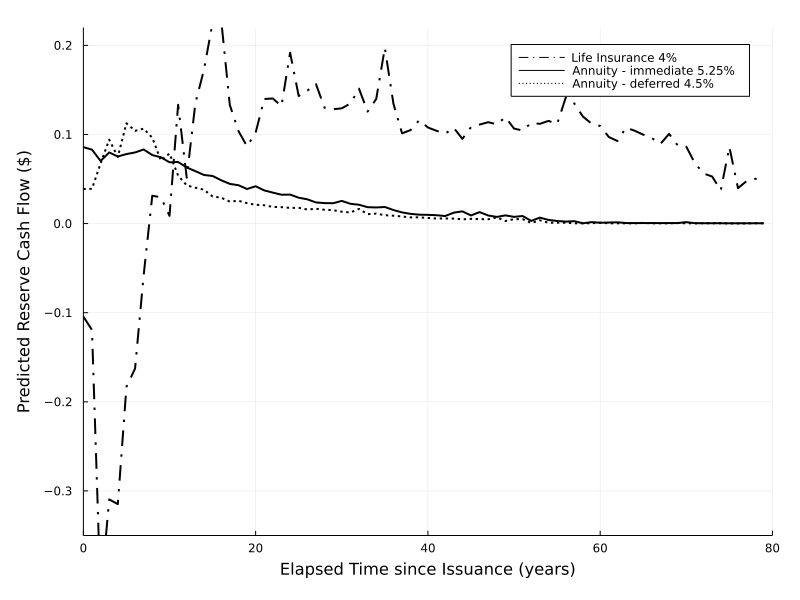

In [45]:
# FEs 

FEs = sort(
    leftjoin(@combine(groupby(result.fe, [:Line, :ImmDef]), elapsed = collect(1:max_rang)), 
        @combine(groupby(result.fe, [:Line, :ImmDef, :elapsed]), Ψest = first(cols("fe_Line&fe_ImmDef&fe_elapsed"))),  
        on = [:Line, :ImmDef, :elapsed]), [:Line, :ImmDef, :elapsed])

FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.08
dropmissing!(FEs)

function pred(reserve_rate, Line; ImmDef = "", NAIC_no = 0, r = 0.0, Mort = "")
    
    p_est = zeros(max_rang)
    p_est .= @subset(FEs, (:Line .== Line) .& (:ImmDef .== ImmDef))[:, :Ψest] #.+ coef(result)[1] .* 2.00
    
    V = zeros(max_rang)
    p_tilde = zeros(max_rang)
    V[1] = 1
    p_tilde[1] = V[1] * p_est[1]
    for i in 2:max_rang
        V[i] = V[i-1] * (1 + reserve_rate / 100) - V[i-1] * p_est[i-1]
        p_tilde[i] = V[i] * p_est[i-1]
    end
    
    return V, p_tilde, p_est
end

p = plot(size = (800, 600), html_output_format=:png, xlab = "Elapsed Time since Issuance (years)", ylab = "Predicted Reserve Cash Flow (\$)", margin = 5mm)
V_1, p_tilde_1, p_est_1 = pred(4.00, 1; ImmDef = "not specified", NAIC_no = 56847)
V_2, p_tilde_2, p_est_2 = pred(5.25, 2; ImmDef = "immediate", NAIC_no = 56847)
V_3, p_tilde_3, p_est_3 = pred(4.50, 2; ImmDef = "deferred", NAIC_no = 56847)
plot!(p, 0.0:max_rang-1, p_tilde_1[1:max_rang], label = "Life Insurance 4%", width = 2, c = :black, linestyle = :dashdot)
plot!(p, 0.0:max_rang-1, p_tilde_2[1:max_rang], label = "Annuity - immediate 5.25%", width = 2, c = :black, linestyle = :solid)
plot!(p, 0.0:max_rang-1, p_tilde_3[1:max_rang], label = "Annuity - deferred 4.5%",  width = 2, c = :black, linestyle = :dot)
plot!(xlim = (0, 80), ylim = (-0.35, .22))
png("Predicted b")
plot!()

In [46]:
# #   
# dates = Date(1989,12,1):Dates.Year(1):Date(2020,12,1)
# value_1 = zeros(length(dates))
# value_2 = zeros(length(dates))
# interest = zeros(103)
# cum_discounts = zeros(103)

# for (o, date) in enumerate(dates)
    
#     interest[1:30] .= @subset(rate_treasury, :date .== date)[:, :rate]
#     interest[31:end] .= interest[30]
    
#     for i in 1:length(interest)
#         cum_discounts[i] = exp(- i * interest[i] / 100)
#     end
    
#     r =    1 + @subset(rate_treasury, (:date .== date) .& (:horizon .== 7))[1, :rate] / 100
#     res_life = @subset(rate_reserve, :year .== Dates.year(date))[1, :rate_life]
#     res_ann =  @subset(rate_reserve, :year .== Dates.year(date))[1, :rate_ann]
#     V_1, p_tilde_1, p_est_1 = pred(4.0, 1; ImmDef = "not specified", NAIC_no = 65005)
#     V_2, p_tilde_2, p_est_2 = pred(5.250, 2; ImmDef = "immediate", NAIC_no = 65005)
    
#     value_1[o] = sum(p_tilde_1 .* cum_discounts[1:max_rang])
#     value_2[o] = sum(p_tilde_2 .* cum_discounts[1:max_rang])
    
# end

# #label = "Reserve mortality with market interest rates", 
# plot(dates, value_1, label = "Value of Life Insurance", width = 2, size = (800, 600), html_output_format=:png)
# plot!(dates, value_2, label = "Value of Annuity", width = 2)

#### Older

In [47]:
# # 
# max_rang = 80

# reserves_est = @subset(
#     reserves_notsensitive, 
#     (
#         ismissing.(:Rate2) .& 
#         ismissing.(:ValuationStandard) .& 
#         .!ismissing.(:Years_maxmin) .& 
#         (:Years_maxmin .<= 3) .&
#         (1 .< :Totals) .& 
#         .!(:Years_isImputed) .& 
#         .!ismissing.(:Totals_prev) .& 
#         (-0.5 .< :p .< 0.8) .& 
#         (1 .<= :Years_since .<= 35)
#     )
# )

# dropmissing!(reserves_est, :Mort) # does not drop anything!

# reserves_est[!, :elapsed] = round.(Int64, reserves_est[:, :Years_since])

# dropmissing!(reserves_est, :Totals_prev)
# print("$(nrow(reserves_est)) observations remain!\n")

# # delete keys with additions outside of an issuance year
# @transform!(reserves_est, has_new_issue = :Year .∈ :Years)

# print("Deleted $(nrow(@subset(reserves_est, :has_new_issue))) observations with new issues in that year!\n")
# reserves_est = @subset(reserves_est, .!:has_new_issue)
# print("$(nrow(reserves_est)) observations remain!\n")

# print("Deleted $(nrow(@subset(reserves_est, (:p .< -0.3) .& (:Years_since .>= 5)))) observations with large additions after 5 years!\n")
# reserves_est = @subset(reserves_est, .!((:p .< -0.3) .& (:Years_since .>= 5)))
# print("$(nrow(reserves_est)) observations remain!\n")

# print("Deleted $(nrow(@subset(reserves_est, (:Line .== 2) .& (:p .< -0.0) .& (:Years_since .>= 5)))) annuity observations with additions after 5 years!\n")
# reserves_est = @subset(reserves_est, .!((:Line .== 2) .& (:p .< -0.0) .& (:Years_since .>= 5)))
# print("$(nrow(reserves_est)) observations remain!\n")

# # b = Basis(SplineParams([1, max_rang], 0, 2))
# b = Basis(ChebParams(4, 0, max_rang))
# M = BasisMatrix(b, Expanded(), reserves_est[:, :Years_since], 0).vals[1]

# reserves_est[!, :s1] = M[:, 1]
# reserves_est[!, :s2] = M[:, 2]
# reserves_est[!, :s3] = M[:, 3];
# reserves_est[!, :s4] = M[:, 4];

In [48]:
# # prepare data

# # Selection

# reserves_est = @subset(reserves_notsensitive, 
#     (
#         ismissing.(:Rate2) .& 
#         ismissing.(:ValuationStandard) .&
#         .!ismissing.(:Years_maxmin) .& 
#         (:Years_maxmin .< 4) .& 
#         (:Totals .> 1000) .&
#         .!(:Years_isImputed) .&
#         .!ismissing.(:Totals_prev) .&
#         (-0.5 .< :p .< 0.5)
#     ))

# max_rang = 80
# # b = Basis(SplineParams([1, max_rang], 0, 3))
# b = Basis(ChebParams(4, 0, max_rang))
# M = BasisMatrix(b, Expanded(), reserves_est[:, :Years_since], 0).vals[1]

# reserves_est[!, :s1] = M[:, 1]
# reserves_est[!, :s2] = M[:, 2]
# reserves_est[!, :s3] = M[:, 3]
# reserves_est[!, :s4] = M[:, 4];

# # max_rang = 80
# # b = Basis(ChebParams(5, 0, max_rang))
# # # b = Basis(SplineParams([1, 20, 50, max_rang], 0, 3))
# # M = Matrix(BasisMatrix(b, Expanded(), reserves_est[:, :Years_since], 0).vals[1])
# # constraints = Matrix(vcat(
# # #     BasisMatrix(b, Expanded(), [80.], 0).vals[1],
# #     BasisMatrix(b, Expanded(), [80.], 0).vals[1]
# # ))
# # reserves_est[!, :s1] = (M * nullspace(constraints, atol = 1e-4))[:, 1]
# # reserves_est[!, :s2] = (M * nullspace(constraints, atol = 1e-4))[:, 2]
# # reserves_est[!, :s3] = (M * nullspace(constraints, atol = 1e-4))[:, 3]
# # reserves_est[!, :s4] = (M * nullspace(constraints, atol = 1e-4))[:, 4]
# # # reserves_est[!, :p] .-= M * (constraints \ [-0.2, ]);
# # reserves_est[!, :p] .-= M * ones(5) ./ 5 .* reserves_est[:, :Rate] ./ 100;

In [49]:
# result = reg(reserves_est, @formula(
#         p ~ -1 + 
# #             Decade + 
#             s1 & fe(Line) & fe(ImmDef) + 
#             s2 & fe(Line) & fe(ImmDef) + 
#             s3 & fe(Line) & fe(ImmDef) + 
#             s4 & fe(Line) & fe(ImmDef) #+
# #             s5 & fe(Line) & fe(ImmDef)
#         ), 
#     save = :fe, weights = :Totals_prev)

In [50]:
# # FEs 

# FEs = @combine(groupby(result.fe, [:Line, :ImmDef]), 
#     s1 = first(cols("fe_Line&fe_ImmDef&s1")), 
#     s2 = first(cols("fe_Line&fe_ImmDef&s2")), 
#     s3 = first(cols("fe_Line&fe_ImmDef&s3")),
#     s4 = first(cols("fe_Line&fe_ImmDef&s4")),
# #     s5 = first(cols("fe_Line&fe_ImmDef&s5")),
#     )


# function pred(Line, ImmDef, Mort,  r, res, Decade)
    
#     N = BasisMatrix(b, Expanded(), 1.0:1:80, 0).vals[1]

#     p_est = #coef(result)[1] * Decade .+ 
#         N * Array(@subset(FEs, (:Line .== Line) .& (:ImmDef .== ImmDef))[1, [:s1, :s2, :s3, :s4]])
    
# #     p_est[31:end] .= 0.2
    
#     V = zeros(80)
#     p_tilde = zeros(80)
#     V[1] = 1
#     p_tilde[1] = p_est[1]
#     for i in 2:80
#         V[i] = V[i-1] * (1 + res / 100) - V[i-1] * p_est[i-1]
#         p_tilde[i] = p_est[i] * V[i]
#     end
    
#     return V, p_tilde, p_est
# end

# p = plot(size = (800, 600), html_output_format=:png, xlab = "Years since issue", ylab = "Reserve Value", margin = 5mm)
# V_1, p_tilde_1, p_est_1 = pred(1, "not specified", "1980CSO",   6.0, 3.0, 0)
# V_2, p_tilde_2, p_est_2 = pred(2, "immediate",     "1983IAM",   6.0, 6.0, 0)
# V_3, p_tilde_3, p_est_3 = pred(2, "deferred",      "1983IAM",   6.0, 6.0, 0)
# plot!(p, 0.0:80-1, V_1[1:80], label = "Life Insurance", width = 2)
# plot!(p, 0.0:80-1, V_2[1:80], label = "Annuity - immediate", width = 2)
# plot!(p, 0.0:80-1, V_3[1:80], label = "Annuity - deferred",  width = 2)
# plot!(xlim = (0, 40), ylim = (0, 3))
# # png("Predicted V")
# plot!()

In [51]:
# # 
# dates = Date(1989,12,1):Dates.Year(1):Date(2020,12,1)
# value_1 = zeros(length(dates))
# value_2 = zeros(length(dates))
# interest = zeros(103)
# cum_discounts = zeros(103)

# for (o, date) in enumerate(dates)
    
#     interest[1:30] .= @subset(rate_HQM, :date .== date)[:, :rate]
#     interest[31:end] .= interest[30]
    
#     for i in 1:length(interest)
#         cum_discounts[i] = exp(- i * interest[i] / 100)
#     end
    
#     r =    1 + @subset(rate_treasury, (:date .== date) .& (:horizon .== 7))[1, :rate] / 100
#     res_life = @subset(rate_reserve, :year .== Dates.year(date))[1, :rate_life]
#     res_ann =  @subset(rate_reserve, :year .== Dates.year(date))[1, :rate_ann]
#     V_1, p_tilde_1, p_est_1 = pred(1, "not specified", "1980CSO",   r, res_life, 0)
#     V_2, p_tilde_2, p_est_2 = pred(2, "immediate",     "1983IAM",   r, res_ann, 0)
    
#     value_1[o] = sum(p_tilde_1 .* cum_discounts[1:80])
#     value_2[o] = sum(p_tilde_2 .* cum_discounts[1:80])
    
# end

# #label = "Reserve mortality with market interest rates", 
# plot(dates, value_1, label = "Value of Life Insurance", width = 2, size = (800, 600), html_output_format=:png)
# plot!(dates, value_2, label = "Value of Annuity", width = 2)

In [52]:
# # FEs 

# function pred(reserve_rate, Line; ImmDef = "", NAIC_no = 0, r = 0.0, Mort = "")
    
#     p_est = zeros(max_rang)
#     N = BasisMatrix(b, Expanded(), 1.0:1:80, 0).vals[1]
#     p_est = N * Array(@subset(FEs, (:Line .== Line) .& (:ImmDef .== ImmDef))[1, [:s1, :s2, :s3, :s4]])
    
#     V = zeros(max_rang)
#     p_tilde = zeros(max_rang)
#     V[1] = 1
#     p_tilde[1] = V[1] * p_est[1]
#     for i in 2:max_rang
#         V[i] = V[i-1] * (1 + reserve_rate / 100) - V[i-1] * p_est[i-1]
#         p_tilde[i] = V[i] * p_est[i-1]
#     end
    
#     return V, p_tilde, p_est
# end

# p = plot(size = (800, 600), html_output_format=:png, xlab = "Elapsed Time since Issuance (years)", ylab = "Predicted Reserve Cash Flow (\$)", margin = 5mm)
# V_1, p_tilde_1, p_est_1 = pred(4.00, 1; ImmDef = "not specified", NAIC_no = 56847)
# V_2, p_tilde_2, p_est_2 = pred(5.25, 2; ImmDef = "immediate", NAIC_no = 56847)
# V_3, p_tilde_3, p_est_3 = pred(4.50, 2; ImmDef = "deferred", NAIC_no = 56847)
# plot!(p, 0.0:max_rang-1, p_tilde_1[1:max_rang], label = "Life Insurance 4%", width = 2, c = :black, linestyle = :dashdot)
# plot!(p, 0.0:max_rang-1, p_tilde_2[1:max_rang], label = "Annuity - immediate 5.25%", width = 2, c = :black, linestyle = :solid)
# plot!(p, 0.0:max_rang-1, p_tilde_3[1:max_rang], label = "Annuity - deferred 4.5%",  width = 2, c = :black, linestyle = :dot)
# plot!(xlim = (0, 80), ylim = (-0.35, .22))
# png("Predicted b")
# plot!()

In [53]:
# # predict duration of nonsensitive liabilities
# N = BasisMatrix(b, Expanded(), 1.0:1:80, 0).vals[1]
# V = zeros(80)
# p_tilde = zeros(80)
# interest = zeros(80)
# cum_discounts = zeros(80)
# p_est = zeros(80)

# reserves_pred = copy(reserves_notsensitive)
# sort!(reserves_pred, :Year)

# reserves_pred = innerjoin(
#     reserves_pred, 
#     @combine(groupby(result.fe, [:Line, :ImmDef]), 
#         s1 = first(cols("fe_Line&fe_ImmDef&s1")), 
#         s2 = first(cols("fe_Line&fe_ImmDef&s2")), 
#         s3 = first(cols("fe_Line&fe_ImmDef&s3")),
#         ),
#     on = [:Line, :ImmDef])
# sort!(reserves_pred, [:Year, :Line, :ImmDef])

# Value = Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# DD = Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# D = Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# Value_R = Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# DD_R = Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# D_R = Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))

# ran = collect(1:length(p_tilde))
# y_curr = 0
# N = BasisMatrix(b, Expanded(), 1.0:1:max_rang, 0).vals[1]

# Line_curr = 0
# ImmDef_curr = ""
# A = Float64[]

# @showprogress "Predicting... " for (i, row) in enumerate(eachrow(reserves_pred))

#     if row.Years_since >= 0
#         p_est .= 0.2

#         try
#             if row.Line != Line_curr || row.ImmDef != ImmDef_curr
#                 # load new FEs
#                 sub = @subset(FEs, (:Line .== row.Line) .& (:ImmDef .== row.ImmDef))
#                 A = Array(sub[1, [:s1, :s2, :s3, :s4]])
#             end
            
#             p_est[1:max(0, min(max_rang, max_rang-Int64(row.Years_since)))] .= 
#                 (N * A)[Int64(row.Years_since) + 1:end]
            
#             p_est[31:end] .+= 0.05

#             V .= 0
#             p_tilde .= 0
#             V[1] = row.Totals
#             # mind the different timing: p_tilde[1] is the first payment (next year)
#             p_tilde[1] = p_est[1] * V[1]
#             @inbounds for i in 2:(80-Int64(row.Years_since))
#                 V[i] = V[i-1] * (1 + row.Rate / 100) - V[i-1] * p_est[i-1]
#                 p_tilde[i] = p_est[i] * V[i]
#             end

#             if row.Year != y_curr
#                 y_curr = row.Year
#                 @views interest[1:30] .= @subset(rate_treasury, :date .== Date(row.Year, 10, 1))[:, :rate]
#                 @views interest[31:end] .= interest[30]

#                 @inbounds for i in 1:length(interest)
#                     cum_discounts[i] = exp(- i * interest[i] / 100)
#                 end
#             end

#             Value_R[i] = sum(p_tilde .* (1 + row.Rate / 100) .^ -ran)
#             DD_R[i] = sum(ran .* p_tilde .* (1 + row.Rate / 100) .^ -ran)
#             D_R[i] = DD_R[i] / max(1, Value_R[i])

#             Value[i] = sum(p_tilde .* cum_discounts)
#             DD[i] = sum(ran .* p_tilde .* cum_discounts)
#             D[i] = DD[i] / max(1, Value[i])
#             catch ex
#                 @show i
#                 error(ex)
#         end
#     end
# end

# reserves_pred[!, :Value_R] = Value_R
# reserves_pred[!, :DD_R] = DD_R
# reserves_pred[!, :D_R] = D_R
# reserves_pred[!, :Value] = Value
# reserves_pred[!, :DD] = DD
# reserves_pred[!, :D] = D;

### Predictions

In [54]:
# # Line only 

# V = zeros(80)
# p_tilde = zeros(80)
# interest = zeros(80)
# cum_discounts = zeros(80)
# p_est = zeros(80)

# reserves_pred = copy(reserves_notsensitive)
# # reserves_pred = @where(reserves_notsensitive, :key .== "26a125514922004d4b6ba98437adffe948d80660")
# sort!(reserves_pred, [:Year, :Line])

# FEs = sort(
#     leftjoin(@combine(groupby(result.fe, [:Line]), elapsed = collect(1:max_rang)), 
#         @combine(groupby(result.fe, [:Line, :elapsed]), Ψest = first(cols("fe_Line&fe_elapsed"))),  
#         on = [:Line, :elapsed]), [:Line, :elapsed])

# # only keep NAICs with an estimate!
# # NAIC_FEs = sort(@combine(groupby(result.fe, [:NAIC_no]), 
# #         αest = first(cols("fe_NAIC_no&NAIC_decay"))), :NAIC_no)
# # reserves_pred = innerjoin(reserves_pred, NAIC_FEs, on = :NAIC_no)

# FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.0820549
# dropmissing!(FEs);

# # duration_df = @combine(groupby(reserves_pred, [:Year, :Line, :Rate, :Years_since]), αest = first(:αest))
# duration_df = @combine(groupby(reserves_pred, [:Year, :Line, :Rate, :Years_since]), D = -1.0)

# Value =   Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
# DD =      Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
# D =       Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
# Value_R = Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
# DD_R =    Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
# D_R =     Vector{Union{Missing,Float64}}(missing, nrow(duration_df))

# ran = collect(1:length(p_tilde))
# y_curr = 0

# Line_curr = 0

# sub = deepcopy(FEs)

# @showprogress "Predicting... " for (i, row) in enumerate(eachrow(duration_df))

#     p_est .= 0.0820549

# #     try

#         if row.Line != Line_curr
#             Line_curr = row.Line
#             # load new FEs
#             sub = @subset(FEs, (:Line .== row.Line))
#         end

#         p_est[1:max(1, min(80, 80-Int64(row.Years_since)))] .= 0 .+ 
# #             exp(-0.1 * row.Years_since) * row.αest .+ 
#             sub[max(1,min(80, Int64(row.Years_since)+1)):end, :Ψest]

#         V .= 0
#         p_tilde .= 0
#         V[1] = 1
#         # mind the different timing: p_tilde[1] is the first payment (next year)
#         p_tilde[1] = p_est[1] * V[1]

#         @inbounds for i in 2:80
#             V[i] = V[i-1] * (1 + row.Rate / 100) - V[i-1] * min(p_est[i-1], 1 + row.Rate / 100) # cannot go negative!
#             p_tilde[i] = V[i] * p_est[i]
#         end

#         if row.Year != y_curr
#             y_curr = row.Year
#             @views interest[1:30] .= 
#                 @combine(groupby(@subset(rate_treasury, Dates.year.(:date) .== row.Year), :horizon), 
#                     rate = mean(:rate))[:, :rate]
#             @views interest[31:end] .= interest[30]

#             @inbounds for i in 1:length(interest)
#                 cum_discounts[i] = exp(- i * interest[i] / 100)
#             end
#         end

#         Value_R[i] = sum(p_tilde .* (1 + row.Rate / 100) .^ -ran)
#         DD_R[i] = sum(ran .* p_tilde .* (1 + row.Rate / 100) .^ -ran)
#         D_R[i] = DD_R[i] / Value_R[i]

#         Value[i] = sum(p_tilde .* cum_discounts)
#         DD[i] = sum(ran .* p_tilde .* cum_discounts)
#         D[i] = DD[i] / Value[i]
#         if !(0 < D[i] < 50)
        
#             Value_R[i] = missing
#             DD_R[i] = missing
#             D_R[i] = missing
        
#             Value[i] = missing
#             DD[i] = missing
#             D[i] = missing
            
#         end
# #     catch ex
# #         @show i
# #         error(ex)
# #     end
# end

# duration_df[!, :Value_R] = Value_R
# duration_df[!, :DD_R] = DD_R
# duration_df[!, :D_R] = D_R
# duration_df[!, :Value] = Value
# duration_df[!, :DD] = DD
# duration_df[!, :D] = D

# try
#     select!(reserves_pred, Not(:αest))
# catch
# end

# n = nrow(reserves_pred)
# reserves_pred = innerjoin(reserves_pred, duration_df, on = [:Year, :Line, :Rate, :Years_since]);

# # scale by Totals
# @transform!(reserves_pred, 
#     DD = :Totals .* :D .* :Value ./ :Value_R, 
#     Value_R = :Totals .* :Value_R ./ :Value_R, 
#     DD_R = :Totals .* :DD_R ./ :Value_R, 
#     Value = :Totals .* :Value ./ :Value_R,
#     )
# @assert nrow(reserves_pred) == n;

# describe(duration_df)

In [55]:
# 

V = zeros(80)
p_tilde = zeros(80)
interest = zeros(80)
cum_discounts = zeros(80)
p_est = zeros(80)

reserves_pred = copy(reserves_notsensitive)
# reserves_pred = @where(reserves_notsensitive, :key .== "26a125514922004d4b6ba98437adffe948d80660")
sort!(reserves_pred, [:Year, :Line, :ImmDef])

FEs = sort(
    leftjoin(@combine(groupby(result.fe, [:Line, :ImmDef]), elapsed = collect(1:max_rang)), 
        @combine(groupby(result.fe, [:Line, :ImmDef, :elapsed]), Ψest = first(cols("fe_Line&fe_ImmDef&fe_elapsed"))),  
        on = [:Line, :ImmDef, :elapsed]), [:Line, :ImmDef, :elapsed])

# only keep NAICs with an estimate!
# NAIC_FEs = sort(@combine(groupby(result.fe, [:NAIC_no]), αest = first(cols("fe_NAIC_no&NAIC_decay"))), :NAIC_no)
# reserves_pred = innerjoin(reserves_pred, NAIC_FEs, on = :NAIC_no)

FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.0820549
dropmissing!(FEs);

# duration_df = @combine(groupby(reserves_pred, [:Year, :Line, :ImmDef, :Rate, :Years_since]), αest = first(:αest))
duration_df = @combine(groupby(reserves_pred, [:Year, :Line, :ImmDef, :Rate, :Years_since]), D = -1.0)

Value =   Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
DD =      Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
DC =      Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
D =       Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
C =       Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
Value_R = Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
DD_R =    Vector{Union{Missing,Float64}}(missing, nrow(duration_df))
D_R =     Vector{Union{Missing,Float64}}(missing, nrow(duration_df))

ran = collect(1:length(p_tilde))
y_curr = 0

Line_curr = 0
ImmDef_curr = ""

sub = deepcopy(FEs)

@showprogress "Predicting... " for (i, row) in enumerate(eachrow(duration_df))

    p_est .= 0.0820549

#     try

        if row.Line != Line_curr || row.ImmDef != ImmDef_curr
            Line_curr = row.Line
            ImmDef_curr = row.ImmDef
            # load new FEs
            sub = @subset(FEs, (:Line .== row.Line) .& (:ImmDef .== row.ImmDef))
        end

        p_est[1:max(1, min(80, 80-Int64(row.Years_since)))] .= 0 .+ 
#             coef(result)[1] * (row.Year - 2001) / 10 .+ 
#             coef(result)[2] * row.Rate .+ 
#             exp(-0.1 * row.Years_since) * row.αest .+ 
            sub[max(1,min(80, Int64(row.Years_since)+1)):end, :Ψest]

        V .= 0
        p_tilde .= 0
        V[1] = 1
        # mind the different timing: p_tilde[1] is the first payment (next year)
        p_tilde[1] = p_est[1] * V[1]

        @inbounds for i in 2:80
            V[i] = V[i-1] * (1 + row.Rate / 100) - V[i-1] * min(p_est[i-1], 1 + row.Rate / 100) # cannot go negative!
            p_tilde[i] = V[i] * p_est[i]
        end

        if row.Year != y_curr
            y_curr = row.Year
            @views interest[1:30] .= 
                @combine(groupby(@subset(rate_treasury, Dates.year.(:date) .== row.Year), :horizon), 
                rate = mean(:rate))[:, :rate]
            @views interest[31:end] .= interest[30]

            @inbounds for i in 1:length(interest)
                cum_discounts[i] = exp(- i * interest[i] / 100)
            end
        end

        Value_R[i] = sum(p_tilde .* (1 + row.Rate / 100) .^ -ran)
        DD_R[i] = sum(ran .* p_tilde .* (1 + row.Rate / 100) .^ -ran)
        D_R[i] = DD_R[i] / Value_R[i]

        Value[i] = sum(p_tilde .* cum_discounts)
        DD[i] = sum(ran .* p_tilde .* cum_discounts)
        DC[i] = sum(ran .^ 2 .* p_tilde .* cum_discounts)
        D[i] = DD[i] / Value[i]
        C[i] = DC[i] / Value[i]
        if !(0 < D[i] < 50)
        
            Value_R[i] = missing
            DD_R[i] = missing
            D_R[i] = missing
        
            Value[i] = missing
            DD[i] = missing
            D[i] = missing
            
        end
#     catch ex
#         @show i
#         error(ex)
#     end
end

duration_df[!, :Value_R] = Value_R
duration_df[!, :DD_R] = DD_R
duration_df[!, :D_R] = D_R
duration_df[!, :Value] = Value
duration_df[!, :DD] = DD
duration_df[!, :D] = D
duration_df[!, :DC] = DC
duration_df[!, :C] = C

try
    select!(reserves_pred, Not(:αest))
catch
end

n = nrow(reserves_pred)
reserves_pred = innerjoin(reserves_pred, duration_df, on = [:Year, :Line, :ImmDef, :Rate, :Years_since]);

# scale by Totals
@transform!(reserves_pred, 
    DD = :Totals .* :D .* :Value ./ :Value_R, 
    Value_R = :Totals .* :Value_R ./ :Value_R, 
    DD_R = :Totals .* :DD_R ./ :Value_R, 
    Value = :Totals .* :Value ./ :Value_R,
    )
@assert nrow(reserves_pred) == n;

describe(duration_df)

Predicting... 100%|█████████████████████████████████████| Time: 0:00:29


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Year,2010.83,2001,2011.0,2020,0,Int64
2,Line,1.71739,1,2.0,2,0,Int64
3,ImmDef,,both,,not specified,0,String
4,Rate,5.24379,0.0,5.0,15.5,0,Float64
5,Years_since,29.9987,-470.0,21.0,1033.0,0,Float64
6,D,12.6668,3.89364,11.2418,49.9826,474,"Union{Missing, Float64}"
7,Value_R,0.999109,0.982636,0.999671,0.999976,474,"Union{Missing, Float64}"
8,DD_R,11.2621,4.99458,9.48661,56.9028,474,"Union{Missing, Float64}"
9,D_R,11.2782,4.9964,9.48888,57.7878,474,"Union{Missing, Float64}"


In [56]:
# # predict duration of nonsensitive liabilities 
# V = zeros(80)
# p_tilde = zeros(80)
# interest = zeros(80)
# cum_discounts = zeros(80)
# p_est = zeros(80)

# reserves_pred = copy(reserves_notsensitive)
# # reserves_pred = @where(reserves_notsensitive, :key .== "26a125514922004d4b6ba98437adffe948d80660")
# sort!(reserves_pred, [:Year, :Line, :ImmDef])

# FEs = sort(
#     leftjoin(@combine(groupby(result.fe, [:Line, :ImmDef]), elapsed = collect(1:max_rang)), 
#         @combine(groupby(result.fe, [:Line, :ImmDef, :elapsed]), Ψest = first(cols("fe_Line&fe_ImmDef&fe_elapsed"))),  
#         on = [:Line, :ImmDef, :elapsed]), [:Line, :ImmDef, :elapsed])

# # only keep NAICs with an estimate!
# # NAIC_FEs = sort(@combine(groupby(result.fe, [:NAIC_no]), αest = first(cols("fe_NAIC_no"))), :NAIC_no)
# # reserves_pred = innerjoin(reserves_pred, NAIC_FEs, on = :NAIC_no)

# FEs[ismissing.(FEs[:, :Ψest]), :Ψest] .= 0.12
# dropmissing!(FEs);

# # proper prediction
# Value =   Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# DD =      Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# D =       Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# Value_R = Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# DD_R =    Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))
# D_R =     Vector{Union{Missing,Float64}}(missing, nrow(reserves_pred))

# ran = collect(1:length(p_tilde))
# y_curr = 0

# Line_curr = 0
# ImmDef_curr = ""

# sub = deepcopy(FEs)

# @showprogress "Predicting... " for (i, row) in enumerate(eachrow(reserves_pred))

#     p_est .= 0.15

#     try

#         if row.Line != Line_curr || row.ImmDef != ImmDef_curr
#             # load new FEs
#             sub = @subset(FEs, (:Line .== row.Line) .& (:ImmDef .== row.ImmDef))
#         end

#         p_est[1:max(1, min(80, 80-Int64(row.Years_since)))] .= 0 .+ #coef(result)[1] * row.Decade .+ 
#             sub[max(1,min(80, Int64(row.Years_since)+1)):end, :Ψest]

#         V .= 0
#         p_tilde .= 0
#         V[1] = row.Totals
#         # mind the different timing: p_tilde[1] is the first payment (next year)
#         p_tilde[1] = p_est[1] * V[1]

#         @inbounds for i in 2:80
#             V[i] = V[i-1] * (1 + row.Rate / 100) - V[i-1] * min(p_est[i-1], 1 + row.Rate / 100) # cannot go negative!
#             p_tilde[i] = V[i] * p_est[i]
#         end

#         if row.Year != y_curr
#             y_curr = row.Year
#             @views interest[1:30] .= 
#                 @combine(groupby(@subset(rate_HQM, Dates.year.(:date) .== row.Year), :horizon), 
#                     rate = mean(:rate))[:, :rate]
#             @views interest[31:end] .= interest[30]

#             @inbounds for i in 1:length(interest)
#                 cum_discounts[i] = exp(- i * interest[i] / 100)
#             end
#         end

#         Value_R[i] = sum(p_tilde .* (1 + row.Rate / 100) .^ -ran)
#         DD_R[i] = sum(ran .* p_tilde .* (1 + row.Rate / 100) .^ -ran)
#         D_R[i] = DD_R[i] / Value_R[i]

#         Value[i] = sum(p_tilde .* cum_discounts)
#         DD[i] = sum(ran .* p_tilde .* cum_discounts)
#         D[i] = DD[i] / Value[i]
#     catch ex
#         @show i
#         error(ex)
#     end
# end

# reserves_pred[!, :Value_R] = Value_R
# reserves_pred[!, :DD_R] = DD_R
# reserves_pred[!, :D_R] = D_R
# reserves_pred[!, :Value] = Value
# reserves_pred[!, :DD] = DD
# reserves_pred[!, :D] = D;

In [57]:
#
@warn @combine(@subset(reserves_pred, ismissing.(:DD)), Totals = sum(:Totals))[1, :Totals] / 
    @combine(reserves_pred, Totals = sum(:Totals))[1, :Totals]

# 90611 does not provide years for any reserve positon, hence there is not fe_NAIC_no

dropmissing!(reserves_pred, :DD);

┌ Warning: 0.015780546108099636
└ @ Main In[57]:2


In [58]:
# aggregate to NAIC_no year
L_NAIC_year = outerjoin(@combine(groupby(reserves_pred, [:Year, :NAIC_no]), 
#         Totals_L = sum(ifelse.((:Line .== 2) .& (:Years_since .> 35), 0.0, :Totals)),
#         DD_L =     sum(ifelse.((:Line .== 2) .& (:Years_since .> 35), 0.0, :DD)),
#         Value_L =  sum(ifelse.((:Line .== 2) .& (:Years_since .> 35), 0.0, :Value))
        Totals_L = sum(:Totals),
#         Totals_L_missing = sum(:Totals[ismissing.(:DD)]),
        DD_L =     sum(:DD),
        DC_L =     sum(:DC),
        Value_L =  sum(:Value)
    ),
    rename(@combine(groupby(reserves_sensitive, [:Year, :NAIC_no]), 
            Totals = sum(:Totals),
        ), :Totals => :Totals_sensitive_L),
    on = [:Year, :NAIC_no]
)

@transform!(L_NAIC_year, 
    D_L = ifelse.(coalesce.(:DD_L, 0.) .== 0, zeros(nrow(L_NAIC_year)), 
        coalesce.(:DD_L, 0.) ./ coalesce.(:Value_L, 0.)),
    C_L = ifelse.((coalesce.(:DC_L, 0.) .== 0) .| (coalesce.(:Value_L, 0.) .== 0), zeros(nrow(L_NAIC_year)), 
        coalesce.(:DC_L, 0.) ./ coalesce.(:Value_L, 0.)),
    Value_L = coalesce.(:Value_L, 0.),
#     Reserve_L_missing = :Totals_L_missing,
    Reserve_L = Float64.(coalesce.(:Totals_L, 0.)),
    ResVar_L =  Float64.(coalesce.(:Totals_sensitive_L, 0.)),
)

# L_NAIC_year = @where(L_NAIC_year, :Reserve_L .> 0)
L_NAIC_year = select(L_NAIC_year, Not([:Totals_sensitive_L, :Totals_L, ]))
rename!(L_NAIC_year, :Year => :year)

CSV.write("liability_duration.csv", L_NAIC_year)

describe(L_NAIC_year)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,Type
1,year,2009.81,2001,2009.0,2020,0,Int64
2,NAIC_no,72734.9,15638,69108.0,99937,0,Int64
3,DD_L,6.49652e10,0.0,3.04772e9,8.42417e12,398,"Union{Missing, Float64}"
4,DC_L,33061.9,110.148,17744.7,7.31011e5,398,"Union{Missing, Float64}"
5,Value_L,3.71187e9,0.0,1.4195e8,3.50887e11,0,Float64
6,D_L,17.7596,0.0,18.0682,49.6138,0,Float64
7,C_L,0.0534494,0.0,9.59674e-5,308.87,0,Float64
8,Reserve_L,3.0862e9,0.0,1.28208e8,1.96331e11,0,Float64
9,ResVar_L,1.25652e9,-3.82145e6,2.28937e7,1.81966e11,0,Float64


In [59]:
# aggregate to NAIC  
L_NAIC = outerjoin(@combine(groupby(reserves_pred, [:NAIC_no]), 
        Totals_L = sum(:Totals) / length(unique(:Year)),
        DD_L =     sum(:DD) / length(unique(:Year)),
        Value_L =  sum(:Value) / length(unique(:Year))
    ),
    rename(@combine(groupby(reserves_pred, [:NAIC_no]), 
            Totals = sum(:Totals) / length(unique(:Year)),
        ), :Totals => :Totals_sensitive_L),
    on = [:NAIC_no]
)

@transform!(L_NAIC, 
    D_L = ifelse.(coalesce.(:DD_L, 0.) .== 0, zeros(nrow(L_NAIC)), 
        coalesce.(:DD_L, 0.) ./ coalesce.(:Value_L, 0.)),
    Value_L = coalesce.(:Value_L, 0.),
    Reserve_L = Float64.(coalesce.(:Totals_L, 0.)),
    ResVar_L =  Float64.(coalesce.(:Totals_sensitive_L, 0.)),
)

L_NAIC = @subset(L_NAIC, :Reserve_L .> 0)
L_NAIC = select(L_NAIC, Not([:Totals_sensitive_L, :Totals_L, :DD_L]))

describe(L_NAIC)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,NAIC_no,72789.9,31119,69256.0,99937,0,Int64
2,Value_L,2.7834e9,764.718,9.27043e7,1.58744e11,0,Float64
3,D_L,18.514,6.87927,18.7536,48.1934,0,Float64
4,Reserve_L,2.34445e9,680.0,8.46788e7,1.27374e11,0,Float64
5,ResVar_L,2.34445e9,680.0,8.46788e7,1.27374e11,0,Float64


In [60]:
# aggregate to year  
L_year = outerjoin(@combine(groupby(reserves_pred, [:Year]), 
        Totals_L = sum(:Totals),
        DD_L =     sum(:DD),
        Value_L =  sum(:Value)
    ),
    rename(@combine(groupby(reserves_sensitive, [:Year]), 
            Totals = sum(:Totals),
        ), :Totals => :Totals_sensitive_L),
    on = [:Year]
)

@transform!(L_year, 
    D_L = ifelse.(coalesce.(:DD_L, 0.) .== 0, zeros(nrow(L_year)), 
        coalesce.(:DD_L, 0.) ./ coalesce.(:Value_L, 0.)),
    Value_L = coalesce.(:Value_L, 0.),
    Reserve_L = Float64.(coalesce.(:Totals_L, 0.)),
    ResVar_L =  Float64.(coalesce.(:Totals_sensitive_L, 0.)),
)

L_year = @subset(L_year, :Reserve_L .> 0)
L_year = select(L_year, Not([:Totals_sensitive_L, :Totals_L, :DD_L]))
rename!(L_year, :Year => :year)

CSV.write("liability_duration_agg.csv", L_year)

describe(L_year)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,year,2010.5,2001,2010.5,2020,0,Int64
2,Value_L,2.26276e12,9.60022e11,2.03881e12,4.49513e12,0,Float64
3,D_L,16.1751,13.6083,15.5392,20.4201,0,Float64
4,Reserve_L,1.88135e12,1.06017e12,1.83555e12,2.81549e12,0,Float64
5,ResVar_L,7.65976e11,4.46038e11,7.75246e11,1.04761e12,0,Float64


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


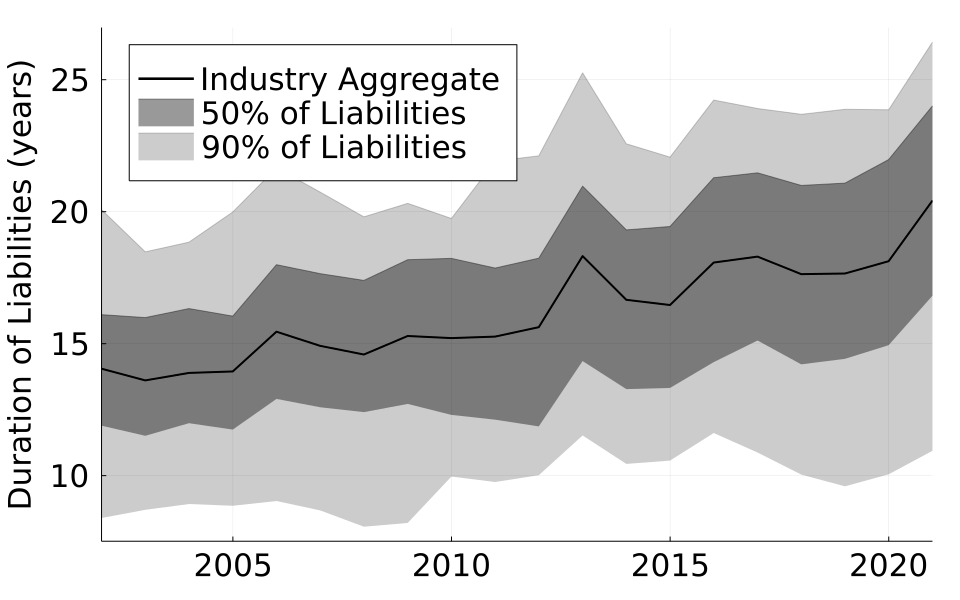

In [61]:
# 
@df L_year plot(Date.(:year, 12,31), :D_L, size = (960, 480), html_output_format=:png, width = 2, c = :black, 
    label = "Industry Aggregate", legend = :topleft)

bound = 0.5
u = zeros(length(unique(L_NAIC_year[:, :year])))
d = zeros(length(unique(L_NAIC_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(L_NAIC_year, [:year, :D_L]), :year))

    dist = zeros(length(dg[:, :D_L]), length(dg[:, :D_L]))
    vol = zeros(length(dg[:, :D_L]), length(dg[:, :D_L]))
    tot_vol = sum(dg[:, :Value_L])
    avg = sum(dg[:, :Value_L] .* dg[:, :D_L]) / sum(dg[:, :Value_L])

    above = dg[dg[:, :D_L] .>= avg, :]
    below = dg[dg[:, :D_L] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :Value_L]) .+ sum(below[:, :Value_L])) ./ tot_vol) .>= (0.5 + bound / 2)), :D_L]
    d[y] = below[findlast((cumsum(below[:, :Value_L]) ./ tot_vol) .<= (0.5 - bound / 2)), :D_L]

end
plot!(Date.(L_year[:, :year], 12,31), u,               fill = [L_year[:, :D_L] u], alpha = 0.4, c = :black, label = "50% of Liabilities")
plot!(Date.(L_year[:, :year], 12,31), L_year[:, :D_L], fill = [d L_year[:, :D_L]], alpha = 0.4, c = :black, label = "")

bound = 0.9
u = zeros(length(unique(L_NAIC_year[:, :year])))
d = zeros(length(unique(L_NAIC_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(L_NAIC_year, [:year, :D_L]), :year))

    dist = zeros(length(dg[:, :D_L]), length(dg[:, :D_L]))
    vol = zeros(length(dg[:, :D_L]), length(dg[:, :D_L]))
    tot_vol = sum(dg[:, :Value_L])
    avg = sum(dg[:, :Value_L] .* dg[:, :D_L]) / sum(dg[:, :Value_L])

    above = dg[dg[:, :D_L] .>= avg, :]
    below = dg[dg[:, :D_L] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :Value_L]) .+ sum(below[:, :Value_L])) ./ tot_vol) .>= (0.5 + bound / 2)), :D_L]
    d[y] = below[replace(
            [findlast((cumsum(below[:, :Value_L]) ./ tot_vol) .<= (0.5 - bound / 2))],
            nothing => 1)[1], :D_L]

end
plot!(Date.(L_year[:, :year], 12,31), u,               fill = [L_year[:, :D_L] u], alpha = 0.2, c = :black, label = "90% of Liabilities")
plot!(Date.(L_year[:, :year], 12,31), L_year[:, :D_L], fill = [d L_year[:, :D_L]], alpha = 0.2, c = :black, label = "",
    ylab = "Duration of Liabilities (years)", 
    size = (800, 600), html_output_format=:png, margin = 5mm)

plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))
png("Duration Liabilities")

plot!(size = (2*800, 2*600),margin = 6mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Duration Liabilities big")

plot!(size = (960, 600), html_output_format=:png, margin = 5mm)
png("Duration Liabilities wide")
plot!()

In [62]:
@combine(@subset(L_year, :year .>= 2010), m = mean(:D_L))

,m
,Float64
1,17.5038


# All Companies

In [63]:
# load asset duration
balance_assets_all = CSV.read("Balance Sheet Asset Duration T - corrected for MBS", DataFrame)
balance_assets_all = @subset(balance_assets_all, :year .>= 2004)
@transform!(balance_assets_all, duration = ifelse.(isnan.(coalesce.(:duration, NaN)), 0.0, :duration))

balance_assets_all = @combine(groupby(balance_assets_all, [:NAIC_no, :year]),
    D_A = sum(:duration .* :value) / sum(:value),
    V_A = sum(:value),
    missingvalue = sum(:value[ismissing.(:duration)]), 
    V_A_bond = sum(:value .* (:asset_type .== "Bonds")),
    V_A_deriv = sum(:value .* (:asset_type .== "Derivatives")),
)

@transform!(balance_assets_all, D_A = ifelse.(isnan.(coalesce.(:D_A, NaN)), 0.0, :D_A))

balance_assets_all = innerjoin(balance_assets_all, L_NAIC_year, on = [:NAIC_no, :year => :year])

# the agg reserves have strange errors!
reserves_agg = CSV.read("C24341.csv", DataFrame)[:, [4, 6, 9, 12]]
@transform!(reserves_agg, Nets = cols(3) .+ cols(4) .+ 0.0)
rename!(reserves_agg, [1 => :NAIC_no])
rename!(reserves_agg, [2 => :year])
reserves_agg = reserves_agg[:, [1, 2, 5]]

balance_assets_all = innerjoin(balance_assets_all, reserves_agg, on = [:NAIC_no, :year])

balance_assets_all = innerjoin(
    balance_assets_all, 
    @combine(groupby(@subset(reserves, ((:Line .== 1) .| (:Line .== 2))), [:NAIC_no, :Year]), 
        Totals = sum(:Totals) .* 1.0), 
    on = [:NAIC_no, :year => :Year])

@transform!(balance_assets_all, 
    G = :D_A .- (min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Value_L) ./ :V_A .* :D_L,
    D_E = (:V_A .* :D_A .- (min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Value_L) .* :D_L) ./
        (:V_A .- min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Value_L),
    E =  :V_A .- min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Value_L,
    lev = :V_A ./ (:V_A .- min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Value_L),
    capratio = (min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Value_L) ./ :V_A, 
    c1 = :Value_L ./ :V_A
    
#     G = :D_A .- min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Reserve_L ./ :V_A .* :D_L, 
#     D_E = :V_A ./ (:V_A .- min.(:Nets, :Reserve_L .+ :ResVar_L)) .* 
#         (:D_A .- min.(:Nets, :Reserve_L .+ :ResVar_L) ./ :Totals .* :Reserve_L ./ :V_A .* :D_L), 
#     E = (:V_A .- min.(:Nets, :Reserve_L .+ :ResVar_L)),
#     lev = :V_A ./ (:V_A .- min.(:Nets, :Reserve_L .+ :ResVar_L)),
)

# balance_assets_all = @subset(balance_assets_all, abs.(:E ./ :V_A) .< 1.2)

@transform!(balance_assets_all, G = ifelse.(isnan.(coalesce.(:G, NaN)), 0.0, :G));
@transform!(balance_assets_all, G = ifelse.(isinf.(coalesce.(:G, NaN)), 0.0, :G));
@transform!(balance_assets_all, D_E = ifelse.(isnan.(coalesce.(:D_E, NaN)), 0.0, :D_E));
@transform!(balance_assets_all, D_E = ifelse.(isinf.(coalesce.(:D_E, NaN)), 0.0, :D_E));
@transform!(balance_assets_all, E = ifelse.(isnan.(coalesce.(:E, NaN)), 0.0, :E));
@transform!(balance_assets_all, E = ifelse.(isinf.(coalesce.(:E, NaN)), 0.0, :E));
@transform!(balance_assets_all, V_A = ifelse.(isnan.(coalesce.(:V_A, NaN)), 0.0, :V_A))
@transform!(balance_assets_all, lev = ifelse.(isnan.(coalesce.(:lev, NaN)), 0.0, :lev));
@transform!(balance_assets_all, lev = ifelse.(isinf.(coalesce.(:lev, NaN)), 0.0, :lev));
@transform!(balance_assets_all, capratio = ifelse.(isnan.(coalesce.(:capratio, NaN)), 0.0, :capratio));
@transform!(balance_assets_all, capratio = ifelse.(isinf.(coalesce.(:capratio, NaN)), 0.0, :capratio));

# annuity HHI
HHI_NAIC_year = CSV.read("HHI_NAIC_year.csv", DataFrame)
balance_assets_all = leftjoin(balance_assets_all, HHI_NAIC_year, on = [:NAIC_no, :year]);

# fraction VA
reserves_VA = sort(@transform(
    innerjoin(
        @combine(groupby(@subset(reserves, .!((
            (coalesce.(:Method, "") .!= "AG33") .& 
            (coalesce.(:Method, "") .!= "AG43") .& 
            true))), [:NAIC_no, :Year]), VA = sum(:Totals)),
        @combine(groupby(reserves, [:NAIC_no, :Year]), Totals = sum(:Totals)),
        on = [:NAIC_no, :Year]),
    fracVA = :VA ./ :Totals), :fracVA, rev = true)
balance_assets_all = leftjoin(balance_assets_all, select(reserves_VA, [:NAIC_no, :Year, :fracVA]), 
    on = [:NAIC_no, :year => :Year])
@transform!(balance_assets_all, fracVA = max.(0, coalesce.(:fracVA, 0.0)))

# fraction Imm
reserves_VA = sort(@transform(
    innerjoin(
        @combine(groupby(@subset(reserves, .!((
            (:Line .!= 2) .& 
            (:ImmDef .!= "Immediate") .& 
            true))), [:NAIC_no, :Year]), Imm = sum(:Totals)),
        @combine(groupby(reserves, [:NAIC_no, :Year]), Totals = sum(:Totals)),
        on = [:NAIC_no, :Year]),
    fracImm = :Imm ./ :Totals), :fracImm, rev = true)
balance_assets_all = leftjoin(balance_assets_all, select(reserves_VA, [:NAIC_no, :Year, :fracImm]), 
    on = [:NAIC_no, :year => :Year])
@transform!(balance_assets_all, fracImm = max.(0, coalesce.(:fracImm, 0.0)))

# fraction life insurance
reserves_VA = sort(@transform(
    innerjoin(
        @combine(groupby(@subset(reserves, .!((
            (:Line .!= 1) .& 
            true))), [:NAIC_no, :Year]), Life = sum(:Totals)),
        @combine(groupby(reserves, [:NAIC_no, :Year]), Totals = sum(:Totals)),
        on = [:NAIC_no, :Year]),
    fracLife = :Life ./ :Totals), :fracLife, rev = true)
balance_assets_all = leftjoin(
    balance_assets_all,
    select(reserves_VA, [:NAIC_no, :Year, :fracLife]), 
    on = [:NAIC_no, :year => :Year])
@transform!(balance_assets_all, fracLife = coalesce.(:fracLife, 0.0))
@transform!(balance_assets_all, fracLife = ifelse.(:Totals .== 0, 0.0, :fracLife))

# fraction ann
reserves_VA = sort(@transform(
    innerjoin(
        @combine(groupby(@subset(reserves, .!((
            (:Line .!= 2) .& 
            true))), [:NAIC_no, :Year]), Ann = sum(:Totals)),
        @combine(groupby(reserves, [:NAIC_no, :Year]), Totals = sum(:Totals)),
        on = [:NAIC_no, :Year]),
    fracAnn = :Ann ./ :Totals), :fracAnn, rev = true)
balance_assets_all = leftjoin(
    balance_assets_all,
    select(reserves_VA, [:NAIC_no, :Year, :fracAnn]), 
    on = [:NAIC_no, :year => :Year])
@transform!(balance_assets_all, fracAnn = coalesce.(:fracAnn, 0.0))
@transform!(balance_assets_all, fracAnn = ifelse.(:Totals .== 0, 0.0, :fracAnn))

@transform!(balance_assets_all, betahat = 0.211 .* :fracAnn .+ -0.025 .* :fracLife)

describe(balance_assets_all)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Union…,Real,Int64,Type
1,NAIC_no,73161.2,31119,69272.0,99937,0,Int64
2,year,2011.48,2004,2012.0,2019,0,Int64
3,D_A,7.32378,0.0,7.01956,26.7452,0,Float64
4,V_A,6.56788e9,0.0,4.19814e8,2.6668e11,0,Float64
5,missingvalue,0.0,0.0,0.0,0.0,0,Float64
6,V_A_bond,4.76683e9,0.0,3.31157e8,1.89018e11,0,Float64
7,V_A_deriv,6.34874e7,-1.18176e7,0.0,1.30489e10,0,Float64
8,DD_L,7.70129e10,0.0,4.6239e9,5.88853e12,180,"Union{Missing, Float64}"
9,DC_L,37367.6,110.148,22208.6,6.5843e5,180,"Union{Missing, Float64}"


In [64]:
@combine(groupby(balance_assets_all, :year), DD_E = sum(:D_E .* :E))

,year,DD_E
,Int64,Float64
1,2004,4.04638e12
2,2005,1.98758e12
3,2006,4.37838e12
4,2007,4.75675e12
5,2008,6.09047e11
6,2009,-3.79151e11
7,2010,4.41669e11
8,2011,-1.51776e12
9,2012,-1.17028e13


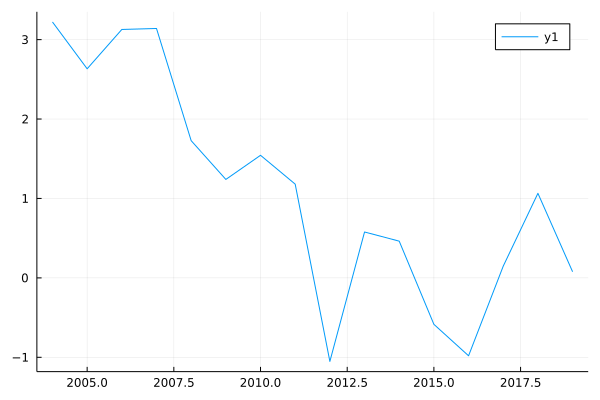

In [65]:
list = @subset(balance_assets_all, (:fracImm .>= 0.5) .& (:year .== 2008))[:, :NAIC_no]
balance_assets_all[!, :highImm] = [n ∈ list for n in balance_assets_all[:, :NAIC_no]]

@df @combine(groupby(@subset(balance_assets_all, :highImm), :year), G = sum(:V_A .* :G) ./ sum(:V_A)) plot(:year, :G)

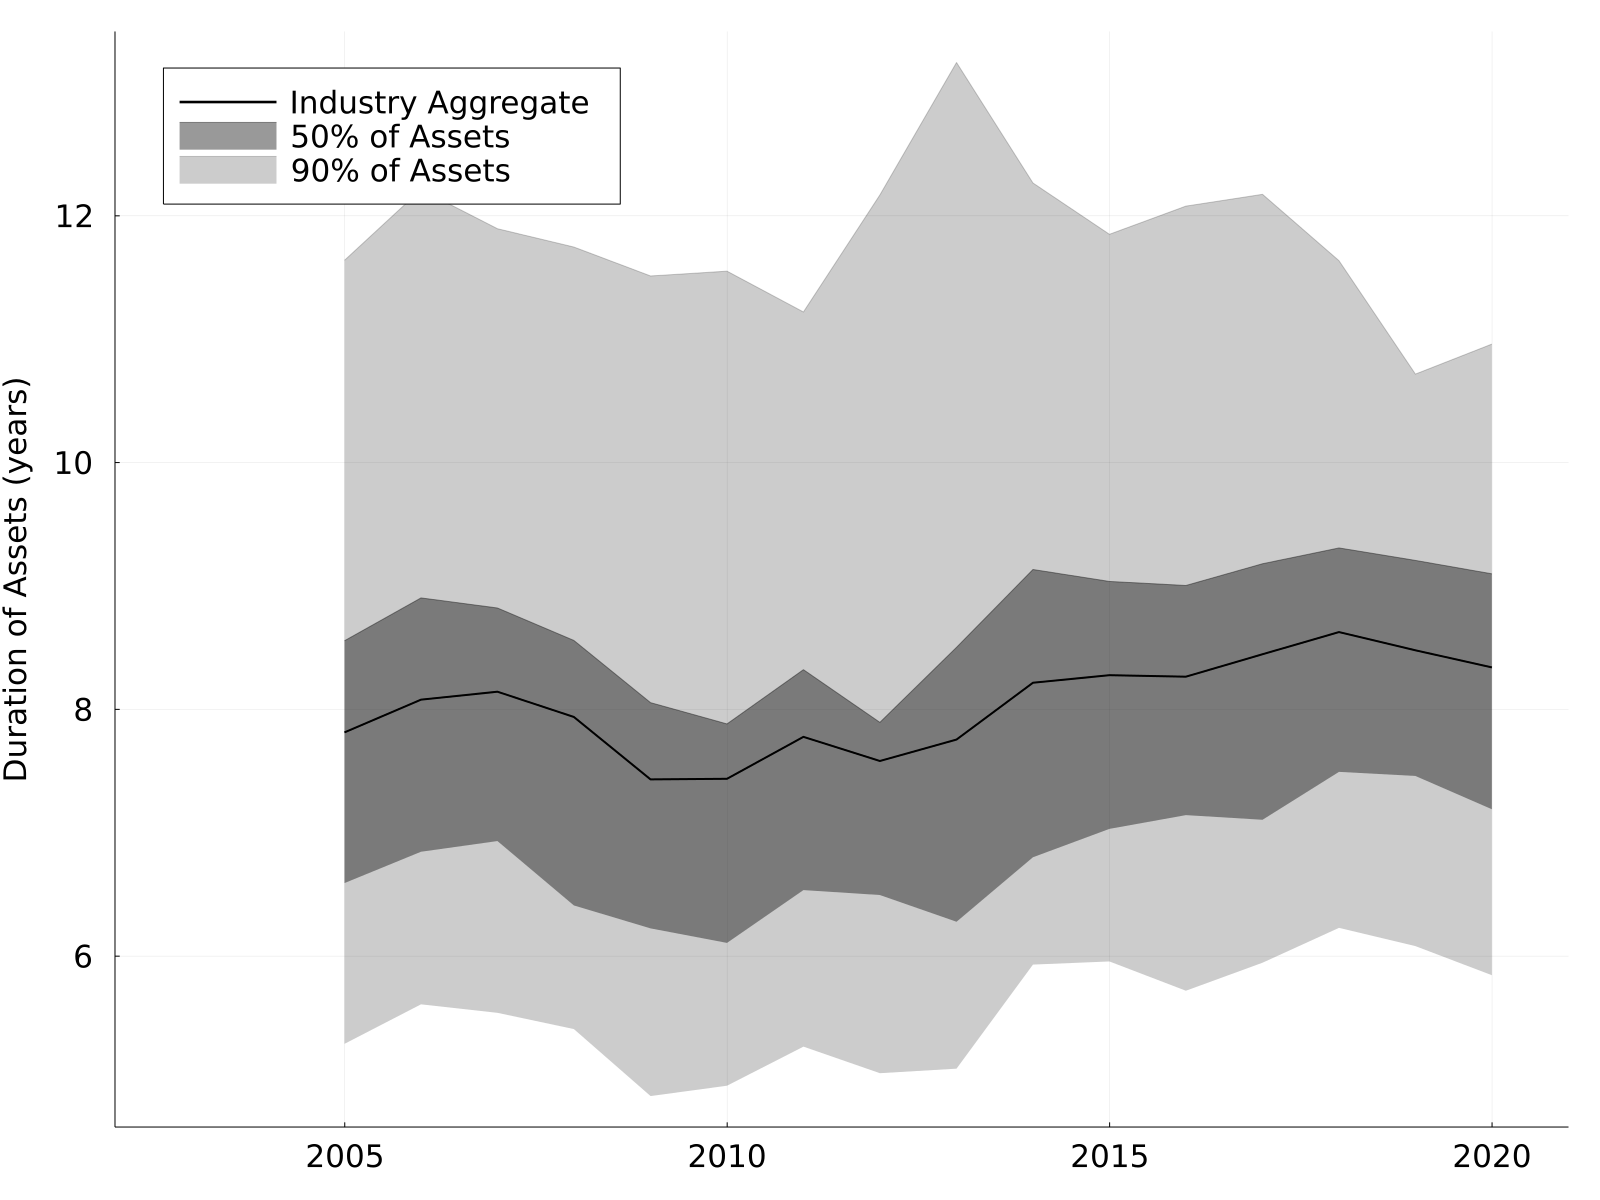

In [66]:
#
df = @subset(@combine(groupby(balance_assets_all, [:year, :NAIC_no]), 
    V_A = sum(:V_A), 
    missingvalue = sum(:V_A[ismissing.(:D_A)]), 
    D_A = (all(ismissing, :D_A) || sum(:V_A) == 0) ? 0. : sum(
        skipmissing(:V_A .* :D_A)) / sum(:V_A)
    ), :year .>= 2004)

df_year = @combine(groupby(df, :year), D_A = sum(skipmissing(:V_A .* :D_A)) / sum(:V_A))

@df df_year plot(Date.(:year, 12,31), :D_A, label = "Industry Aggregate", legend = :topleft, c = :black, width = 2)

bound = 0.5
u = zeros(length(unique(df_year[:, :year])))
d = zeros(length(unique(df_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(df, [:year, :D_A]), :year))

    dist = zeros(length(dg[:, :D_A]), length(dg[:, :D_A]))
    vol = zeros(length(dg[:, :D_A]), length(dg[:, :D_A]))
    tot_vol = sum(dg[:, :V_A])
    avg = sum(dg[:, :V_A] .* dg[:, :D_A]) / sum(dg[:, :V_A])

    above = dg[dg[:, :D_A] .>= avg, :]
    below = dg[dg[:, :D_A] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :V_A]) .+ sum(below[:, :V_A])) ./ tot_vol) .>= (0.5 + bound / 2)), :D_A]
    d[y] = below[findlast((cumsum(below[:, :V_A]) ./ tot_vol) .<= (0.5 - bound / 2)), :D_A]

end
plot!(Date.(df_year[:, :year], 12,31), u,                     fill = [df_year[:, :D_A] u], alpha = 0.4, c = :black, label = "50% of Assets")
plot!(Date.(df_year[:, :year], 12,31), df_year[:, :D_A], fill = [d df_year[:, :D_A]], alpha = 0.4, c = :black, label = "")

bound = 0.9
u = zeros(length(unique(df_year[:, :year])))
d = zeros(length(unique(df_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(df, [:year, :D_A]), :year))

    dist = zeros(length(dg[:, :D_A]), length(dg[:, :D_A]))
    vol = zeros(length(dg[:, :D_A]), length(dg[:, :D_A]))
    tot_vol = sum(dg[:, :V_A])
    avg = sum(dg[:, :V_A] .* dg[:, :D_A]) / sum(dg[:, :V_A])

    above = dg[dg[:, :D_A] .>= avg, :]
    below = dg[dg[:, :D_A] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :V_A]) .+ sum(below[:, :V_A])) ./ tot_vol) .>= (0.5 + bound / 2)), :D_A]
    d[y] = below[findlast((cumsum(below[:, :V_A]) ./ tot_vol) .<= (0.5 - bound / 2)), :D_A]

end
plot!(Date.(df_year[:, :year], 12,31), u,                     fill = [df_year[:, :D_A] u], alpha = 0.2, c = :black, label = "90% of Assets")
plot!(Date.(df_year[:, :year], 12,31), df_year[:, :D_A], fill = [d df_year[:, :D_A]], alpha = 0.2, c = :black, label = "")
plot!(ylab = "Duration of Assets (years)", xlim = (2000,2020), 
    xticks = 2000:5:2020,
    size = (800, 600), html_output_format=:png, margin = 5mm)
plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

png("Duration Assets")

plot!(size = (960, 600), html_output_format=:png, margin = 5mm)
png("Duration Assets wide")

plot!(size = (2*800, 2*600),margin = 6mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Duration Assets big")
plot!()

In [67]:
change = @combine(groupby(df, :NAIC_no), D_A_diff = :D_A[end] - :D_A[1], V_A = :V_A[end])
sort!(change, :V_A, rev = true)

,NAIC_no,D_A_diff,V_A
,Int64,Float64,Float64
1,69345,0.0341725,2.6668e11
2,67091,-0.127104,2.48279e11
3,65978,-0.602212,2.42826e11
4,65935,1.78803,1.90273e11
5,66915,0.146052,1.67976e11
6,68241,0.38935,1.38645e11
7,60488,-1.71676,1.30164e11
8,90611,-0.91586,1.21869e11
9,91596,1.78801,1.09318e11


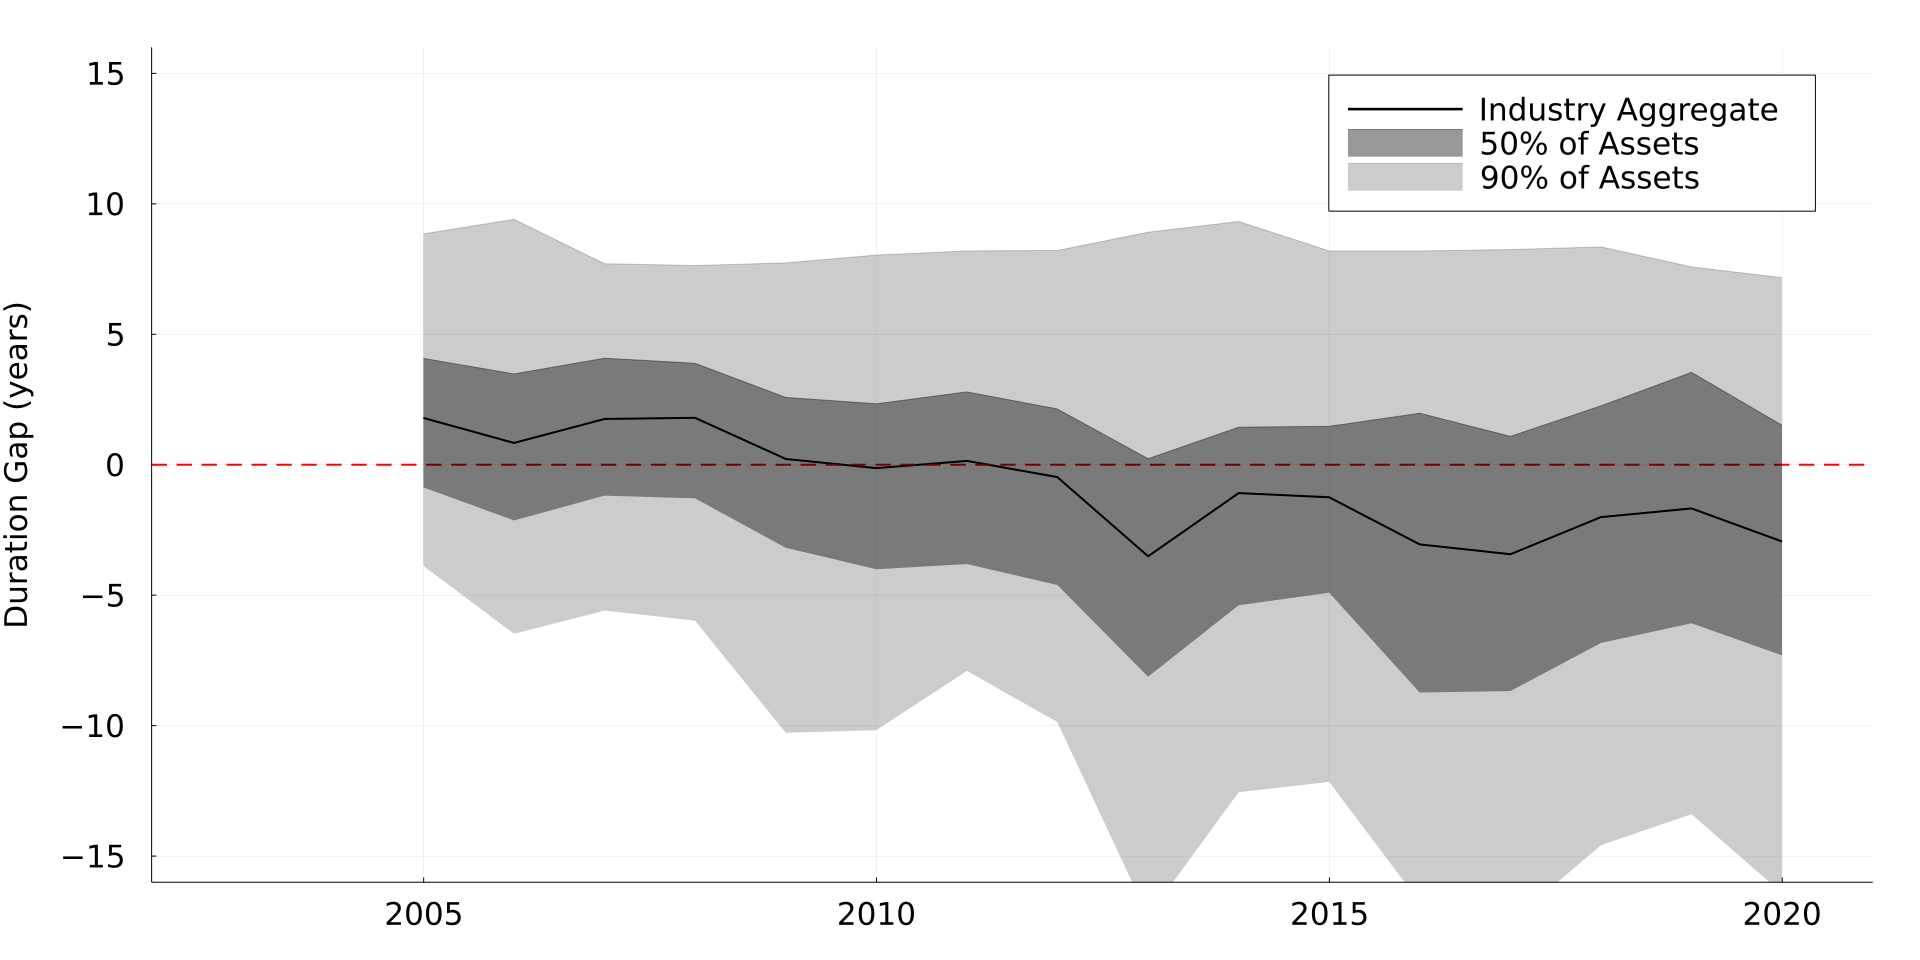

In [68]:
# 
balance_assets_year = @combine(groupby(balance_assets_all, :year), G = sum(:G .* :V_A) / sum(:V_A))

@df balance_assets_year plot(Date.(:year, 12,31), :G, size = (960, 480), html_output_format=:png, width = 2, c = :black, 
    label = "Industry Aggregate", legend = :topright, ylim = (-16,16), ylab = "Duration Gap (years)",)
plot!([Date(2000, 12,31), Date(2020, 12,31)], [0, 0], xlim = (2000,2020), color = :red, linestyle = :dash, width = 2, label = "",
    xticks = 2000:5:2020,
    size = (800, 600), html_output_format=:png, margin = 5mm)
plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

png("Duration Gap agg")
plot!(size = (2 * 960, 2 * 480), html_output_format=:png, margin = 5mm)
png("Duration Gap agg big")

plot!(size = (2 * 960, 2 * 480),margin = 10mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Duration Gap agg wide big")

bound = 0.5
u = zeros(length(unique(balance_assets_year[:, :year])))
d = zeros(length(unique(balance_assets_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(balance_assets_all, [:year, :G]), :year))

    dist = zeros(length(dg[:, :G]), length(dg[:, :G]))
    vol = zeros(length(dg[:, :G]), length(dg[:, :G]))
    tot_vol = sum(dg[:, :V_A])
    avg = sum(dg[:, :V_A] .* dg[:, :G]) / sum(dg[:, :V_A])

    above = dg[dg[:, :G] .>= avg, :]
    below = dg[dg[:, :G] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :V_A]) .+ sum(below[:, :V_A])) ./ tot_vol) .>= (0.5 + bound / 2)), :G]
    d[y] = below[findlast((cumsum(below[:, :V_A]) ./ tot_vol) .<= (0.5 - bound / 2)), :G]

end
plot!(Date.(balance_assets_year[:, :year], 12, 31), u,               fill = [balance_assets_year[:, :G] u], alpha = 0.4, c = :black, label = "50% of Assets")
plot!(Date.(balance_assets_year[:, :year], 12, 31), balance_assets_year[:, :G], fill = [d balance_assets_year[:, :G]], alpha = 0.4, c = :black, label = "")

bound = 0.9
u = zeros(length(unique(balance_assets_year[:, :year])))
d = zeros(length(unique(balance_assets_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(balance_assets_all, [:year, :G]), :year))

    dist = zeros(length(dg[:, :G]), length(dg[:, :G]))
    vol = zeros(length(dg[:, :G]), length(dg[:, :G]))
    tot_vol = sum(dg[:, :V_A])
    avg = sum(dg[:, :V_A] .* dg[:, :G]) / sum(dg[:, :V_A])

    above = dg[dg[:, :G] .>= avg, :]
    below = dg[dg[:, :G] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :V_A]) .+ sum(below[:, :V_A])) ./ tot_vol) .>= (0.5 + bound / 2)), :G]
    d[y] = below[replace(
            [findlast((cumsum(below[:, :V_A]) ./ tot_vol) .<= (0.5 - bound / 2))],
            nothing => 1)[1], :G]

end
plot!(Date.(balance_assets_year[:, :year], 12, 31), u,               fill = [balance_assets_year[:, :G] u], alpha = 0.2, c = :black, label = "90% of Assets")
plot!(Date.(balance_assets_year[:, :year], 12, 31), balance_assets_year[:, :G], fill = [d balance_assets_year[:, :G]], alpha = 0.2, c = :black, label = "",
    ylab = "Duration Gap (years)",
    size = (800, 600), html_output_format=:png, margin = 5mm)

plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

png("Duration Gap")

plot!(size = (2 * 800, 2 * 600), html_output_format=:png, margin = 5mm)

png("Duration Gap big")

plot!(size = (960, 480), html_output_format=:png, margin = 5mm)
png("Duration Gap wide")

plot!(size = (2 * 960, 2 * 480),margin = 10mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Duration Gap wide big")


plot!()

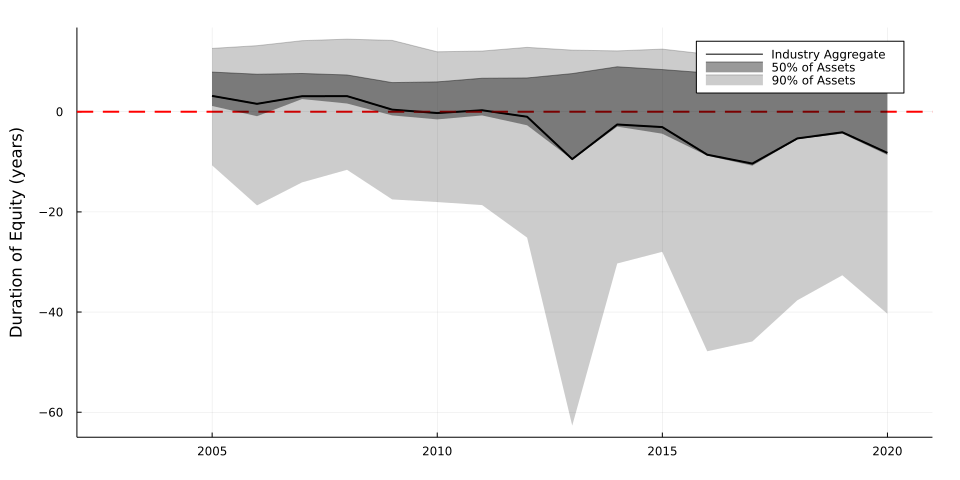

In [88]:
# 
balance_assets_year = @combine(groupby(balance_assets_all, :year), D_E = sum(:D_E .* :E) / sum(:E))

@df balance_assets_year plot(Date.(:year, 12,31), :D_E, size = (960, 480), html_output_format=:png, width = 2, c = :black, 
    label = "Industry Aggregate", legend = :topright)
plot!([Date(2000, 12,31), Date(2020, 12,31)], [0, 0], xlim = (2000,2020), color = :red, linestyle = :dash, width = 2, label = "",
    xticks = 2000:5:2020,
    size = (800, 600), html_output_format=:png, margin = 5mm)

plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

png("Duration Equity agg")
plot!(size = (2 * 960, 2 * 480), html_output_format=:png, margin = 5mm)
png("Duration Equity agg big")

bound = 0.5
u = zeros(length(unique(balance_assets_year[:, :year])))
d = zeros(length(unique(balance_assets_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(balance_assets_all, [:year, :D_E]), :year))

    dist = zeros(length(dg[:, :D_E]), length(dg[:, :D_E]))
    vol = zeros(length(dg[:, :D_E]), length(dg[:, :D_E]))
    tot_vol = sum(dg[:, :E])
    avg = sum(dg[:, :E] .* dg[:, :D_E]) / sum(dg[:, :E])

    above = dg[dg[:, :D_E] .>= avg, :]
    below = dg[dg[:, :D_E] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :E]) .+ sum(below[:, :E])) ./ tot_vol) .>= (0.5 + bound / 2)), :D_E]
    d[y] = below[findlast((cumsum(below[:, :E]) ./ tot_vol) .<= (0.5 - bound / 2)), :D_E]

end
plot!(Date.(balance_assets_year[:, :year], 12,31), u,               fill = [balance_assets_year[:, :D_E] u], alpha = 0.4, c = :black, label = "50% of Assets")
plot!(Date.(balance_assets_year[:, :year], 12,31), balance_assets_year[:, :D_E], fill = [d balance_assets_year[:, :D_E]], alpha = 0.4, c = :black, label = "")

bound = 0.9
u = zeros(length(unique(balance_assets_year[:, :year])))
d = zeros(length(unique(balance_assets_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(balance_assets_all, [:year, :D_E]), :year))

    dist = zeros(length(dg[:, :D_E]), length(dg[:, :D_E]))
    vol = zeros(length(dg[:, :D_E]), length(dg[:, :D_E]))
    tot_vol = sum(dg[:, :E])
    avg = sum(dg[:, :E] .* dg[:, :D_E]) / sum(dg[:, :E])

    above = dg[dg[:, :D_E] .>= avg, :]
    below = dg[dg[:, :D_E] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :E]) .+ sum(below[:, :E])) ./ tot_vol) .>= (0.5 + bound / 2)), :D_E]
    d[y] = below[replace(
            [findlast((cumsum(below[:, :E]) ./ tot_vol) .<= (0.5 - bound / 2))],
            nothing => 1)[1], :D_E]

end
plot!(Date.(balance_assets_year[:, :year], 12,31), u,               fill = [balance_assets_year[:, :D_E] u], alpha = 0.2, c = :black, label = "90% of Assets")
plot!(Date.(balance_assets_year[:, :year], 12,31), balance_assets_year[:, :D_E], fill = [d balance_assets_year[:, :D_E]], alpha = 0.2, c = :black, label = "",
    ylab = "Duration of Equity (years)", xlim = (2000,2020), 
    xticks = 2000:5:2020,
    size = (800, 600), html_output_format=:png, margin = 5mm)

plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

png("Duration Equity")

plot!(size = (2 * 800, 2 * 600), html_output_format=:png, margin = 5mm)

png("Duration Equity big")

plot!(size = (2 * 960, 2 * 480), html_output_format=:png, margin = 5mm)
png("Duration Equity wide big")

plot!(size = (960, 480), html_output_format=:png, margin = 5mm)
png("Duration Equity wide")
plot!()

In [70]:
NAIC_mutuals = [
#     71412, # Mutual of Omaha # all accident and health
    
    65935, # Mass Mut
    
    67091, # Northwestern
    87734, # Northern Life Insurance Co.
    
    64246, # Guardian Life Ins Co. of Am
    75337, # Family Security Life Ins Co.
    77496, # Guaranty Insurance & Annuities
    75817, # Guaranty National Life Ins Co.
    14029, # Paragon Life Ins Co of Indiana
    
    56014, # Thrivent Financial for Lutherans # has no asset info!
    97721, # Thrivent Life Insurance Co.
    
    70483, # Western & Southern Life Ins Co
    92622, # Western-Southern Life Assr Co.
    62103, # Columbian Mutual Life Ins Co.
    
    62626, # CUNA
    
    63304, # Fidelity Mutual Life
    67288, # Fidelity Sec Life Ins Co of NY
    
    69345, # Teachers Ins & Annty Assn.
    60142, # TIAA-CREF
    60157, # Taylor Life Insurance Co.
    
    66915, # New York Life
    60027, # New South Life
    68723, # New York Life Agents Re
    91596, # New York Life Ins & Annty Corp
    15320, # NTA Life Insurance Co. of NY
]

balance_assets_all[!, :mutual] = [m ∈ NAIC_mutuals for m in balance_assets_all[:, :NAIC_no]];

## Cross-sectional

In [108]:
# join AMB data
amb = CSV.read("KY Insurer extended.csv", DataFrame)
NAICs = @subset(@combine(groupby(dropmissing(amb, :NAIC_no) , :co_num), 
    NAIC_no = unique.(:NAIC_no)[1]), :NAIC_no .!= 0)
amb = innerjoin(select(amb, Not(:NAIC_no)), NAICs, on = :co_num)
dropmissing!(amb, :NAIC_no)
sort!(amb, [:NAIC_no, :fyear])
amb = @subset(amb, (:cp_sur_0 .> 0) .& (:assets_0 .> 0))
amb = select(amb, Not([:co_name, :grp_name]))
@transform!(amb, sur_assets = :assets_0 ./ :cp_sur_0)

rating_dict = Dict(("A++" => 1, "A+" => 2,  "A" => 3,  "A-" => 4,  "B++" => 5, "B+" => 6, "B" => 7, "B-" => 8, 
      "C++" => 9, "C+" => 10, "C" => 11, "C-" => 12, "E" => 13, "F" => 14, "NR" => missing, "..." => missing, ))
guide_dict = Dict(("A++" => 175, "A+" => 160,  "A" => 145,  "A-" => 130))

amb[!, :bestr_num] = [get(rating_dict, s, missing) for s in amb[:, :bestr_0]]
amb[!, :bcarguide] = [get(guide_dict, s, missing) for s in amb[:, :bestr_0]]
amb[!, :bcargap] = (amb[:, :bcar0] .- amb[:, :bcarguide])
@transform!(amb, 
    logassets = log.(:assets_0),
)

balance_assets_amb = innerjoin(balance_assets_all, 
    select(amb, [:NAIC_no, :fyear, :assets_0, :sur_assets, :bcar0, :bcargap, :logassets, :bestr_0, 
        :bestr_num, :dom_st, :rcgain, :ucgain, :sdiv, :nt_gn_0, :cn_rsv, :bs_c_st, :cp_sur_0]),
    on = [:NAIC_no, :year => :fyear])

@transform!(balance_assets_amb, 
    D_E_AMB = :G .* :assets_0 ./ :cp_sur_0,
    lev = ifelse.(:Nets .== 0, 0, :V_A ./ :cp_sur_0),
    DD_E = :G .* :V_A,
    D_E = :G .* :V_A ./ :cp_sur_0
);

In [109]:
balance_assets_year = @combine(groupby(balance_assets_amb, :year), 
    G = sum(:G .* :V_A) / sum(:V_A), V_A = sum(:V_A), cp_sur_0 = sum(:cp_sur_0) * 1000.0)
balance_assets_year = @transform(balance_assets_year, D_E = :G .* :V_A ./ :cp_sur_0)

,year,G,V_A,cp_sur_0,D_E
,Int64,Float64,Float64,Float64,Float64
1,2004,1.17162,1.86232e12,1.84939e11,11.7981
2,2005,0.132068,2.00617e12,1.95464e11,1.3555
3,2006,1.22923,2.13588e12,2.10141e11,12.4938
4,2007,1.2509,2.26587e12,2.28391e11,12.4102
5,2008,-0.411401,2.37959e12,2.19095e11,-4.46822
6,2009,-0.756242,2.48875e12,2.60814e11,-7.21624
7,2010,-0.44898,2.58626e12,2.74778e11,-4.22588
8,2011,-1.25399,2.64422e12,2.74613e11,-12.0746
9,2012,-3.50112,3.31316e12,3.73993e11,-31.016


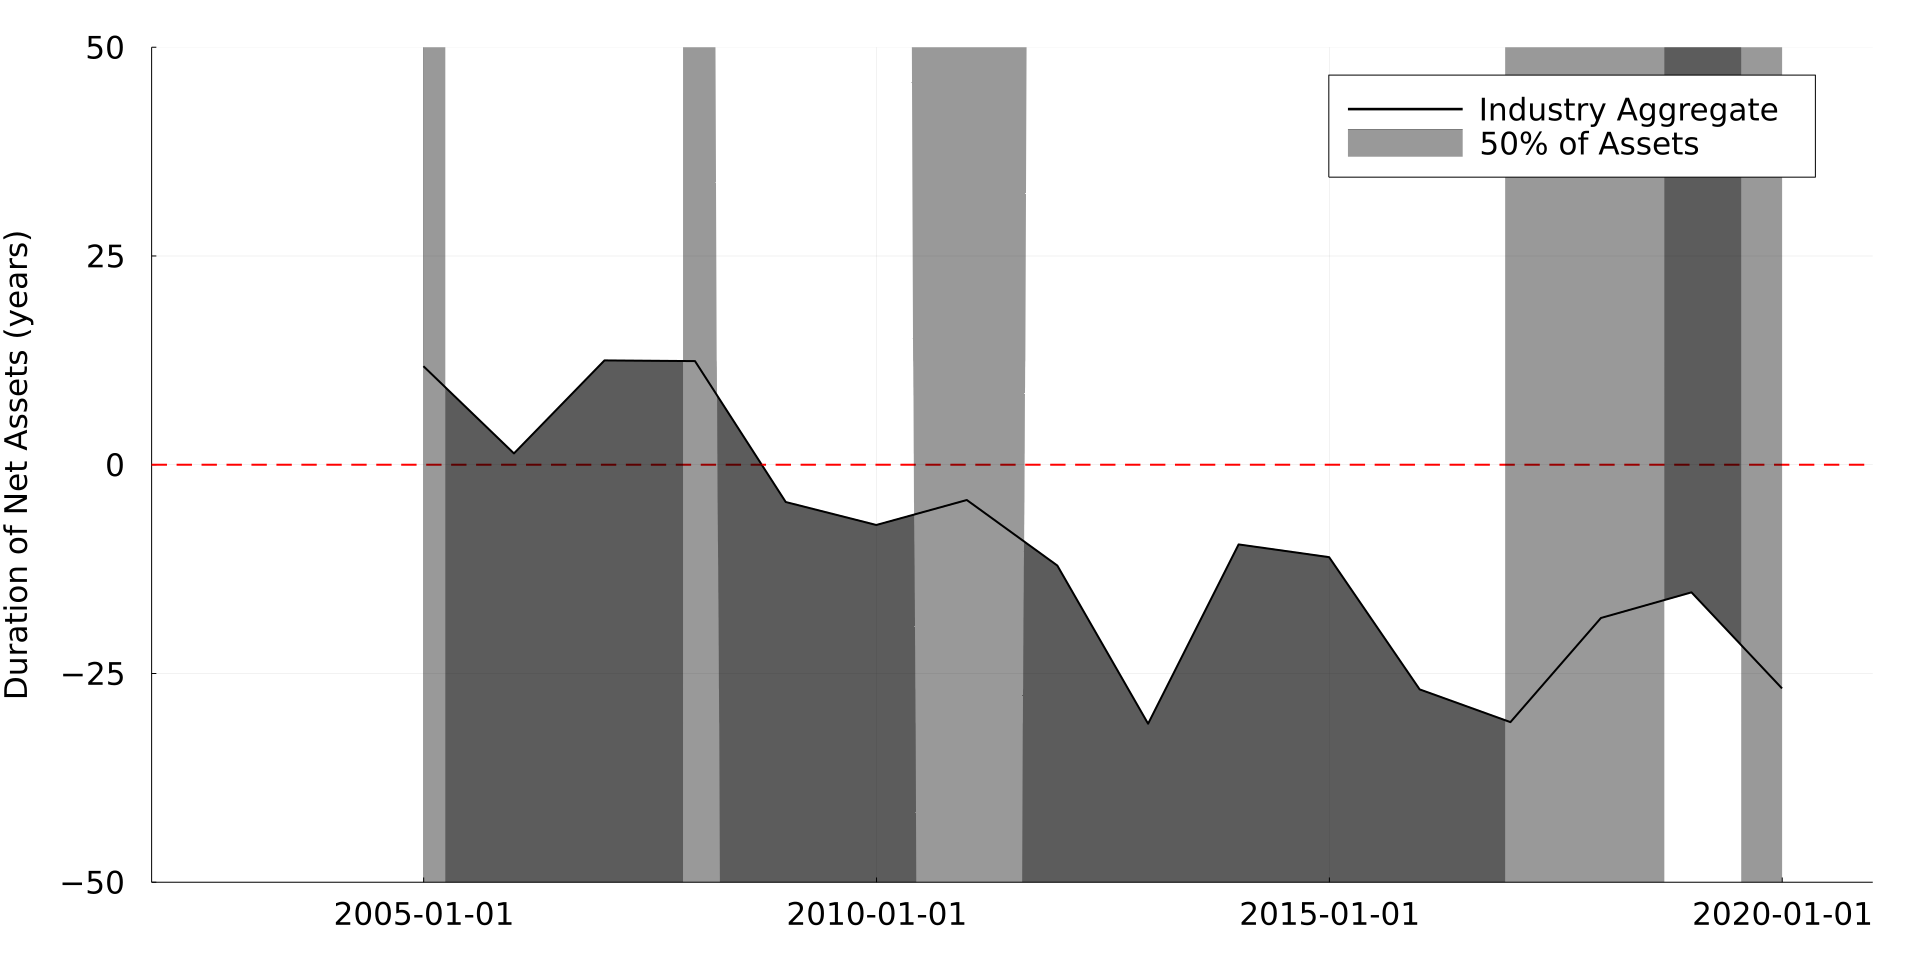

In [84]:
# 
balance_assets_year = @combine(groupby(balance_assets_amb, :year), 
    G = sum(:G .* :V_A) / sum(:V_A), V_A = sum(:V_A), cp_sur_0 = sum(:cp_sur_0) * 1000.0)
balance_assets_year = @transform(balance_assets_year, D_E = :G .* :V_A ./ :cp_sur_0)
    
@df balance_assets_year plot(Date.(:year, 12,31), :D_E, size = (960, 480), html_output_format=:png, width = 2, c = :black, 
    label = "Industry Aggregate", legend = :topright, ylim = (-50,50), ylab = "Duration of Net Assets (years)",)
plot!([Date(2000, 12,31), Date(2020, 12,31)], [0, 0], xlim = (2000,2020), color = :red, linestyle = :dash, width = 2, label = "",
    xticks = 2000:5:2020,
    size = (800, 600), html_output_format=:png, margin = 5mm)
plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

png("Duration Net Assets agg")
plot!(size = (2 * 960, 2 * 480), html_output_format=:png, margin = 10mm)
png("Duration Net Assets agg big")

plot!(size = (960, 480),margin = 10mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Duration Net Assets agg wide")

plot!(size = (2 * 960, 2 * 480),margin = 10mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Duration Net Assets agg wide big")

bound = 0.5
u = zeros(length(unique(balance_assets_year[:, :year])))
d = zeros(length(unique(balance_assets_year[:, :year])))
@showprogress for (y, dg) in enumerate(groupby(sort!(balance_assets_amb, [:year, :DD_E]), :year))

    dist = zeros(length(dg[:, :DD_E]), length(dg[:, :DD_E]))
    vol = zeros(length(dg[:, :DD_E]), length(dg[:, :DD_E]))
    tot_vol = sum(dg[:, :cp_sur_0])
    avg = sum(dg[:, :cp_sur_0] .* dg[:, :DD_E]) / sum(dg[:, :cp_sur_0])

    above = dg[dg[:, :DD_E] .>= avg, :]
    below = dg[dg[:, :DD_E] .<  avg, :]
    u[y] = above[findfirst(((cumsum(above[:, :cp_sur_0]) .+ sum(below[:, :cp_sur_0])) ./ tot_vol) .>= (0.5 + bound / 2)), :DD_E]
    d[y] = below[findlast((cumsum(below[:, :cp_sur_0]) ./ tot_vol) .<= (0.5 - bound / 2)), :DD_E]

end
plot!(Date.(balance_assets_year[:, :year], 12, 31), u,               fill = [balance_assets_year[:, :D_E] u], alpha = 0.4, c = :black, label = "50% of Assets")
plot!(Date.(balance_assets_year[:, :year], 12, 31), balance_assets_year[:, :D_E], fill = [d balance_assets_year[:, :D_E]], alpha = 0.4, c = :black, label = "")

# bound = 0.9
# u = zeros(length(unique(balance_assets_year[:, :year])))
# d = zeros(length(unique(balance_assets_year[:, :year])))
# @showprogress for (y, dg) in enumerate(groupby(sort!(balance_assets_amb, [:year, :DD_E]), :year))

#     dist = zeros(length(dg[:, :DD_E]), length(dg[:, :DD_E]))
#     vol = zeros(length(dg[:, :DD_E]), length(dg[:, :DD_E]))
#     tot_vol = sum(dg[:, :cp_sur_0])
#     avg = sum(dg[:, :cp_sur_0] .* dg[:, :DD_E]) / sum(dg[:, :cp_sur_0])

#     above = dg[dg[:, :DD_E] .>= avg, :]
#     below = dg[dg[:, :DD_E] .<  avg, :]
#     u[y] = above[findfirst(((cumsum(above[:, :cp_sur_0]) .+ sum(below[:, :cp_sur_0])) ./ tot_vol) .>= (0.5 + bound / 2)), :DD_E]
#     d[y] = below[replace(
#             [findlast((cumsum(below[:, :cp_sur_0]) ./ tot_vol) .<= (0.5 - bound / 2))],
#             nothing => 1)[1], :DD_E]

# end
# plot!(Date.(balance_assets_year[:, :year], 12, 31), u,               fill = [balance_assets_year[:, :D_E] u], alpha = 0.2, c = :black, label = "90% of Assets")
# plot!(Date.(balance_assets_year[:, :year], 12, 31), balance_assets_year[:, :D_E], fill = [d balance_assets_year[:, :D_E]], alpha = 0.2, c = :black, label = "",
#     ylab = "Duration of Net Assets (years)",
#     size = (800, 600), html_output_format=:png, margin = 5mm)

# plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
#     xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

# png("Duration Net Assets")

# plot!(size = (2 * 800, 2 * 600), html_output_format=:png, margin = 5mm)

# png("Duration Net Assets big")

# plot!(size = (960, 480), html_output_format=:png, margin = 5mm)
# png("Duration Net Assets wide")

# plot!(size = (2 * 960, 2 * 480),margin = 10mm,
#     xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
# png("Duration Net Assets wide big")

# plot!()

In [74]:
df = @combine(groupby(balance_assets_amb, :year), 
    G = sum(:G .* :V_A) / sum(:V_A), V_A = sum(:V_A), cp_sur_0 = sum(:cp_sur_0) * 1000.0)
df = @transform(df, D_E = :G .* :V_A ./ :cp_sur_0)

@df df plot(Date.(:year, 12,31), :D_E, size = (960, 480), html_output_format=:png, width = 2, c = :black, 
    label = "Industry Aggregate", legend = :topright, ylim = (-32,32), ylab = "Duration of Net Assets (years)",)

plot!([Date(2000, 12,31), Date(2020, 12,31)], [0, 0], xlim = (2000,2020), color = :red, linestyle = :dash, width = 2, label = "",
    xticks = 2000:5:2020,
    size = (800, 600), html_output_format=:png, margin = 5mm)
plot!(xlim = (Date(2001,12,31), Date(2020,12,31)), xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), 
    xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))

plot!(size = (960, 480), html_output_format=:png, margin = 5mm)
png("Duration Gap 2 agg wide")

plot!(size = (2 * 960, 2 * 480),margin = 10mm,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("Duration Gap 2 agg wide big")

In [75]:
4.23999e12 * -2.84767 / 466259587 / 1000.

-25.895644100289566

In [76]:
# regression
balance_assets_amb_avg = @combine(groupby(@subset(balance_assets_amb, :year .> 2011), :NAIC_no), 
    G = mean(:G), 
    fracLife = mean(:fracLife), 
    fracAnn = mean(:fracAnn), 
    fracVA = mean(:fracVA), 
    betahat = mean(:betahat), 
    mutual = mean(:mutual),
    sur_assets = mean(:sur_assets), 
    bcar0 = mean(:bcar0), 
    bestr_num = mean(skipmissing(:bestr_num)), 
    dom_st = :dom_st[1], 
    logassets = mean(:logassets), 
    HHI = mean(:HHI), 
    V_A = mean(:V_A), 
    Nets = mean(:Nets), 
    E = mean(:E), 
    assets_0 = mean(:assets_0), 
    lev = mean(:lev),
    Totals = mean(:Totals),
    )

rr1 = reg(balance_assets_amb_avg, 
    @formula(G ~ lev + fracLife + sur_assets + logassets + fracVA + mutual), Vcov.robust(), weights = :sur_assets)

regtable(rr1, renderSettings = latexOutput("cross-section.tex"), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(rr1, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


------------------------
                   G    
              ----------
                     (1)
------------------------
(Intercept)     8.552***
                 (2.632)
lev                0.000
                 (0.000)
fracLife      -14.484***
                 (1.300)
sur_assets       -0.022*
                 (0.011)
logassets         -0.263
                 (0.161)
fracVA             2.978
                 (5.328)
mutual            -1.683
                 (1.284)
------------------------
Estimator            OLS
------------------------
N                    509
R2                 0.349
------------------------




In [76]:
premiums = CSV.read("annuity premiums.csv", DataFrame)
premiums_naic_year = @combine(groupby(premiums, [:NAIC_no, :year]), premium = sum(:premium))
premiums_naic_year = vcat(premiums_naic_year, 
    [@transform(@subset(premiums_naic_year, :year .== 1996), year = y) for y in 1989:1995]...,
    [@transform(@subset(premiums_naic_year, :year .== 2019), year = y) for y in 2020:2021]...,
)
sort!(premiums_naic_year, [:NAIC_no, :year])

,NAIC_no,year,premium
,Int64,Int64,Float64
1,10091,2003,3.09735e7
2,10091,2004,1.14368e6
3,10091,2005,1.79788e8
4,10091,2006,1.38469e8
5,11133,2001,290647.0
6,11133,2002,692561.0
7,11133,2003,838553.0
8,11133,2004,2.0291e6
9,11133,2005,1.37462e6


## Gap Regressions

In [123]:
#
rr1 = reg(balance_assets_amb, 
    @formula(G ~ lev + fracLife + sur_assets + logassets  + mutual), weights = :sur_assets, save = true)
# rr2 = reg(balance_assets_amb, 
#     @formula(G ~ lev + fracLife + sur_assets + logassets + fracVA + mutual + fe(NAIC_no)), 
#     Vcov.cluster(:NAIC_no), weights = :sur_assets)
rr3 = reg(balance_assets_amb, 
    @formula(G ~ lev + fracLife + sur_assets + logassets  + mutual + fe(year)), 
    Vcov.cluster(:year), weights = :sur_assets, save = true)
rr4 = reg(balance_assets_amb, 
    @formula(G ~ lev + fracLife + sur_assets + logassets  + mutual + fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no, :year), weights = :sur_assets, save = true)

regtable(rr1, rr3, rr4, renderSettings = latexOutput("gap_regressions.tex"), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(rr1, rr3, rr4, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


-------------------------------------------------
                               G                 
              -----------------------------------
                     (1)          (2)         (3)
-------------------------------------------------
(Intercept)     5.362***                         
                 (0.738)                         
lev                0.000        0.000     -0.000*
                 (0.000)      (0.000)     (0.000)
fracLife      -12.231***   -12.066***   -9.928***
                 (0.300)      (0.878)     (2.648)
sur_assets     -0.019***    -0.021***       0.006
                 (0.001)      (0.003)     (0.006)
logassets        -0.081*    -0.130***       0.867
                 (0.043)      (0.049)     (1.076)
mutual          -1.399**    -1.509***       0.000
                 (0.597)      (0.163)       (NaN)
-------------------------------------------------
year                              Yes         Yes
NAIC_no                                       Yes

┌ Error: p value = NaN, but it needs to be non-negative
└ @ RegressionTables C:\Users\Max\.julia\packages\RegressionTables\8zjhJ\src\decorations\default_decorations.jl:5
┌ Error: p value = NaN, but it needs to be non-negative
└ @ RegressionTables C:\Users\Max\.julia\packages\RegressionTables\8zjhJ\src\decorations\default_decorations.jl:5


In [128]:
#
# rr1 = reg(balance_assets_amb, 
#     @formula(G ~ lev + betahat + sur_assets + logassets  + tual), weights = :V_A, save = true)
# rr2 = reg(balance_assets_amb, 
#     @formula(G ~ lev + fracLife + sur_assets + logassets + fracVA + mutual + fe(NAIC_no)), 
#     Vcov.cluster(:NAIC_no), weights = :V_A)
rr3 = reg(balance_assets_amb, 
    @formula(G ~ lev + betahat + sur_assets + logassets  + mutual + fe(year)), 
    Vcov.cluster(:year), weights = :V_A, save = true)
rr4 = reg(balance_assets_amb, 
    @formula(G ~ lev + betahat + sur_assets + logassets  + mutual + fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no, :year), weights = :V_A, save = true)

regtable(rr3, rr4, renderSettings = latexOutput("gap_regressions.tex"), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(rr3, rr4, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


----------------------------------
                       G          
             ---------------------
                   (1)         (2)
----------------------------------
lev          -0.000***       0.000
               (0.000)     (8.676)
betahat      34.400***   24.417***
               (3.598)     (0.000)
sur_assets   -0.078***    -0.080**
               (0.011)     (0.037)
logassets     0.763***      -0.286
               (0.084)     (0.945)
mutual       -5.138***    0.006***
               (0.244)     (0.000)
----------------------------------
year               Yes         Yes
NAIC_no                        Yes
----------------------------------
Estimator          OLS         OLS
----------------------------------
N                5,864       5,860
R2               0.299       0.888
----------------------------------



┌ Warning: estimated covariance matrix of moment conditions not of full rank.
│                  model tests should be interpreted with caution.
└ @ Vcov C:\Users\Max\.julia\packages\Vcov\INqlA\src\utils.jl:5


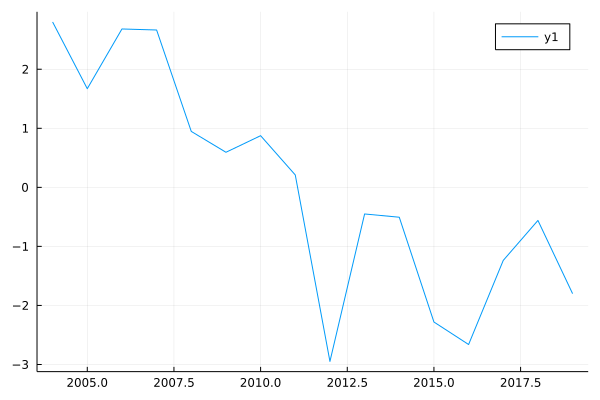

In [78]:

rr5 = reg(balance_assets_amb, @formula(G ~ fe(NAIC_no) + fe(year)), weights = :V_A, save = true)

@df @combine(groupby(rr5.fe, :year), fe_year = :fe_year[1]) plot(:year, :fe_year)

## Time-series

In [80]:
@df @subset(balance_assets_amb, :year .== 2008) histogram(:betahat, bins = 11, weights = :V_A,
    size = (2*800, 2*600),margin = 10mm, c = :gray, label = "Beta Hat in 2008", xlab = "Beta Hat", 
    ylab = "Size-weighted Frequency", yticks = :none, 
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)

png("cross-sec beta-hat")

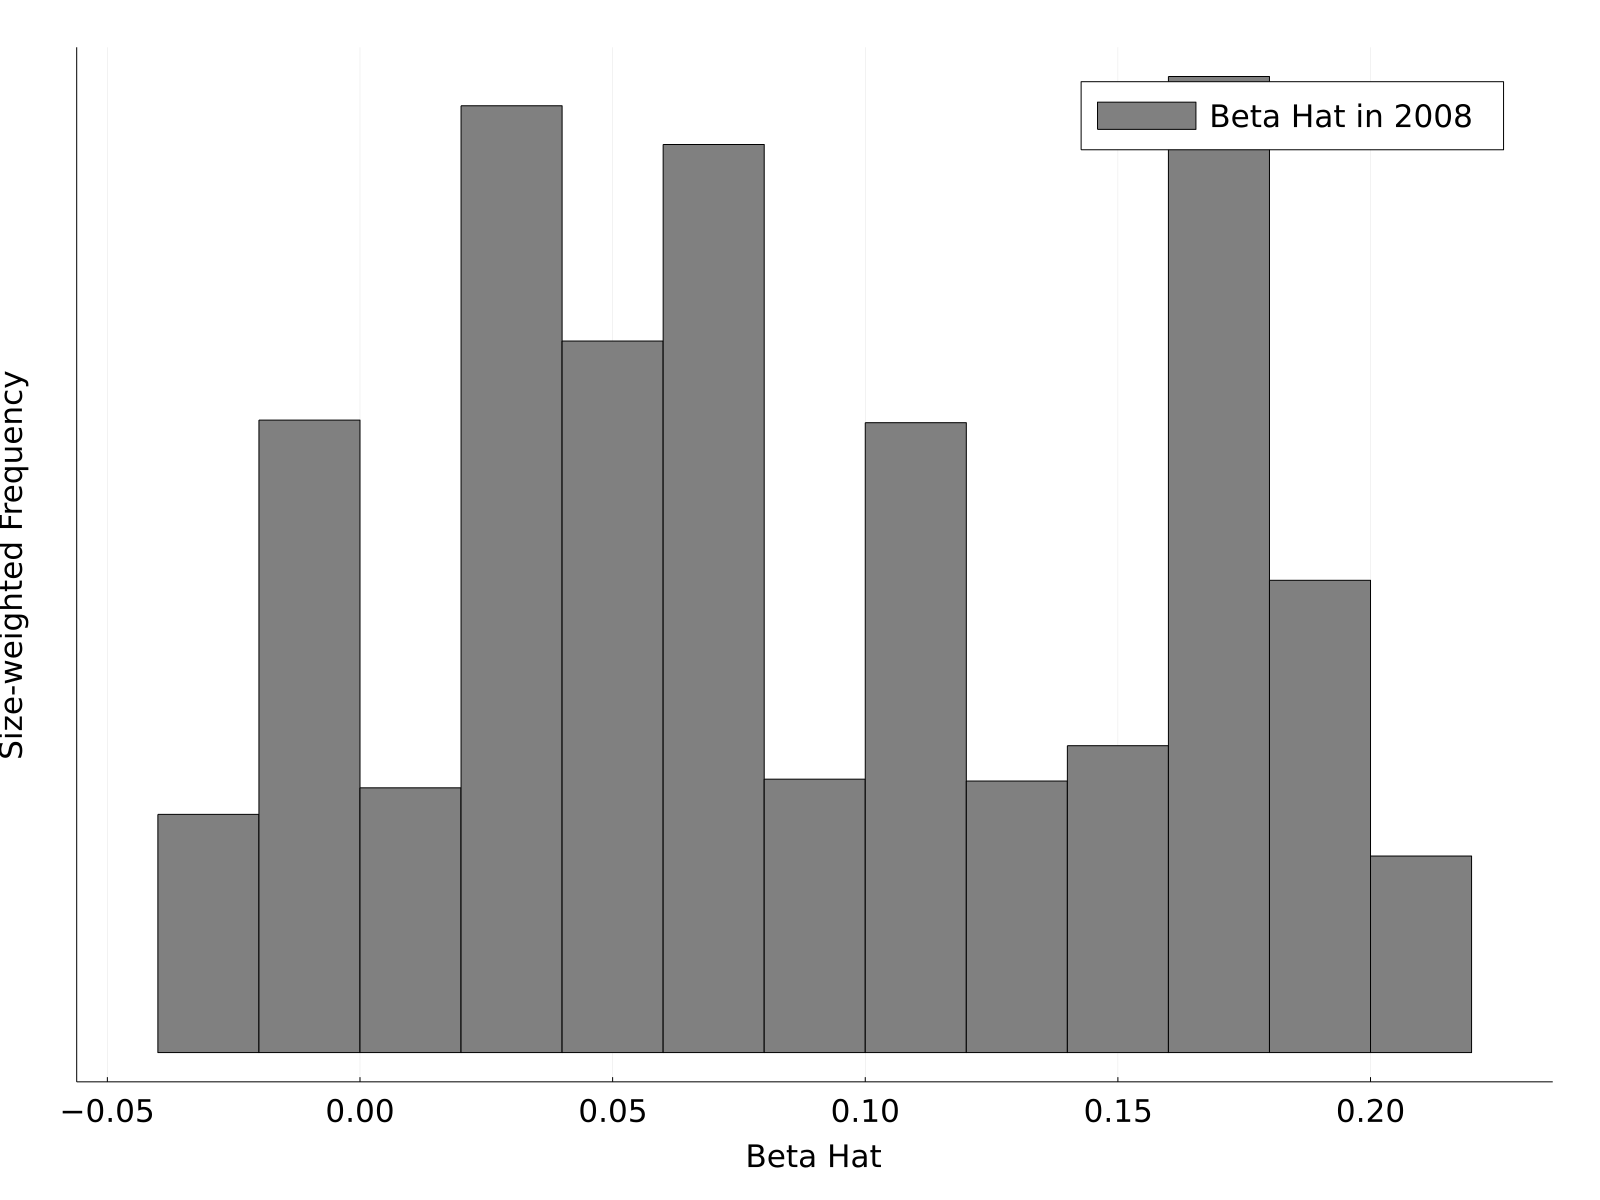

In [93]:
@df @subset(balance_assets_amb, :year .== 2004) histogram(:betahat, bins = 11, weights = :V_A,
    size = (2*800, 2*600),margin = 10mm, c = :gray, label = "Beta Hat in 2008", xlab = "Beta Hat", 
    ylab = "Size-weighted Frequency", yticks = :none, 
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)

In [81]:
sum(@subset(balance_assets_amb, :year .== 2019)[:, :cp_sur_0]) .* 1000.0

4.66259587e11

In [82]:
# regressions
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2008)[:, 
            [:NAIC_no, :bcargap, :bestr_num, :bestr_0, :fracLife, :betahat, :lev, :sur_assets, :logassets, :fracVA, :mutual]], 
        [:bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010,
            :betahat => :betahat2010,
            :lev => :lev2010, :sur_assets => :sur_assets2010, :logassets => :logassets2010, 
            :fracVA => :fracVA2010, :mutual => :mutual2010]),
    on = :NAIC_no)

rr2 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2010), 
    @formula(G ~ (betahat2010 + lev2010 + sur_assets2010 + logassets2010 + mutual2010) & post + fe(NAIC_no)), 
    Vcov.cluster(:NAIC_no), weights = :sur_assets
)

rr3 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2010), 
    @formula(G ~ (betahat2010 + lev2010 + sur_assets2010 + logassets2010 + mutual2010) & post + fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no, :year), weights = :sur_assets
)

regtable(rr2, rr3, renderSettings = latexOutput("time-series post hat.tex"), 
    estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(rr2, rr3, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


--------------------------------------------
                                  G         
                        --------------------
                              (1)        (2)
--------------------------------------------
betahat2010 & post       15.820**   13.458**
                          (6.232)    (6.655)
lev2010 & post              0.000     -0.000
                          (0.000)    (0.000)
sur_assets2010 & post       0.003      0.003
                          (0.003)    (0.003)
logassets2010 & post    -0.256***      0.086
                          (0.053)    (0.204)
mutual2010 & post          -0.090     -0.658
                          (0.876)    (1.072)
--------------------------------------------
NAIC_no                       Yes        Yes
year                                     Yes
--------------------------------------------
Estimator                     OLS        OLS
--------------------------------------------
N                           3,839      3,839
R2       

In [130]:
# regressions
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2008)[:, 
            [:betahat, :NAIC_no, :bcargap, :bestr_num, :bestr_0, :fracLife, :lev, :sur_assets, :logassets, :fracVA, :mutual]], 
        [:betahat => :betahat2010, :bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010,
            :lev => :lev2010, :sur_assets => :sur_assets2010, :logassets => :logassets2010, 
            :fracVA => :fracVA2010, :mutual => :mutual2010]),
    on = :NAIC_no)

# rr2 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2012), 
#         @formula(G ~ betahat2010 & post + sur_assets + logassets +fe(NAIC_no)), 
#     Vcov.cluster(:NAIC_no), weights = :V_A
# )

rr3 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2012), 
        @formula(G ~ betahat2010 & post + lev + sur_assets + logassets +fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no, :year), weights = :V_A
)

regtable( rr3, renderSettings = latexOutput("time-series hat.tex"), 
    estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable( rr3, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


------------------------------
                         G    
                     ---------
                           (1)
------------------------------
lev                      0.000
                       (0.000)
sur_assets           -0.122***
                       (0.040)
logassets                0.191
                       (1.000)
betahat2010 & post   18.362***
                       (5.628)
------------------------------
NAIC_no                    Yes
year                       Yes
------------------------------
Estimator                  OLS
------------------------------
N                        3,839
R2                       0.875
------------------------------




In [104]:
# regressions
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2004)[:, 
            [:betahat, :NAIC_no, :bcargap, :bestr_num, :bestr_0, :fracLife, :lev, :sur_assets, :logassets, :fracVA, :mutual]], 
        [:betahat => :betahat2010, :bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010,
            :lev => :lev2010, :sur_assets => :sur_assets2010, :logassets => :logassets2010, 
            :fracVA => :fracVA2010, :mutual => :mutual2010]),
    on = :NAIC_no)

rr2 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2012), 
        @formula(G ~ betahat2010 & post + logassets +fe(NAIC_no)), 
    Vcov.cluster(:NAIC_no), weights = :V_A
)

rr3 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2012), 
        @formula(G ~ betahat2010 & post + logassets +fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no, :year), weights = :V_A
)

regtable(rr2, rr3, renderSettings = latexOutput("time-series hat.tex"), 
    estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(rr2, rr3, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


-----------------------------------------
                               G         
                     --------------------
                           (1)        (2)
-----------------------------------------
logassets              -2.078*      0.623
                       (1.118)    (0.928)
betahat2010 & post   -10.454**   14.019**
                       (5.088)    (6.221)
-----------------------------------------
NAIC_no                    Yes        Yes
year                                  Yes
-----------------------------------------
Estimator                  OLS        OLS
-----------------------------------------
N                        3,716      3,716
R2                       0.801      0.871
-----------------------------------------




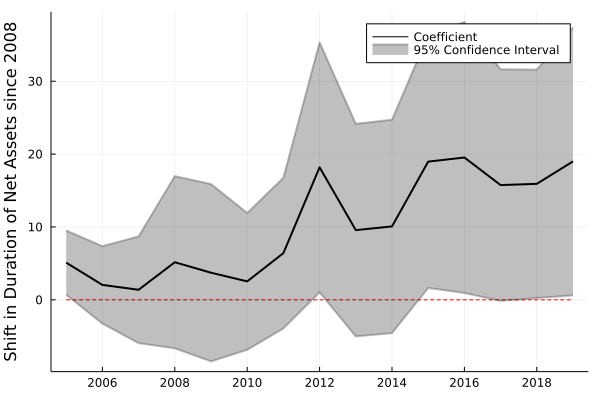

In [107]:
# graph
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2004)[:, [:NAIC_no, :betahat, :bcargap, :bestr_num, :bestr_0, :fracLife]], 
        [:betahat => :betahat2010, :bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010]),
    on = :NAIC_no)

c = [coef(reg(@transform(@subset(balance_assets_amb_ts, (:year .== 2004) .| (:year .== y)), post = :year .== y), 
        @formula(G ~ betahat2010 & post + sur_assets + logassets +fe(NAIC_no) + fe(year)), 
            Vcov.cluster(:NAIC_no, :year),
            weights = :cp_sur_0)
        )[end] for y in 2005:2019]

s = [√vcov(reg(@transform(@subset(balance_assets_amb_ts, (:year .== 2004) .| (:year .== y)), post = :year .== y), 
        @formula(G ~ betahat2010 & post + sur_assets + logassets + fe(NAIC_no) + fe(year)), 
            Vcov.cluster(:NAIC_no, :year), 
            weights = :cp_sur_0)
        )[end,end] for y in 2005:2019]

plot( 2005:2019, c, xlab = "", ylab = "Shift in Duration of Net Assets since 2008", label = "Coefficient",
    width = 2, c = :black)
plot!([2005, 2019], [0, 0], color = :red, linestyle = :dash, label = "")
plot!(2005:2019, c .+ 1.96 .* s, fill = [c, c .+ 2 .* s], alpha = 0.25, label = "95% Confidence Interval", 
    width = 2, c = :black)
plot!(2005:2019, c .- 1.96 .* s, fill = [c, c .- 2 .* s], alpha = 0.25, label = "", 
    width = 2, c = :black)

# plot!(size = (2*800, 2*600),margin = 10mm, c = :gray, 
#     yticks = :none, legend = :bottomright,
#     xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
# png("time series G beta big")

# plot!(size = (960, 480), html_output_format=:png, margin = 5mm)
# png("time series G beta wide")
# plot!()

In [92]:
reg(@transform(balance_assets_all, post = :year .>= 2012), 
        @formula(G ~ fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no), weights = :V_A
)

                     Fixed Effect Model                     
Number of obs:           7858  Degrees of freedom:        17
R2:                     0.880  R2 Adjusted:            0.880
F-Stat:                   NaN  p-value:                  NaN
R2 within:             -0.000  Iterations:                 7
G  | Estimate Std.Error t value Pr(>|t|) Lower 95% Upper 95%
------------------------------------------------------------


In [84]:
# regressions
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2008)[:, 
            [:NAIC_no, :bcargap, :bestr_num, :bestr_0, :fracLife, :lev, :sur_assets, :logassets, :fracVA, :mutual]], 
        [:bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010,
            :lev => :lev2010, :sur_assets => :sur_assets2010, :logassets => :logassets2010, 
            :fracVA => :fracVA2010, :mutual => :mutual2010]),
    on = :NAIC_no)

rr2 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2010), 
    #  + lev2010 + sur_assets2010 + logassets2010 + fracVA2010 + mutual2010
    @formula(G ~ (fracLife2010 + lev2010 + sur_assets2010 + logassets2010 + mutual2010) & post + fe(NAIC_no)), 
    Vcov.cluster(:NAIC_no), weights = :sur_assets
)

rr3 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2010), 
    @formula(G ~ (fracLife2010 + lev2010 + sur_assets2010 + logassets2010 + mutual2010) & post + fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no, :year), weights = :sur_assets
)

regtable(rr2, rr3, renderSettings = latexOutput("time-series post.tex"), 
    estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(rr2, rr3, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))


--------------------------------------------
                                  G         
                        --------------------
                              (1)        (2)
--------------------------------------------
fracLife2010 & post     -3.938***   -3.610**
                          (1.235)    (1.628)
lev2010 & post              0.000      0.000
                          (0.000)    (0.000)
sur_assets2010 & post       0.004      0.004
                          (0.003)    (0.003)
logassets2010 & post       -0.060      0.057
                          (0.072)    (0.205)
mutual2010 & post          -0.200     -0.417
                          (0.869)    (1.091)
--------------------------------------------
NAIC_no                       Yes        Yes
year                                     Yes
--------------------------------------------
Estimator                     OLS        OLS
--------------------------------------------
N                           3,839      3,839
R2       

In [85]:
# regressions
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2008)[:, 
            [:NAIC_no, :bcargap, :bestr_num, :bestr_0, :fracLife, :lev, :sur_assets, :logassets, :fracVA, :mutual]], 
        [:bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010,
            :lev => :lev2010, :sur_assets => :sur_assets2010, :logassets => :logassets2010, 
            :fracVA => :fracVA2010, :mutual => :mutual2010]),
    on = :NAIC_no)

rr2 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2010), 
        @formula(G ~ lev + sur_assets + logassets + fracVA + mutual + fracLife2010 & post + fe(NAIC_no)), 
    Vcov.cluster(:NAIC_no), weights = :sur_assets
)

rr3 = reg(@transform(balance_assets_amb_ts, post = :year .>= 2010), 
        @formula(G ~ lev + sur_assets + logassets + fracVA + mutual + fracLife2010 & post + fe(NAIC_no) + fe(year)), 
    Vcov.cluster(:NAIC_no, :year), weights = :sur_assets
)

regtable(rr2, rr3, renderSettings = latexOutput("time-series 2004.tex"), 
    estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))
regtable(rr2, rr3, renderSettings = asciiOutput(), estim_decoration = make_estim_decorator([0.01, 0.05, 0.1]))

┌ Error: p value = NaN, but it needs to be non-negative
└ @ RegressionTables C:\Users\Max\.julia\packages\RegressionTables\8zjhJ\src\decorations\default_decorations.jl:5
┌ Error: p value = NaN, but it needs to be non-negative
└ @ RegressionTables C:\Users\Max\.julia\packages\RegressionTables\8zjhJ\src\decorations\default_decorations.jl:5



------------------------------------------
                                G         
                      --------------------
                            (1)        (2)
------------------------------------------
lev                      -0.000     -0.000
                        (0.000)    (0.000)
sur_assets               -0.004     -0.003
                        (0.005)    (0.004)
logassets                 0.655      1.303
                        (1.196)    (1.397)
fracVA                   6.020*   9.123***
                        (3.263)    (2.679)
mutual                    0.000      0.000
                          (NaN)      (NaN)
fracLife2010 & post   -5.196***   -3.082**
                        (0.656)    (1.250)
------------------------------------------
NAIC_no                     Yes        Yes
year                                   Yes
------------------------------------------
Estimator                   OLS        OLS
------------------------------------------
N         

┌ Error: p value = NaN, but it needs to be non-negative
└ @ RegressionTables C:\Users\Max\.julia\packages\RegressionTables\8zjhJ\src\decorations\default_decorations.jl:5
┌ Error: p value = NaN, but it needs to be non-negative
└ @ RegressionTables C:\Users\Max\.julia\packages\RegressionTables\8zjhJ\src\decorations\default_decorations.jl:5


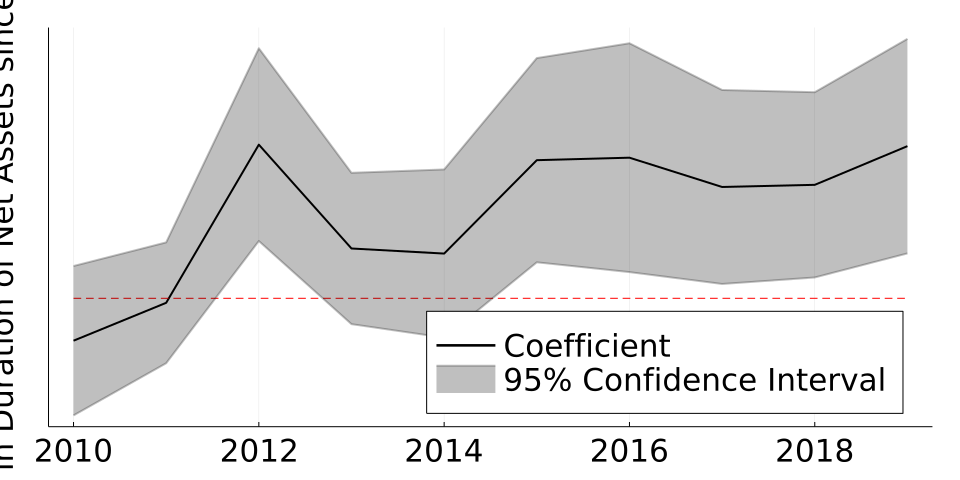

In [146]:
# graph
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2008)[:, [:NAIC_no, :betahat, :bcargap, :bestr_num, :bestr_0, :fracLife]], 
        [:betahat => :betahat2010, :bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010]),
    on = :NAIC_no)

c = [coef(reg(@transform(@subset(balance_assets_amb_ts, (:year .== 2008) .| (:year .== y)), post = :year .== y), 
        @formula(G ~ betahat2010 & post + sur_assets + logassets +fe(NAIC_no) + fe(year)), 
            Vcov.cluster(:NAIC_no, :year),
            weights = :cp_sur_0)
        )[end] for y in 2010:2019]

s = [√vcov(reg(@transform(@subset(balance_assets_amb_ts, (:year .== 2008) .| (:year .== y)), post = :year .== y), 
        @formula(G ~ betahat2010 & post + sur_assets + logassets +fe(NAIC_no) + fe(year)), 
            Vcov.cluster(:NAIC_no, :year), 
            weights = :cp_sur_0)
        )[end,end] for y in 2010:2019]

plot( 2010:2019, c, xlab = "", ylab = "Shift in Duration of Net Assets since 2008", label = "Coefficient",
    width = 2, c = :black)
plot!([2010, 2019], [0, 0], color = :red, linestyle = :dash, label = "")
plot!(2010:2019, c .+ 1.96 .* s, fill = [c, c .+ 2 .* s], alpha = 0.25, label = "95% Confidence Interval", 
    width = 2, c = :black)
plot!(2010:2019, c .- 1.96 .* s, fill = [c, c .- 2 .* s], alpha = 0.25, label = "", 
    width = 2, c = :black)

plot!(size = (2*800, 2*600),margin = 10mm, c = :gray, 
    yticks = :none, legend = :bottomright,
    xtickfontsize=21,ytickfontsize=21,xguidefontsize=21,yguidefontsize=21,legendfontsize=21)
png("time series G beta big")

plot!(size = (960, 480), html_output_format=:png, margin = 5mm)
png("time series G beta wide")
plot!()

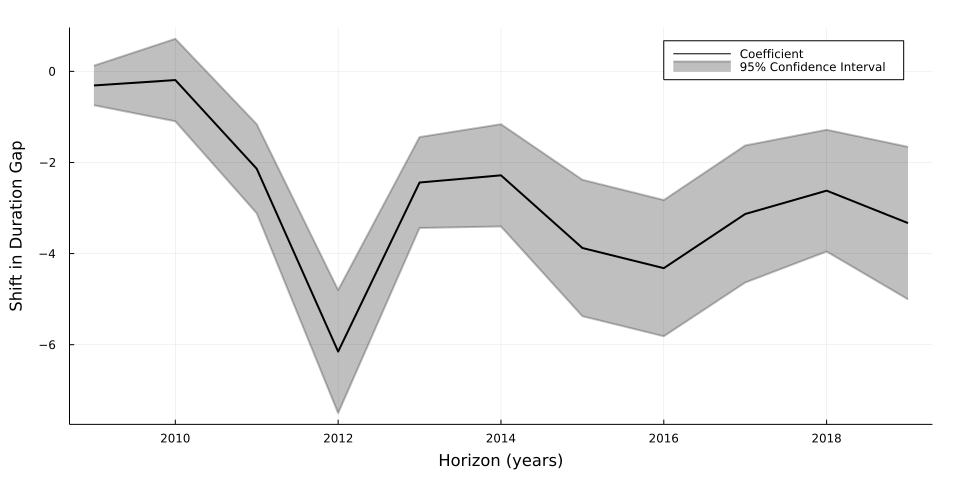

In [96]:
# graph
balance_assets_amb_ts = innerjoin(balance_assets_amb, 
    rename(@subset(balance_assets_amb, :year .== 2008)[:, [:NAIC_no, :bcargap, :bestr_num, :bestr_0, :fracLife]], 
        [:bcargap => :bcargap2010, :bestr_num => :bestr_num2010, :bestr_0 => :bestr2010, :fracLife => :fracLife2010]),
    on = :NAIC_no)

c = [coef(reg(@transform(@subset(balance_assets_amb_ts, (:year .== 2008) .| (:year .== y)), post = :year .== y), 
        @formula(G ~ fracLife2010 & post + sur_assets + logassets + fe(NAIC_no)), Vcov.robust(), weights = :lev)
        )[end] for y in 2009:2019]

s = [√vcov(reg(@transform(@subset(balance_assets_amb_ts, (:year .== 2008) .| (:year .== y)), post = :year .== y), 
        @formula(G ~ fracLife2010 & post + sur_assets + logassets + fe(NAIC_no)), Vcov.robust(), weights = :lev)
        )[end,end] for y in 2009:2019]

plot( 2009:2019, c, xlab = "Horizon (years)", ylab = "Shift in Duration Gap", label = "Coefficient",
    width = 2, c = :black)
plot!(2009:2019, c .+ 1.96 .* s, fill = [c, c .+ 2 .* s], alpha = 0.25, label = "95% Confidence Interval", 
    width = 2, c = :black)
plot!(2009:2019, c .- 1.96 .* s, fill = [c, c .- 2 .* s], alpha = 0.25, label = "", 
    width = 2, c = :black)

plot!(size = (800, 600), html_output_format=:png, margin = 5mm)
png("time series G")

plot!(size = (960, 480), html_output_format=:png, margin = 5mm)
png("time series G wide")
plot!()

In [97]:
@transform(@combine(groupby(balance_assets_amb, :year), D_E = sum(:D_E .* :E) / sum(:E), E = sum(:E)), 
    DD_E = :D_E .* :E ./ 100)

,year,D_E,E,DD_E
,Int64,Float64,Float64,Float64
1,2004,2.16443,1.01017e12,2.18645e10
2,2005,0.270883,1.01096e12,2.73852e9
3,2006,2.29105,1.1762e12,2.69472e10
4,2007,2.28463,1.27276e12,2.90779e10
5,2008,-0.734006,1.21265e12,-8.90093e9
6,2009,-1.48214,1.19407e12,-1.76979e10
7,2010,-0.833421,1.23104e12,-1.02598e10
8,2011,-2.63109,1.19024e12,-3.13164e10
9,2012,-9.0274,1.25059e12,-1.12896e11




# Publicly-Traded Companies

In [98]:
# Asset Duration: aggregate NAIC to PERMNO
NAIC_PERMNO_dict = Dict(
    # AEL
    92738 => 89946,
    11135 => 89946,
    13183 => 89946,
    
    # ANAT
    60739 => 13507, # AMERICAN NATIONAL INSURANCE COMPANY
    71773 => 13507, # AMERICAN NATIONAL LIFE INSURANCE COMPANY OF TEXAS
    63126 => 13507, # AMERICAN NATIONAL LIFE INSURANCE COMPANY OF New York
    63657 => 13507, # Garden State Life Insurance Company
    86355 => 13507, # Standard Life and Accident Insurance Company

    # AMP
    65005 => 90880, # RiverSource Life Insurance Company
    82082 => 90880, # RiverSource Life Insurance Co. of New York
    
    # CIA
    71463 => 23799, # CICA Life Insurance Company of America
    82082 => 23799, # Citizens National Life Insurance Company
    60076 => 23799, # Security Plan Life Insurance Company
    
    # CNO
    11804 => 89841, # Conseco Life Insurance Company of Texas
    68560 => 89841, # Bankers Conseco Life Insurance Company
    61263 => 89841, # Conseco Life Insurance Company of Texas
    62065 => 89841, # COLONIAL PENN LIFE INSURANCE COMPANY
    61506 => 89841, # RESOURCE LIFE INSURANCE COMPANY
    70319 => 89841, # WASHINGTON NATIONAL INSURANCE COMPANY
    
    # FFG
    63088 => 83720, # Farm Bureau Life Insurance Company
    14908 => 83720, # Greenfields Life Insurance Company

    # GNW
    65536 => 90162, # Genworth Life and Annuity Insurance Company
    70025 => 90162, # Genworth Life Insurance Company
    72990 => 90162, # Genworth Life Insurance Company of New York
    97144 => 90162, # Jamestown Life Insurance Company
    63401 => 90162, # First Colony Life Insurance Company
    67695 => 90162, # Federal Home Life Insurance Company
    
    # TMK, GL
    65331 => 62308, # Liberty National Life Insurance Company
    91472 => 62308, # Globe Life And Accident Insurance Company
    60577 => 62308, # American Income Life Insurance Company
    92916 => 62308, # UNITED AMERICAN INSURANCE COMPANY
    10093 => 62308, # National Income Life Insurance Company
    77968 => 62308, # Family Heritage Life Insurance Company of America

    # KCLI
    65129 => 47088, # Kansas City Life Insurance Company
    71218 => 47088, # Grange Life Insurance Company
    67199 => 47088, # Old American Insurance Company
    69272 => 47088, # Sunset Life Insurance Company of America

    # LNC has a lot of NFI liabilities
    65676 => 49015, # The Lincoln National Life Insurance Company
#     67865 => 49015, # JEFFERSON-PILOT LIFE INSURANCE COMPANY #        acqed 2006 and disappeared
    62057 => 49015, # Lincoln Life & Annuity Company of New York
    67652 => 49015, # First Penn-Pacific Life Insurance Company
    65315 => 49015, # Lincoln Life Assurance Company of Boston

    # MET has a lot business abroad, US assets: $291 bn in 2019
    65978 => 87842, # Metropolitan Life Insurance Company
    87726 => 87842, # BRIGHTHOUSE LIFE INSURANCE COMPANY              until 2016, spun-off during 2017
    61050 => 87842, # METLIFE INVESTORS USA INSURANCE COMPANY
    60690 => 87842, # American Life Insurance Company
    63665 => 87842, # General American Life Insurance Company
    62634 => 87842, # Delaware American Life Insurance Company
    39950 => 87842, # Metropolitan General Insurance Company
    97136 => 87842, # Metropolitan Tower Life Insurance Company
    
    # BHF
    87726 => 16816, # BRIGHTHOUSE LIFE INSURANCE COMPANY
    
    # NWLI
    66850 => 56822, # National Western Life Insurance Company
    67393 => 56822, # Ozark National Life Insurance Company

    # PNX until 2016
    67814 => 89008, # Phoenix Life Insurance Company
    93548 => 89008, # PHL VARIABLE INSURANCE COMPANY

    # PFG
    61271 => 89195, # Principal Life Insurance Company
    71161 => 89195, # Principal National Life Insurance Company
    13077 => 89195, # Principal Life Insurance Company of Iowa
    
    # PL unitl 2015
    68136 => 64486, # Protective Life Insurance Company
    88536 => 64486, # Protective Life and Annuity Insurance Company

    # PRU has $288 bn domestic insurance operation
    68241 => 89258, # Prudential Insurance Company of America
    79227 => 89258, # Pruco Life Insurance Company
    86630 => 89258, # PRUDENTIAL ANNUITIES LIFE ASSURANCE CORPORATION               since 2008
    97195 => 89258, # Pruco Life Insurance Company of New Jersey
    93629 => 89258, # Prudential Retirement Insurance and Annuity Company
    13809 => 89258, # Prudential Legacy Insurance Company of New Jersey

    # SNFCA
    69485 => 11593, # Security National Life Insurance Company
    74918 => 11593, # Kilpatrick Life Insurance Company
    75531 => 11593, # Southern Security Life Insurance Company
    99473 => 11593, # Trans-Western Life Insurance Company

    # UNM
    62235 => 71175, # Unum Life Insurance Company of America
    67598 => 71175, # The Paul Revere Life Insurance Company
    
    #VOYA
    86509 => 13904, # Voya Retirement Insurance and Annuity Company
    80942 => 13904, # Venerable Insurance and Annuity Company
    61247 => 13904, # USG ANNUITY & LIFE COMPANY
    67105 => 13904, # ReliaStar Life Insurance Company
    61360 => 13904, # ReliaStar Life Insurance Company of New York
    68381 => 13904, # Reliance Standard Life Insurance Company
    66575 => 13904, # Reliance Std Life Ins Co. (TX)
    68713 => 13904, # Security Life of Denver Ins Co
    62979 => 13904, # Equitable Life Ins Co. of Iowa
    60054 => 13904, # Aetna Life Insurance and Annuity Company
    
    # IHC
    69078 => 43837, # Standard Security Life Insurance Company of New York
    65781 => 43837, # Madison National Life Insurance Company
);

In [120]:
# load stock and book data

# stock
stock_data = CSV.read("a1qpe5uy84bruibq extended.csv", DataFrame)
dropmissing!(stock_data)
stock_data[!, :date] .= [occursin("/", d) ? Dates.Date(d, dateformat"m/d/y") : Dates.Date(d, dateformat"yyyymmdd")
    for d in stock_data[:, :date]]
@transform!(stock_data, year = Dates.year.(:date))
stock_data = @combine(groupby(stock_data, [:PERMNO, :year]),
    eq_mkt = abs(last(:PRC)) * last(:SHROUT) * 1000)

# book
book_data = CSV.read("5djommphwa6btkma.csv", DataFrame)
rename!(book_data, :LPERMNO => :PERMNO)
book_data = @combine(groupby(book_data, [:PERMNO, :fyear]), 
    at = first(:at) * 1000000, lt = first(:lt) * 1000000, 
    eq = (first(:at) - first(:lt)) * 1000000,
    saa = first(:saa) * 1000000., sal = first(:sal) * 1000000.
)

balance_sheet_public = innerjoin(book_data, stock_data, on = [:PERMNO, :fyear => :year])

balance_assets = CSV.read("Balance Sheet Asset Duration T - corrected for MBS", DataFrame)
balance_assets = @subset(balance_assets, :year .>= 2004)
balance_assets[!, :PERMNO] = [get(NAIC_PERMNO_dict, p, 0) for p in balance_assets[:, :NAIC_no]]
balance_assets_public = @subset(balance_assets, :PERMNO .!= 0)
balance_assets_public = @combine(groupby(balance_assets_public, [:PERMNO, :year, :asset_type]), 
    value = sum(:value), 
    duration = sum(coalesce.(:duration, 0.0) .* :value) / sum(:value), 
)
@transform!(balance_assets_public, duration = ifelse.(isnan.(:duration), 0.0, :duration))

balance_assets_public = @combine(groupby(balance_assets_public, [:PERMNO, :year]), 
    D_A = sum(:duration .* :value) / sum(:value),
    V_A = sum(:value)
)

# combine general accounts
balance_sheet_public = innerjoin(balance_sheet_public, balance_assets_public, on = [:PERMNO, :fyear => :year])

balance_assets_all_PERMNO = copy(balance_assets_all)
balance_assets_all_PERMNO[!, :PERMNO] = [get(NAIC_PERMNO_dict, p, 0) for p in balance_assets_all_PERMNO[:, :NAIC_no]]
balance_assets_all_PERMNO = @subset(balance_assets_all_PERMNO, :PERMNO .!= 0)
balance_assets_all_PERMNO = @combine(groupby(balance_assets_all_PERMNO, [:PERMNO, :year]), 
    V_L = sum(:Value_L),
    D_L = sum(:D_L .* :Value_L) / sum(:Value_L),
    R_L = sum(:Reserve_L),
    ResVar_L = sum(:ResVar_L),
    E = sum(:E),
    D_E = sum(:E .* :D_E) / sum(:E)
)

balance_sheet_public = innerjoin(balance_sheet_public, balance_assets_all_PERMNO, on = [:PERMNO, :fyear => :year]);

In [121]:
balance_sheet_public = @subset(balance_sheet_public, .!isnan.(:D_L));

In [122]:
balance_sheet_public = hcat(balance_sheet_public[:, 1:2],
    @transform(balance_sheet_public,
        # Duration
#         D_E_book =                                   1 ./ (:at .- :lt) .* (:D_A .* :V_A .- :D_L .* (:V_L .+ 0.5 .* :ResVar_L)),
#         D_E_book_to_mkt = (:at .- :lt) ./ :eq_mkt .* 1 ./ (:at .- :lt) .* (:D_A .* :V_A .- :D_L .* (:V_L .+ 0.5 .* :ResVar_L)),
        
        D_E =                                   1 ./ (:at .- :lt) .* (:D_A .* :V_A .- :D_L .* :V_L),
        D_E_book_to_mkt = 1 ./ :eq_mkt .* (:D_A .* :V_A .- :D_L .* :V_L),
        E = (:at .- :lt), 
        
        V_A_book = (:at),
        V_A_gen = (:at .- :saa),
        V_A_sep = (:saa),
        V_L_book = (:lt),
        V_L_gen = (:lt .- :sal),
        V_L_sep = (:sal),
        V_E_book = (:at .- :lt),
        V_E_mkt = (:eq_mkt),
        
        # from the statutory books
        V_A_gen_in = (:V_A),
        V_L_gen_in = (:V_L),
        D_A_gen_in = (:D_A), # no reason for: sum(:D_A .* :V_A) / sum(:V_A),
        D_L_gen_in = (:D_L), # sum(:D_L .* :V_L) / sum(:V_L),
        R_L_gen_in = (:R_L),
        R_L_gen_out = (:ResVar_L),        
    )[:, 15:end]
);

@transform!(balance_sheet_public,
    V_A_in_ratio = sum(:V_A_gen_in) / sum(:V_A_gen)
)

,PERMNO,fyear,E,D_E,D_E_book_to_mkt,V_A_book,V_A_gen,V_A_sep,V_L_book,V_L_gen,V_L_sep,V_E_book,V_E_mkt,V_A_gen_in,V_L_gen_in,D_A_gen_in
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,89008,2004,2.0634e9,-33.9597,-59.1279,2.83626e10,2.14126e10,6.95e9,2.62992e10,1.93492e10,6.95e9,2.0634e9,1.1851e9,1.63258e10,1.22019e10,6.57352
2,47088,2004,6.92896e8,-24.4131,-29.7407,4.66615e9,4.31215e9,3.54e8,3.97325e9,3.61925e9,3.54e8,6.92896e8,5.68774e8,3.75734e9,2.74113e9,6.16641
3,49015,2004,6.17559e9,15.6953,11.8927,1.16219e11,6.10143e10,5.5205e10,1.10044e11,5.48387e10,5.5205e10,6.17559e9,8.15019e9,4.61259e10,1.38624e10,6.74925
4,64486,2004,2.16633e9,5.35331,3.91228,2.72114e10,2.46854e10,2.526e9,2.50451e10,2.25191e10,2.526e9,2.16633e9,2.96427e9,1.26079e10,5.31673e9,8.19171
5,56822,2004,8.08672e8,14.6657,20.9993,5.99168e9,5.99168e9,0.0,5.18301e9,5.18301e9,0.0,8.08672e8,5.64768e8,5.67458e9,1.018e9,5.37445
6,62308,2004,3.4198e9,-4.05373,-2.2442,1.42522e10,1.26582e10,1.594e9,1.08324e10,9.2384e9,1.594e9,3.4198e9,6.17723e9,8.40525e9,5.29487e9,10.2048
7,89841,2004,3.9022e9,16.8257,21.7769,3.07555e10,3.07225e10,3.3e7,2.68533e10,2.68203e10,3.3e7,3.9022e9,3.01498e9,1.2847e10,6.68816e9,11.0437
8,89258,2004,2.2344e10,10.1481,8.0738,4.01058e11,2.8549e11,1.15568e11,3.78714e11,2.63146e11,1.15568e11,2.2344e10,2.80846e10,1.57822e11,6.65193e10,7.45395
9,11593,2004,4.5478e7,8.0133,21.2465,3.16474e8,3.16474e8,0.0,2.70996e8,2.70996e8,0.0,4.5478e7,1.71524e7,3.40357e8,1.10832e8,6.76527


In [124]:
sort(balance_sheet_public, :V_E_mkt)[:, [:PERMNO, :V_E_mkt, :V_A_in_ratio]][end-20:end,:]

,PERMNO,V_E_mkt,V_A_in_ratio
,Int64,Float64,Float64
1,87842,3.5939e10,0.582136
2,89258,3.65531e10,0.582136
3,89258,3.6961e10,0.582136
4,87842,3.71066e10,0.582136
5,89258,3.76835e10,0.582136
6,87842,4.05196e10,0.582136
7,89258,4.09552e10,0.582136
8,89258,4.12498e10,0.582136
9,89258,4.20541e10,0.582136


In [117]:
@combine(groupby(balance_sheet_public, :fyear), E = sum(:E), E_mkt = sum(:V_E_mkt), E_stat = sum(:V_A_gen_in .- :V_L_gen_in .- :R_L_gen_out),
    D_E_book_to_mkt = sum(:D_E_book_to_mkt .* :V_E_mkt) / sum(:V_E_mkt),
    V_A_in_ratio = sum(:V_A_gen_in) / sum(:V_A_gen)
)

,fyear,E,E_mkt,E_stat,D_E_book_to_mkt,V_A_in_ratio
,Int64,Float64,Float64,Float64,Float64,Float64
1,2004,9.79978e10,1.07175e11,2.61494e11,12.2187,0.672092
2,2005,1.14548e11,1.46941e11,2.52517e11,6.55941,0.647319
3,2006,1.26965e11,1.77131e11,3.03699e11,9.55835,0.633636
4,2007,1.28634e11,1.72412e11,2.96557e11,7.61484,0.65855
5,2008,8.0629e10,7.40544e10,2.44352e11,-2.24719,0.682302
6,2009,1.28531e11,1.01201e11,2.22143e11,-3.36554,0.664814
7,2010,1.60866e11,1.34169e11,2.30148e11,2.51803,0.588125
8,2011,1.83012e11,1.0359e11,2.19475e11,-3.97257,0.562275
9,2012,1.89301e11,1.13016e11,1.3408e11,-27.9094,0.514474


In [ ]:
@combine(@subset(@combine(groupby(balance_sheet_public, :fyear), E = sum(:E), E_mkt = sum(:V_E_mkt), E_stat = sum(:V_A_gen_in .- :V_L_gen_in .- :R_L_gen_out),
    D_E_book_to_mkt = sum(:D_E_book_to_mkt .* :V_E_mkt) / sum(:V_E_mkt)), :fyear .>= 2010), x = mean(:D_E_book_to_mkt))

In [155]:
@combine(groupby(balance_sheet_public, :fyear), E = sum(:E), E_mkt = sum(:V_E_mkt), E_stat = sum(:V_A_gen_in .- :V_L_gen_in .- :R_L_gen_out))

,fyear,E,E_mkt,E_stat
,Int64,Float64,Float64,Float64
1,2004,9.79978e10,1.07175e11,2.61494e11
2,2005,1.14548e11,1.46941e11,2.52517e11
3,2006,1.26965e11,1.77131e11,3.03699e11
4,2007,1.28634e11,1.72412e11,2.96557e11
5,2008,8.0629e10,7.40544e10,2.44352e11
6,2009,1.28531e11,1.01201e11,2.22143e11
7,2010,1.60866e11,1.34169e11,2.30148e11
8,2011,1.83012e11,1.0359e11,2.19475e11
9,2012,1.89301e11,1.13016e11,1.3408e11


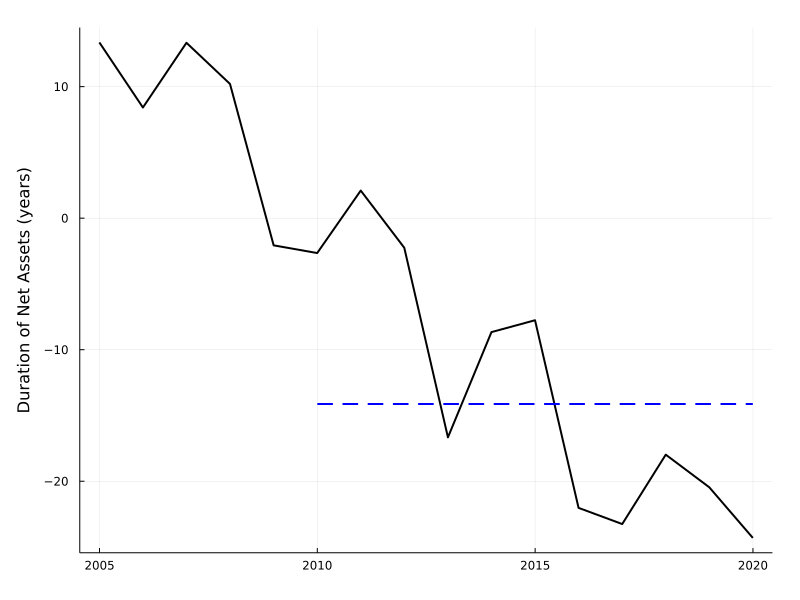

In [167]:
#
df = @combine(groupby(balance_sheet_public, :fyear), 
    D_E = sum(:D_E .* :E) / sum(:E),
    E = sum(:E), 
    D_A = sum(:D_A_gen_in .* :V_A_gen_in) / sum(:V_A_gen_in),
    D_L = sum(:D_L_gen_in .* :V_L_gen_in) / sum(:V_L_gen_in),
)

@df df plot(Date.(:fyear, 12,31), :D_E, ylab = "Duration of Net Assets (years)", 
    c = :black, label = "", width = 2, 
    size = (800, 600), html_output_format=:png, margin = 5mm)

plot!([Date(2010,1,1), Date(2019,12,31)], [@combine(@subset(df, :fyear .>= 2010), m = mean(:D_E))[1,1], 
        @combine(@subset(df, :fyear .>= 2010), m = mean(:D_E))[1,1]],
    width = 2, c = :blue, linestyle = :dash, label = "")#, ylim = (-20, 21))

plot!(xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))
png("Duration of Balance Sheet Equity")
plot!()

In [158]:
df[end, :]

,fyear,D_E,E,D_A,D_L
,Int64,Float64,Float64,Float64,Float64
16,2019,-24.3078,2.49414e11,8.23999,19.4397


In [177]:
# #
# A = @combine(@combine(groupby(balance_sheet_public, :fyear), A = sum(:at)), A = mean(:A))[1,1]
# L = @combine(@combine(groupby(balance_sheet_public, :fyear), L = sum(:lt)), L = mean(:L))[1,1]

# df = @combine(groupby(balance_sheet_public, :fyear), 
    
#     D_E = (sum(:D_A .* :V_A) - sum(:D_L .* (:V_L .+ 0.25 .* :ResVar_L) .+ 1/9 .* (:V_L .+ :ResVar_L))) / 
#         (sum(:at) - sum(:lt)),
#     DD_E = (sum(:D_A .* :at) - sum(:D_L .* :lt)),
#     D_A = sum(:D_A .* :V_A) / sum(:V_A),
#     D_L = sum(:D_L .* :V_L) / sum(:V_L),
#     at = sum(:at),
#     lt = sum(:lt),
#     eq = sum(:at) - sum(:lt),
#     lev = sum(:lt) / sum(:at),
#     V_A = sum(:V_A),
#     V_L = sum(:V_L),
#     date = Date(:fyear[1], 12, 31),

#     )

# @df df plot(:date, :D_E, ylab = "Duration of Balance Sheet Equity (years)", 
#     c = :black, label = "", width = 2, 
#     size = (800, 600), html_output_format=:png, margin = 5mm)

# plot!([Date(2010,1,1), Date(2019,12,31)], [@combine(@subset(df, :fyear .>= 2010), m = mean(:D_E))[1,1], 
#         @combine(@subset(df, :fyear .>= 2010), m = mean(:D_E))[1,1]],
#     width = 2, c = :blue, linestyle = :dash, label = "", ylim = (-20, 21))

# plot!(xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))
# png("Duration of Balance Sheet Equity")
# plot!()

In [178]:
# #
# A = @combine(@combine(groupby(balance_sheet_public, :fyear), A = sum(:at)), A = mean(:A))[1,1]
# L = @combine(@combine(groupby(balance_sheet_public, :fyear), L = sum(:lt)), L = mean(:L))[1,1]

# df = @combine(groupby(balance_sheet_public, :fyear), 
#     D_E = (sum(:D_A .* 1.75 .* :V_L) - sum(:D_L .* (:V_L))) / (sum(:at) - sum(:lt)),
#     DD_E = (sum(:D_A .* :at) - sum(:D_L .* :lt)),
#     D_A = sum(:D_A .* :V_A) / sum(:V_A),
#     D_L = sum(:D_L .* :V_L) / sum(:V_L),
#     at = sum(:at),
#     lt = sum(:lt),
#     eq = sum(:at) - sum(:lt),
#     lev = sum(:lt) / sum(:at),
#     V_A = sum(:V_A),
#     V_L = sum(:V_L),
#     date = Date(:fyear[1], 12, 31)
#     )

# @df df plot(:date, :D_E, ylab = "Duration of Balance Sheet Equity (years)", 
#     c = :black, label = "", width = 2, 
#     size = (800, 600), html_output_format=:png, margin = 5mm)

# plot!([Date(2010,1,1), Date(2019,12,31)], [@combine(@subset(df, :fyear .>= 2010), m = mean(:D_E))[1,1], @combine(@subset(df, :fyear .>= 2010), m = mean(:D_E))[1,1]],
#     width = 2, c = :blue, linestyle = :dash, label = "", ylim = (-20, 21))

# plot!(xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))
# png("Duration of Balance Sheet Equity placeholder")
# plot!()

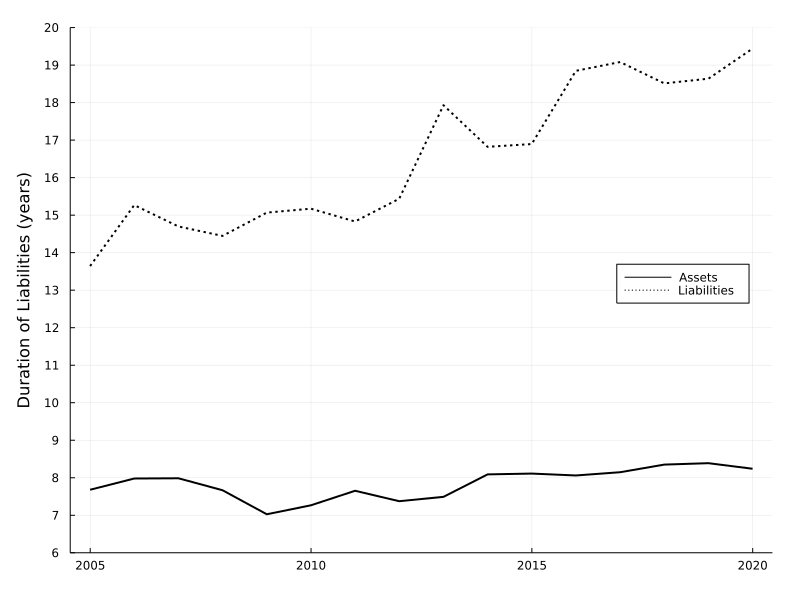

In [73]:
#
@df df plot(Date.(:fyear, 12,31), :D_A, ylab = "Duration (years)", 
    c = :black, width = 2, label = "Assets", legend = :topleft, yticks = 5:1:15,
    size = (800, 600), html_output_format=:png, margin = 5mm, ylim = (6, 20))

intercept = df[1, :D_L] - df[1, :D_A]

@df df plot!(Date.(:fyear, 12,31), :D_L, ylab = "Duration of Liabilities (years)", linestyle = :dot, yticks = 5:1:20,
    c = :black, width = 2, label = "Liabilities", legend = :right)#, ylim = (5+intercept, 15+intercept))

plot!(xformatter = x -> Dates.format(Date(Dates.UTD(x)), "yyyy"), xticks = Date(1990,1,1):Dates.Year(5):Date(2020,1,1))
png("Duration of Balance Sheet")
plot!()

# Maturity Matching

In [ ]:
#
balance_assets = CSV.read("Balance Sheet Asset Duration - corrected for MBS", DataFrame)

balance_assets = @subset(balance_assets, :year .>= 2004)

balance_assets = @combine(groupby(@subset(balance_assets, :year .>= 2004), [:NAIC_no, :year]), 
    NAIC_no = :NAIC_no[1],
    value = sum(:value), 
    missingvalue = sum(:value[ismissing.(:duration)]), 
    V_A_bond = sum(:value .* (:asset_type .== "Bonds")),
    V_A_deriv = sum(:value .* (:asset_type .== "Derivatives")),
    V_A_MBS = sum(:ValueMBS),
    duration = (all(ismissing, :duration) || sum(:value) == 0) ? 0. : sum(
        skipmissing(:value .* :duration)) / sum(:value)
    )
@transform!(balance_assets, duration = ifelse.(isnan.(:duration), 0.0, :duration))
rename!(balance_assets, [:value => :V_A, :missingvalue => :V_A_m_d, :duration => :D_A])

balance_all = innerjoin(balance_assets, L_NAIC_year, on = [:NAIC_no, :year]);

In [ ]:
#
liab_df = unstack(
    @combine(groupby(reserves, [:NAIC_no, :Year, :Line]), AvgTotals = sum(:Totals)),
        [:NAIC_no, :Year], :Line, :AvgTotals, renamecols = x-> "AvgTotals_$(x)"
)

for col in names(liab_df)
    liab_df[ismissing.(liab_df[:, Symbol(col)]), Symbol(col)] .= 0.0
end

dropmissing!(liab_df)

@transform!(liab_df, 
    Totals_LifeAnn = Float64.(:AvgTotals_1 .+ :AvgTotals_2), 
    Totals_NonLifeAnn = Float64.(:AvgTotals_3 .+ :AvgTotals_4 .+ :AvgTotals_5 .+ :AvgTotals_6),
    Totals = Float64.(:AvgTotals_1 .+ :AvgTotals_2 .+ :AvgTotals_3 .+ :AvgTotals_4 .+ :AvgTotals_5 .+ :AvgTotals_6)
    )

liab_df = select(liab_df, 
    [:NAIC_no, :Year, :Totals_LifeAnn, :Totals_NonLifeAnn, :Totals])

liab_df = leftjoin(
    liab_df, 
    @combine(groupby(reserves_est, [:NAIC_no, :Year]), Totals_LifeAnnInSample = Float64.(sum(:Totals))),
    on = [:NAIC_no, :Year]
)

for col in names(liab_df)
    liab_df[ismissing.(liab_df[:, Symbol(col)]), Symbol(col)] .= 0.0
end

dropmissing!(liab_df)

balance_all = innerjoin(balance_all, liab_df, on = [:NAIC_no, :year => :Year]);

In [ ]:
# avg_balance_df
avg_balance_df = @combine(groupby(balance_all, :NAIC_no), 
    V_A = mean(:V_A), 
    V_A_bond = mean(:V_A_bond), 
    V_A_deriv = mean(:V_A_deriv), 
    V_A_MBS = mean(:V_A_MBS), 
    V_A_m_d = mean(:V_A_m_d), 
    D_A = mean(:D_A), 
    Totals_LifeAnn = mean(:Totals_LifeAnn), 
    Totals_NonLifeAnn = mean(:Totals_NonLifeAnn), 
    Totals = mean(:Totals), 
    Totals_LifeAnnInSample = mean(:Totals_LifeAnnInSample),
)

@transform!(avg_balance_df, weights = :Totals_LifeAnnInSample ./ :Totals)

avg_balance_df = @subset(avg_balance_df, 
    (:V_A .> :Totals) .&
#     (abs.(:V_A .- :Totals) ./ max.(:V_A, :Totals) .< 0.25) .&
    (:V_A_bond .> 0.6 .* :V_A) .&
    (:V_A_deriv .< 0.01) .& 
    (:V_A_MBS .< 0.2 .* :V_A) .&
    (:V_A_m_d .< 0.1 .* :V_A) .& 
    (:weights .> 0.0) .&
    (:V_A .> 1e8) .&
    true
    );

In [ ]:
#
df = @combine(groupby(
        innerjoin(balance_all, select(avg_balance_df, [:NAIC_no,]), on = :NAIC_no), 
        :NAIC_no), D_A = mean(:D_A), D_L = mean(:D_L), V_A = mean(:V_A), V_L = mean(:Value_L))
mx = maximum(df[:, :V_A])
mn = minimum(df[:, :V_A])
df = @subset(df, (0 .< :V_A .< Inf) .& (0 .< :D_A .< Inf) .& (0 .< :D_L .< Inf))
df = @subset(df, abs.(:V_A .- :V_L) ./ max.(:V_A, :V_L) .< 0.3)
@transform!(df, w = 10 * (:V_A .- mn) / (mx - mn))

@df @subset(df, (50 .> :D_L .> 0) .& (:D_A .< 20)) scatter(:D_L, :D_A, c= :black)
result = reg(df, @formula(D_A ~ D_L))
plot!(collect(9:20), coef(result)[1] .+ collect(9:20) .* coef(result)[2], width = 2, legend = :topleft)

## Combining Balance Sheet Assets and Liabilities

* should Dollar duration be divided by value or non-missing value?

In [86]:
#
balance_sheet = @combine(groupby(@where(balance_assets, :year .>= 2004), [:NAIC_no, :year]), 
    NAIC_grp_no = first(:NAIC_grp_no),
    value = sum(:value), 
    missingvalue = sum(:value[ismissing.(:duration)]), 
    V_A_MTGE = sum(:ValueMBS[:asset_type .== "Bonds"] + :value[:asset_type .== "Mortgages"]),
    duration = (all(ismissing, :duration) || sum(:value) == 0) ? 0. : sum(skipmissing(:value .* :duration)) / sum(:value),
    V_A_bond = sum(:value .* (:asset_type .== "Bonds")),
    V_A_deriv = sum(:value .* (:asset_type .== "Derivatives")),
    V_A_MBS = sum(:ValueMBS),
)

rename!(balance_sheet, :value => :V_A, :missingvalue => :V_A_m_d, :duration => :D_A)

balance_sheet = innerjoin(balance_sheet, L_NAIC_year, on = [:NAIC_no, :year])

rename!(balance_sheet, :Reserve_L => :R_L, :Value_L => :V_L)#, :Reserve_L_missing => :R_L_missing_dur, :Value_L => :V_L)

@transform!(balance_sheet, D_A = ifelse.(isnan.(:D_A), 0.0, :D_A))
# @transform!(balance_sheet, G = ifelse.(:V_A .== 0, 0.0, :D_A .- :R_L ./ :V_A .* :D_L))
@transform!(balance_sheet, G = ifelse.(:V_A .== 0, 0.0, :D_A .- 0.75 .* :D_L))

balance_sheet = innerjoin(balance_sheet, 
    @combine(groupby(reserves, [:Year, :NAIC_no]), 
        R_ex5 = Float64(sum(:Totals)),
        R_1 =   Float64(sum(:Totals .* (:Line .== 1))),
        R_2 =   Float64(sum(:Totals .* (:Line .== 2))),
    ),
    on = [:NAIC_no, :year => :Year]
)

# CSV.write("Balance Sheet.csv", balance_sheet)
describe(balance_sheet)

┌ Warning: `@where is deprecated, use `@subset`  with `@skipmissing` instead.
└ @ DataFramesMeta C:\Users\Max\.julia\packages\DataFramesMeta\EDzWO\src\macros.jl:586


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,Type
1,NAIC_no,73250.3,15638,69345.0,99937,0,Int64
2,year,2011.14,2004,2011.0,2019,0,Int64
3,NAIC_grp_no,24274.4,1,1164.5,99767,0,Int64
4,V_A,6.1723e9,0.0,4.00139e8,2.6668e11,0,Float64
5,V_A_m_d,3.64059e8,-6.31784e6,2.33919e6,3.64434e10,0,Float64
6,V_A_MTGE,1.10777e9,0.0,4.66509e7,6.59741e10,0,Float64
7,D_A,7.09674,0.0,6.79704,26.7404,0,Float64
8,V_A_bond,4.48488e9,0.0,3.12374e8,1.89018e11,0,Float64
9,V_A_deriv,5.7468e7,-1.18176e7,0.0,1.30489e10,0,Float64


In [102]:
# public vs. mutual
balance_sheet_sel = @combine(groupby(balance_sheet, [:NAIC_no]), 
        V_A = mean(:V_A),
        D_A = sum(:D_A .* :V_A) / sum(:V_A),
        V_L =  mean(:V_L),
        R_L =  mean(:R_L),
        D_L =  sum(:D_L .* :V_L) / sum(:V_L),
        G = sum(:V_A .* :G) / sum(:V_A)
)

NAIC_mutuals = [
#     71412, # Mutual of Omaha # all accident and health
    65935, # Mass Mut
    67091, # Northwestern
    62626, # CUNA
#     63304, # Fidelity
    60142, # TIAA
]

balance_sheet_mutuals = balance_sheet_sel[[m ∈ NAIC_mutuals for m in balance_sheet_sel[:, :NAIC_no]], :]
@show @combine(balance_sheet_mutuals, G = sum(:G .* :V_A) / sum(:V_A))

NAIC_public = collect(keys(NAIC_PERMNO_dict))

balance_sheet_public = balance_sheet_sel[[m ∈ NAIC_public for m in balance_sheet_sel[:, :NAIC_no]], :]
@show @combine(balance_sheet_public, G = sum(:G .* :V_A) / sum(:V_A));

#= In[102]:21 =# @combine(balance_sheet_mutuals, G = sum(:G .* :V_A) / sum(:V_A)) = 1×1 DataFrame
 Row │ G
     │ Float64
─────┼──────────
   1 │ -7.79176
#= In[102]:26 =# @combine(balance_sheet_public, G = sum(:G .* :V_A) / sum(:V_A)) = 1×1 DataFrame
 Row │ G
     │ Float64
─────┼──────────
   1 │ -4.39248


In [103]:
# select and aggregate to year  
# 
balance_sheet_sel = @where(balance_sheet, 
    (:V_A .> :R_L) .&
    (0.3 .< :V_A ./ (:R_L .+ :ResVar_L) .< 1.3) .&
    (:ResVar_L .< 0.1 .* :R_L) .&
    
    (:V_A_bond .> 0.5 .* :V_A) .&
    (:V_A_deriv .< 0.01) .& 
    (:V_A_MBS .< 0.2 .* :V_A) .&
    (:V_A_m_d .< 0.1 .* :V_A) .& 
    true
);

balance_sheet_year_sel = @combine(groupby(balance_sheet_sel, [:year]), 
        V_A = sum(:V_A),
        D_A = sum(:D_A .* :V_A) / sum(:V_A),
        V_L =  sum(:V_L),
        R_L =  sum(:R_L),
        D_L =  sum(:D_L .* :V_L) / sum(:V_L),
        G = sum(:V_A .* :G) / sum(:V_A)
)

describe(balance_sheet_year_sel)

┌ Warning: `@where is deprecated, use `@subset`  with `@skipmissing` instead.
└ @ DataFramesMeta C:\Users\Max\.julia\packages\DataFramesMeta\EDzWO\src\macros.jl:586


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,year,2011.5,2004,2011.5,2019,0,Int64
2,V_A,2.15636e11,5.68949e10,8.64022e10,5.56258e11,0,Float64
3,D_A,8.15596,7.16356,8.16954,9.19849,0,Float64
4,V_L,1.97962e11,5.74971e10,1.05771e11,5.16811e11,0,Float64
5,R_L,1.81297e11,4.86166e10,7.74207e10,4.62243e11,0,Float64
6,D_L,17.3308,13.3513,17.565,20.93,0,Float64
7,G,-4.93333,-6.93184,-4.8339,-2.70823,0,Float64


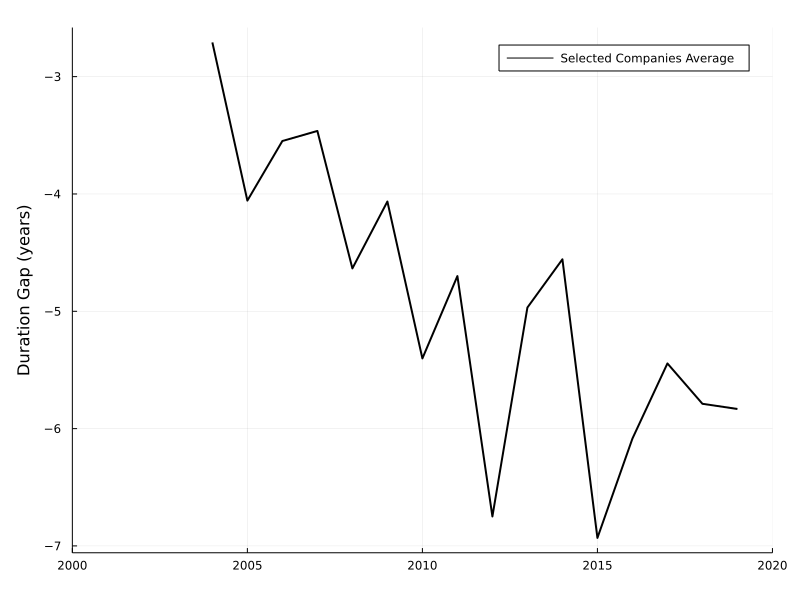

In [104]:
#  
@df balance_sheet_year_sel plot(:year, :G, size = (960, 480), html_output_format=:png, width = 2, c = :black, 
    label = "Selected Companies Average", legend = :topleft)

# bound = 0.5
# u = zeros(length(unique(L_NAIC_year[:, :year])))
# d = zeros(length(unique(L_NAIC_year[:, :year])))
# @showprogress for (y, dg) in enumerate(groupby(sort!(balance_sheet_year_sel, [:year, :G]), :year))

#     dist = zeros(length(dg[:, :G]), length(dg[:, :G]))
#     vol = zeros(length(dg[:, :G]), length(dg[:, :G]))
#     tot_vol = sum(dg[:, :V_L])
#     avg = sum(dg[:, :V_L] .* dg[:, :G]) / sum(dg[:, :V_L])

#     above = dg[dg[:, :G] .>= avg, :]
#     below = dg[dg[:, :G] .<  avg, :]
#     u[y] = above[findfirst(((cumsum(above[:, :V_L]) .+ sum(below[:, :V_L])) ./ tot_vol) .>= (0.5 + bound / 2)), :G]
#     d[y] = below[findlast((cumsum(below[:, :V_L]) ./ tot_vol) .<= (0.5 - bound / 2)), :G]

# end
# plot!(balance_sheet_year_sel[:, :year], u,               fill = [balance_sheet_year_sel[:, :G] u], alpha = 0.4, c = :black, label = "50% of Reserves")
# plot!(balance_sheet_year_sel[:, :year], balance_sheet_year_sel[:, :G], fill = [d balance_sheet_year_sel[:, :G]], alpha = 0.4, c = :black, label = "")

# bound = 0.9
# u = zeros(length(unique(L_NAIC_year[:, :year])))
# d = zeros(length(unique(L_NAIC_year[:, :year])))
# @showprogress for (y, dg) in enumerate(groupby(sort!(L_NAIC_year, [:year, :G]), :year))

#     dist = zeros(length(dg[:, :G]), length(dg[:, :G]))
#     vol = zeros(length(dg[:, :G]), length(dg[:, :G]))
#     tot_vol = sum(dg[:, :V_L])
#     avg = sum(dg[:, :V_L] .* dg[:, :G]) / sum(dg[:, :V_L])

#     above = dg[dg[:, :G] .>= avg, :]
#     below = dg[dg[:, :G] .<  avg, :]
#     u[y] = above[findfirst(((cumsum(above[:, :V_L]) .+ sum(below[:, :V_L])) ./ tot_vol) .>= (0.5 + bound / 2)), :G]
#     d[y] = below[replace(
#             [findlast((cumsum(below[:, :V_L]) ./ tot_vol) .<= (0.5 - bound / 2))],
#             nothing => 1)[1], :G]

# end
# plot!(balance_sheet_year_sel[:, :year], u,               fill = [balance_sheet_year_sel[:, :G] u], alpha = 0.2, c = :black, label = "90% of Reserves")
# plot!(balance_sheet_year_sel[:, :year], balance_sheet_year_sel[:, :G], fill = [d balance_sheet_year_sel[:, :G]], alpha = 0.2, c = :black, label = "",
#     ylab = "Duration of Liabilities", xlim = (2000,2020), 
#     xticks = 2000:5:2020,
#     size = (800, 600), html_output_format=:png, margin = 5mm)
plot!(ylab = "Duration Gap (years)", xlim = (2000,2020), 
    xticks = 2000:5:2020,
    size = (800, 600), html_output_format=:png, margin = 5mm, legend = :topright)

png("Duration Gap")
plot!()

In [105]:
HHI_NAIC_year = CSV.read("HHI_NAIC_year.csv", DataFrame)

balance_sheet = innerjoin(balance_sheet, HHI_NAIC_year, on = [:NAIC_no, :year]);

┌ Warning: `@where is deprecated, use `@subset`  with `@skipmissing` instead.
└ @ DataFramesMeta C:\Users\Max\.julia\packages\DataFramesMeta\EDzWO\src\macros.jl:586
┌ Warning: `@where is deprecated, use `@subset`  with `@skipmissing` instead.
└ @ DataFramesMeta C:\Users\Max\.julia\packages\DataFramesMeta\EDzWO\src\macros.jl:586


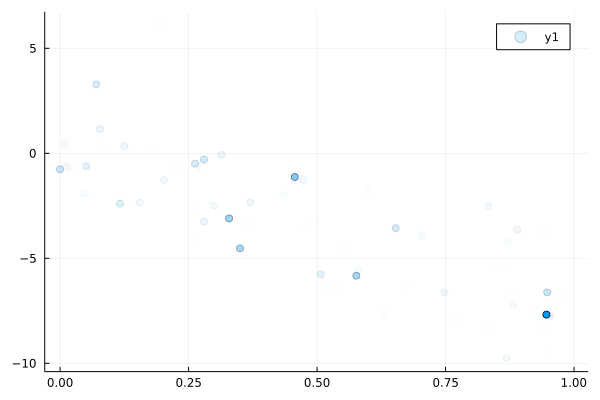

In [106]:
# balance_sheet_sel = balance_sheet

balance_sheet_sel = @where(balance_sheet, 
    
    (:V_A .> :R_L .+ :ResVar_L) .&
    (0.3 .< :V_A ./ (:R_L .+ :ResVar_L) .< 1.3) .&
    (:ResVar_L .< 0.1 .* :R_L) .&
    
#     (:V_A_bond .> 0.5 .* :V_A) .&
#     (:V_A_deriv .< 0.01) .& 
#     (:V_A_m_d .< 0.1 .* :V_A) .& 
    true
)

balance_sheet_year_sel = @combine(
    groupby(balance_sheet_sel, [:NAIC_no]), 
        D_A = mean(:D_A),
        D_L = mean(:D_L),
        R_L = mean(:R_L),
        G = mean(:G),
        Frac1 = mean(:R_1 ./ :R_ex5),
        V_A = mean(:V_A),
        V_L = mean(:V_L),
        HHI = mean(:HHI)
)

balance_sheet_year_sel = innerjoin(@transform(balance_sheet_year_sel, n = 1), 
    @combine(balance_sheet_year_sel, V_A_max = maximum(:V_A), V_A_min = minimum(:V_A), n = 1),
    on = :n
)

@transform!(balance_sheet_year_sel, weight = (:V_A .- :V_A_min) ./ (:V_A_max .- :V_A_min))

balance_sheet_year_sel = @where(balance_sheet_year_sel,
    
    (-10 .< :G .< 10) .&
    (-0 .<= :Frac1 .<=1) .& 
    (-100 .<= :HHI .<=500)
    
)

@df balance_sheet_year_sel scatter(:Frac1, :G, alpha = :weight)

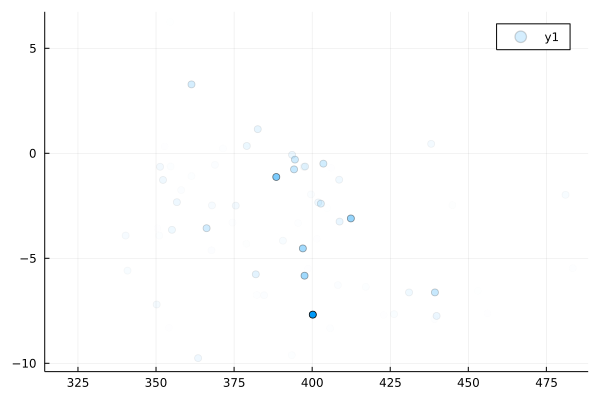

In [107]:
@df balance_sheet_year_sel scatter(:HHI, :G, alpha = :weight)

In [108]:
result = reg(
    
    balance_sheet_year_sel,
    @formula(G ~ Frac1 + HHI),
    
    weights = :V_A)

                               Linear Model                               
Number of obs:                   105  Degrees of freedom:                3
R2:                            0.749  R2 Adjusted:                   0.744
F-Stat:                      151.821  p-value:                       0.000
G           |   Estimate Std.Error  t value Pr(>|t|) Lower 95%   Upper 95%
--------------------------------------------------------------------------
Frac1       |   -7.96031   0.48516 -16.4076    0.000  -8.92263      -6.998
HHI         | -0.0219058 0.0069948 -3.13173    0.002  -0.03578 -0.00803169
(Intercept) |    8.97331   2.73837  3.27688    0.001   3.54177     14.4049


In [109]:
df = @transform(balance_sheet_sel, Frac1 = :R_1 ./ :R_ex5)

result2 = reg(
    df,
    @formula(G ~ Frac1 + HHI),
    )
#     weights = :V_A)

result = lm(
    @formula(G ~ Frac1 + HHI),
    df,
    )
#     wts = df[:, :V_A])

result2.vcov .= vcov(result, CRHC1(convert(Array, df[:, :NAIC_no])))
# result2.vcov .= vcov(result, QuadraticSpectralKernel(NeweyWest))

result2

LoadError: MethodError: no method matching vcov(::LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, ::CRHC1{Vector{Int64}, Nothing})
[0mClosest candidates are:
[0m  vcov([91m::Union{StatsModels.TableRegressionModel, StatsModels.TableStatisticalModel}[39m, ::Any...; kwargs...) at C:\Users\Max\.julia\packages\StatsModels\j0Cya\src\statsmodel.jl:28
[0m  vcov([91m::CovarianceMatrices.HC[39m, ::T; scale) where T at C:\Users\Max\.julia\packages\CovarianceMatrices\3gSu1\src\interface_api.jl:85
[0m  vcov([91m::T[39m, ::Any; prewhite, dof_adjustment, scale) where T<:Union{CovarianceMatrices.HAC, Smoothed} at C:\Users\Max\.julia\packages\CovarianceMatrices\3gSu1\src\interface_api.jl:21
[0m  ...

In [110]:
# # select balance sheet companies 
# balance_public = sort(copy(balance_NAIC_year), [:NAIC_no, :year])

# balance_public[!, :PERMNO] = [get(NAIC_PERMNO_dict, s, 0) for s in balance_public[!, :NAIC_no]]

# balance_public = @combine(groupby(balance_public, [:PERMNO, :year]), 
#     D_A = sum(:D_A .* :Value_A) / sum(:Value_A),
#     Value_A = sum(:Value_A),
#     Reserve_A = sum(:Reserve_A),

#     D_L = sum(:D_L .* :Value_L) / sum(:Value_L),
#     Value_L = sum(:Value_L),
#     Reserve_L = sum(:Reserve_L),
# )

# balance_public = @where(balance_public, :PERMNO .!= 0)

# balance_public = innerjoin(balance_public, book_data, on = [:PERMNO, :year => :fyear])

In [111]:
# public companies without book info 
balance_public_without = sort(copy(L_NAIC_year), [:NAIC_no, :year])
balance_public_without[!, :PERMNO] = [get(NAIC_PERMNO_dict, s, 0) for s in balance_public_without[!, :NAIC_no]]

balance_public_without = @combine(groupby(balance_public_without, [:PERMNO, :year]), 
    D_L = sum(:D_L .* :Value_L) / sum(:Value_L),
    Value_L = sum(:Value_L),
    Reserve_L = sum(:Reserve_L),
    ResVar_L = sum(:ResVar_L),
)

balance_public_without = @where(balance_public_without, :PERMNO .!= 0)

┌ Warning: `@where is deprecated, use `@subset`  with `@skipmissing` instead.
└ @ DataFramesMeta C:\Users\Max\.julia\packages\DataFramesMeta\EDzWO\src\macros.jl:586


,PERMNO,year,D_L,Value_L,Reserve_L,ResVar_L
,Int64,Int64,Float64,Float64,Float64,Float64
1,13904,2001,14.4989,2.0323e10,2.12252e10,2.72291e10
2,13904,2002,13.6197,1.8253e10,1.78374e10,3.90959e10
3,13904,2003,14.8613,2.35106e10,2.28023e10,4.19821e10
4,13904,2004,16.6297,2.89222e10,2.95546e10,4.26872e10
5,13904,2005,15.2828,4.54154e10,4.12075e10,3.75236e10
6,13904,2006,14.2267,4.51391e10,4.23659e10,3.47138e10
7,13904,2007,13.6598,4.37178e10,4.2534e10,3.38109e10
8,13904,2008,14.4874,4.87691e10,4.36142e10,3.90528e10
9,13904,2009,14.2571,5.24062e10,4.45634e10,3.97615e10


In [112]:
# liabilities with book info
balance_public_with = sort(copy(balance_sheet), [:NAIC_no, :year])
balance_public_with[!, :PERMNO] = [get(NAIC_PERMNO_dict, s, 0) for s in balance_public_with[!, :NAIC_no]]

balance_public_with = @combine(groupby(balance_public_with, [:PERMNO, :year]), 
    V_A = sum(:V_A),
    D_A = sum(:D_A .* :V_A) / sum(:V_A),
    V_A_m_d = sum(:V_A_m_d),
    V_A_MTGE = sum(:V_A_MTGE),
    D_L = sum(:D_L .* :V_L) / sum(:V_L),
    V_L = sum(:V_L),
    R_L = sum(:R_L),
    ResVar_L = sum(:ResVar_L),
    DD_L = sum(:DD_L),
)

balance_public_with = @where(balance_public_with, :PERMNO .!= 0)

balance_public_with = innerjoin(balance_public_with, book_data, on = [:PERMNO, :year => :fyear])

@transform!(balance_public_with, 
    at = :at .* 1000000,
    lt = :lt .* 1000000,
    )

┌ Warning: `@where is deprecated, use `@subset`  with `@skipmissing` instead.
└ @ DataFramesMeta C:\Users\Max\.julia\packages\DataFramesMeta\EDzWO\src\macros.jl:586


,PERMNO,year,V_A,D_A,V_A_m_d,V_A_MTGE,D_L,V_L,R_L,ResVar_L,DD_L,at,lt,eq,saa,sal
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64
1,13507,2004,1.28001e10,7.53769,1.22823e9,1.97131e9,12.1024,8.3363e9,8.8838e9,6.82439e8,1.0089e11,1.65708e16,1.3279e16,3.29183e9,4.64e8,4.64e8
2,13507,2005,1.34664e10,7.30655,1.37919e9,2.30905e9,12.9322,9.12694e9,9.19639e9,6.85173e8,1.18031e11,1.75169e16,1.41366e16,3.38028e9,5.43e8,5.43e8
3,13507,2006,1.38718e10,6.93494,1.23199e9,2.45227e9,12.2502,8.29201e9,8.70046e9,8.84823e8,1.01579e11,1.79322e16,1.43505e16,3.58163e9,6.5e8,6.5e8
4,13507,2007,1.438e10,6.76946,1.27592e9,2.61191e9,12.5444,9.03548e9,9.49584e9,8.95008e8,1.13345e11,1.84649e16,1.47235e16,3.74132e9,7.81e8,7.81e8
5,13507,2008,1.4299e10,5.73052,1.28001e9,3.01214e9,13.0248,1.0683e10,1.02931e10,9.01049e8,1.39143e11,1.83794e16,1.52372e16,3.14223e9,5.61e8,5.61e8
6,13507,2009,1.58549e10,5.7992,1.16162e9,3.38701e9,12.4606,1.24376e10,1.14965e10,9.00449e8,1.5498e11,2.01495e16,1.66771e16,3.47241e9,7.18e8,7.18e8
7,13507,2010,1.68963e10,6.09766,1.2304e9,3.65505e9,11.5626,1.34249e10,1.25238e10,8.89671e8,1.55227e11,2.1413e16,1.77772e16,3.63588e9,7.81e8,7.81e8
8,13507,2011,1.79784e10,5.72335,1.24164e9,3.88102e9,11.7895,1.47731e10,1.31936e10,9.29889e8,1.74167e11,2.25243e16,1.88543e16,3.66998e9,7.48e8,7.48e8
9,13507,2012,1.8274e10,5.9411,1.24795e9,3.7847e9,13.9937,1.71357e10,1.34135e10,9.47709e8,2.39791e11,2.31071e16,1.92677e16,3.83933e9,8.41e8,8.41e8


In [113]:
balance_public_with_year = @combine(groupby(sort(balance_public_with, :year), :year), 
    at = sum(:at),
    lt = sum(:lt),
    V_A = sum(:V_A),
    D_A = sum(:D_A .* :V_A) / sum(:V_A),
    V_L = sum(:V_L),
    D_L = sum(:DD_L) ./ sum(:V_L),
)

@transform!(balance_public_with_year, 
    G = :D_A .- :lt ./ :at .* :D_L,
    D_E_b = :at ./ (:at .- :lt) .* (:D_A .- :lt ./ :at .* :D_L),
)

,year,at,lt,V_A,D_A,V_L,D_L,G,D_E_b
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2004,1.29256e18,1.19457e18,5.9579e11,7.61606,2.79773e11,13.7408,-5.08298,-67.0431
2,2005,1.55935e18,1.4448e18,6.4187e11,7.63237,3.19441e11,15.4093,-6.64501,-90.4587
3,2006,1.74704e18,1.62008e18,6.86113e11,7.69597,3.11414e11,14.8617,-6.0857,-83.7393
4,2007,1.84962e18,1.72099e18,7.34043e11,7.3457,3.45401e11,14.4616,-6.11015,-87.8574
5,2008,1.66096e18,1.58033e18,7.48893e11,6.70094,4.02352e11,15.0481,-7.61671,-156.904
6,2009,1.79453e18,1.666e18,7.51736e11,7.05771,4.29854e11,15.0496,-6.91396,-96.5316
7,2010,2.10644e18,1.94557e18,7.75131e11,7.55632,4.28395e11,14.9677,-6.26831,-82.0795
8,2011,2.2874e18,2.10439e18,8.13507e11,7.24097,4.69214e11,15.6105,-7.12052,-88.9969
9,2012,2.45356e18,2.26426e18,8.49258e11,7.20719,5.75447e11,18.2265,-9.61312,-124.597


In [ ]:
print(reg(balance_yearly, 
    @formula(
        D_E ~ -1 + D_E_balance_est1
    )
))

print(reg(balance_yearly, 
    @formula(
        D_E ~ -1 + D_E_balance_est2
    )
))

print(reg(balance_yearly, 
    @formula(
        D_E ~ -1 + D_E_balance_est3
    )
))

print(reg(balance_yearly, 
    @formula(
        D_E ~ -1 + D_E_balance_est4
    )
))